In [17]:
# TODO

## Imports

In [18]:
import pandas as pd
import geopandas as gpd
import numpy as np
import pypsa
import math
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from shapely.geometry import Point, LineString
from datetime import datetime
import matplotlib.patheffects as pe
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

from datetime import date, datetime, time, timedelta

# imported own functions
from utils import market_values, market_values_by_time_index, nodal_balance, capacity, capacity_links, capacity_storage_units, get_condense_sum, nodal_balance, generation, generation_links, generation_storage_units, market_values_storage_units, market_values_links, time_stored_LIFO

# imported own definitions
from utils import carrier_colors, carrier_renaming, carrier_renaming_reverse, resistive_heater, gas_boiler, heat_pump, water_tanks_charger, water_tanks_discharger, solar_thermal
from utils import c_el_gen_s, c_el_con_s

# general variables
font1 = {'fontname':'Calibri'}
PLOT_DIR = 'C:/Users/Julian/Studies/Master/01 TU Berlin/3. Semester - Masterarbeit/MA Marktwerte FEE/data/plots/'
onshore_regions = gpd.read_file("../data/external/regions_onshore_elec_s_181.geojson")
offshore_regions = gpd.read_file("../data/external/regions_offshore_elec_s_181.geojson")
onshore_regions = onshore_regions.set_index('name')
offshore_regions = offshore_regions.set_index('name')

In [19]:
# Network imports
n_no =pypsa.Network("../data/raw/elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc")
n_h2 =pypsa.Network("../data/raw/elec_s_181_lvopt__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10_2030.nc")

INFO:pypsa.io:Imported network elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_181_lvopt__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [20]:
# stst and exp dataframes
# spatial
df_stst_ons = pd.read_pickle("../data/processed/df_stst_ons.pkl")
df_stst_off = pd.read_pickle("../data/processed/df_stst_off.pkl")
df_exp_ons = pd.read_pickle("../data/processed/df_exp_ons.pkl")
df_exp_off = pd.read_pickle("../data/processed/df_exp_off.pkl")

# temporal
df_stst_ts = pd.read_pickle("../data/processed/df_stst_ts.pkl")
df_exp_ts = pd.read_pickle("../data/processed/df_exp_ts.pkl")

In [21]:
# Notebook Definitions
c1_groups = [resistive_heater, gas_boiler, heat_pump, water_tanks_charger, water_tanks_discharger, solar_thermal]
c1_groups_name = ["resistive heater", "gas boiler", "heat pump", "water tanks charger", "water tanks discharger", "solar thermal"]
markers =["v", "^", "<", ">", "1", "2", "3", "4", "*", "+", "d", "o", "|", "s", "P", "p", "h"]

In [22]:
# Notebook Functions

def get_df(df_no, df_h2, carriers):
    result = pd.DataFrame(index = ["STST", "EXP"])

    for c in carriers:
        result.loc["STST" , c] = df_no[c].values
        result.loc["EXP" , c] = df_h2[c].values
    return result

def c_gen(carrier_list, network):
    result = []
    for c in carrier_list:
        if c in network.generators.carrier.unique().tolist():
            result.append(c)
    return result

def c_link(carrier_list, network):
    result = []
    for c in carrier_list:
        if c in network.links.carrier.unique().tolist():
            result.append(c)
    return result

def c_su(carrier_list, network):
    result = []
    for c in carrier_list:
        if c in network.storage_units.carrier.unique().tolist():
            result.append(c)
    return result

In [23]:
# Regions

onshore_regions['coords'] = onshore_regions['geometry'].apply(lambda x: x.representative_point().coords[:])
onshore_regions['coords'] = [coords[0] for coords in onshore_regions['coords']]
onshore_regions["name"] = onshore_regions.index
offshore_regions['coords'] = offshore_regions['geometry'].apply(lambda x: x.representative_point().coords[:])
offshore_regions['coords'] = [coords[0] for coords in offshore_regions['coords']]
offshore_regions["name"] = offshore_regions.index

## CALC

In [24]:
# calc market values, generation, lmps, capacity factors for generators, links and storage units

for n in [n_no, n_h2]:
    df_regions_onshore = onshore_regions.copy()
    df_regions_offshore = offshore_regions.copy()

    # function for carriers in n.generators.carrier.unique() #13
    for carrier in n.generators.carrier.unique():
        df_regions_onshore[f"{carrier}_mv"] = market_values(n, carrier)
        df_regions_offshore[f"{carrier}_mv"] = market_values(n, carrier)
        # generation in TWh (does this have to be multiplied by 3??
        df_regions_onshore[f"{carrier}_gen"] = generation(n, carrier) / 1000
        df_regions_offshore[f"{carrier}_gen"] = generation(n, carrier) / 1000
        # lmps
        # capacity factors This calculation is correct? as capacity is multiplied by 2920 is the same as multiplying the generation by 3 and then dividing it by the capacity times 8760 (as cap is in MWh?)
        df_regions_onshore[f"{carrier}_cf"] = generation(n, carrier) / (capacity(n, carrier) *2920)
        df_regions_offshore[f"{carrier}_cf"] = generation(n, carrier) / (capacity(n, carrier) *2920)


    # function for carriers in n.links.carrier.unique() #53
    for carrier in n.links.carrier.unique():
        df_regions_onshore[f"{carrier}_mv"] = market_values_links(n, carrier)
        df_regions_onshore[f"{carrier}_gen"] = generation_links(n, carrier) / 1000
        df_regions_onshore[f"{carrier}_cf"] = generation_links(n, carrier) / (capacity_links(n, carrier) *2920)

    # function for carriers in n.storage_units.carrier.unique() #2
    for carrier in n.storage_units.carrier.unique():
        df_regions_onshore[f"{carrier}_mv"] = market_values_storage_units(n, carrier)
        df_regions_onshore[f"{carrier}_gen"] = generation_storage_units(n, carrier) / 1000
        # capacity factors (both generation and consumption(loading) is considered
        gen = abs(n.storage_units_t.p.loc[:, n.storage_units.carrier == carrier])
        gen.columns = gen.columns.map(n.storage_units.bus)
        gen.columns = gen.columns.map(n.buses.location)
        df_regions_onshore[f"{carrier}_cf"] = gen.sum() / (capacity_storage_units(n, carrier) *2920)

    # set market values to nan where generation in corresponding region is lower than % quantile
    qt = 0.2
    for carrier in (n.generators.carrier.unique().tolist() +
                    n.links.carrier.unique().tolist() +
                    n.storage_units.carrier.unique().tolist()):
        index = df_regions_onshore[f"{carrier}_gen"] <= np.quantile(df_regions_onshore[f"{carrier}_gen"], qt)
        df_regions_onshore[f"{carrier}_mv"][index] = np.nan

    # calc lmps at the buses (lmps that are only present for EU (e.g. oil) are nan at the moment)
    # TODO: decide if EU lmps are used as lmp for all regions
    for carrier_bus in n.buses.carrier.unique():
        # index would be same names as the bus (not the location as it is in the index of
        # df_regions_onshore so far -> map location to make sure the right lmp is set
        locs = n.buses.location[n.buses[n.buses.carrier == carrier_bus].index]
        lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier == carrier_bus].index].mean()
        df = pd.concat([lmps, locs], axis=1).rename(columns={0: f"{carrier_bus}_lmp"})
        df.set_index("location", inplace=True)
        if df.size == 1:
            if df.index == "EU":
                df = pd.DataFrame(np.repeat(df.values, 181), index=df_regions_onshore.index, columns=[f"{carrier_bus}_lmp"])
                df_regions_onshore[f"{carrier_bus}_lmp"] = df[f"{carrier_bus}_lmp"]
        else:
            df_regions_onshore[f"{carrier_bus}_lmp"] = df[f"{carrier_bus}_lmp"]

    if n == n_no:
        df_no_ons = df_regions_onshore
        df_no_off = df_regions_offshore

    if n == n_h2:
        df_h2_ons = df_regions_onshore
        df_h2_off = df_regions_offshore

df_no_ons.head()

geometry  \
name                                                       
AL0 0  POLYGON ((20.32207 39.91318, 20.39703 39.81809...   
AT0 0  POLYGON ((16.45660 47.41184, 16.43396 47.39685...   
AT0 1  POLYGON ((10.08288 47.35907, 10.20928 47.37248...   
AT0 2  POLYGON ((13.47802 46.56357, 13.23111 46.55217...   
BA0 0  POLYGON ((17.82716 42.85312, 17.81176 42.90986...   

                                         coords   name  offwind-ac_mv  \
name                                                                    
AL0 0    (20.00648437943388, 41.14563914300007)  AL0 0     126.148417   
AT0 0  (15.700718667666258, 47.896990619088925)  AT0 0            NaN   
AT0 1   (10.379200993764837, 47.18231496200006)  AT0 1            NaN   
AT0 2   (13.805469952867842, 47.57283376100011)  AT0 2            NaN   
BA0 0    (17.97055162265331, 43.88773569750005)  BA0 0            NaN   

       offwind-ac_gen  offwind-ac_cf  onwind_mv    onwind_gen  onwind_cf  \
name                                                                       
AL0 0        0.009746       0.090705        NaN      0.005042   0.038018   
AT0 0             NaN            NaN  83.457109  10131.968084   0.149667   
AT0 1             NaN            NaN        NaN      0.000116   0.004685   
AT0 2             NaN            NaN        NaN      0.004773   0.039178   
BA0 0             NaN            NaN        NaN      0.004686   0.031802   

        solar_mv  ...  urban central water tanks_lmp  biogas_lmp  \
name              ...                                              
AL0 0  44.628736  ...                      43.532557  113.716896   
AT0 0  54.679083  ...                      55.231280  113.716896   
AT0 1  65.745903  ...                      55.553668  113.716896   
AT0 2  58.223787  ...                      58.936874  113.716896   
BA0 0  51.160537  ...                      51.074197  113.716896   

       solid biomass_lmp  solid biomass for industry_lmp  \
name                                                       
AL0 0         102.453861                       78.924392   
AT0 0         102.453861                       78.924392   
AT0 1         102.453861                       78.924392   
AT0 2         102.453861                       78.924392   
BA0 0         102.453861                       78.924392   

       gas for industry_lmp  H2 liquid_lmp    oil_lmp  process emissions_lmp  \
name                                                                           
AL0 0            113.135704     137.617875  50.009981            -408.520212   
AT0 0            113.135704     151.448316  50.009981            -408.520212   
AT0 1            113.135704     154.026970  50.009981            -408.520212   
AT0 2            113.135704     148.663198  50.009981            -408.520212   
BA0 0            113.135704     147.689672  50.009981            -408.520212   

       low voltage_lmp  home battery_lmp  
name                                      
AL0 0       100.338046        100.380697  
AT0 0       115.006246        115.044440  
AT0 1       121.910720        121.947576  
AT0 2       112.352878        112.386673  
BA0 0       112.040690        112.006725  

[5 rows x 233 columns]

In [25]:
#assert 0

# 4.1 Overview

## Network Overview

In [26]:
print(n_no)

PyPSA Network
Components:
 - Bus: 3086
 - Carrier: 30
 - Generator: 1707
 - GlobalConstraint: 3
 - Line: 323
 - Link: 8375
 - Load: 2542
 - StorageUnit: 170
 - Store: 1635
Snapshots: 2920


In [27]:
print(n_h2)

PyPSA Network
Components:
 - Bus: 3086
 - Carrier: 30
 - Generator: 1707
 - GlobalConstraint: 2
 - Line: 323
 - Link: 9192
 - Load: 2542
 - StorageUnit: 170
 - Store: 1635
Snapshots: 2920


### Electricity network

In [28]:
m_no = n_no.copy()
m_no.mremove("Bus",m_no.buses[m_no.buses.x == 0].index )

m_h2 = n_h2.copy()
m_h2.mremove("Bus",m_h2.buses[m_h2.buses.x == 0].index )

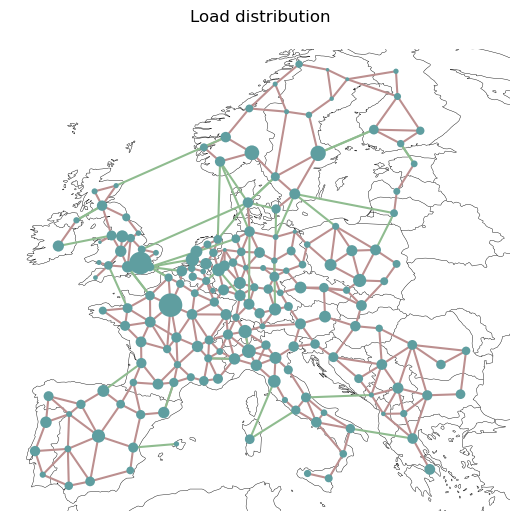

In [29]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(8, 6))

bus_locs = pd.Index(m_no.buses.location.unique())
load_distribution = m_no.loads_t.p[bus_locs].sum()/m_no.loads_t.p[bus_locs].sum().max()

m_no.plot(bus_sizes=1*load_distribution, ax=ax, projection=ccrs.EqualEarth())
ax.set_title("Load distribution", pad=20)
plt.show()
# same for m_h2

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(14, 6))

norm_lines = max(n_no.lines.s_nom_opt.max(), n_h2.lines.s_nom_opt.max(),(n_h2.lines.s_nom_opt - n_no.lines.s_nom_opt).max())
norm_links = max(n_no.links.p_nom_opt[n_no.links.carrier == "DC"].max(), n_h2.links.p_nom_opt[n_h2.links.carrier == "DC"].max(), (n_h2.links.p_nom_opt - n_no.links.p_nom_opt)[n_h2.links.carrier == "DC"].max() )

scale_lines = 7
scale_links = 7

# STST
hvac_weights = n_no.lines.s_nom_opt / norm_lines * scale_lines
hvdc_weights = n_no.links.p_nom_opt.replace(0, 1) / norm_links * scale_links

m_no.plot(ax=ax1, projection=ccrs.EqualEarth(), bus_colors="black", line_colors="gold", link_colors="deepskyblue", line_widths=hvac_weights, link_widths=hvdc_weights )
pypsa.plot.add_legend_patches(ax=ax1, labels=["HVAC lines", "HVDC lines"], colors=["gold","deepskyblue"], legend_kw={'loc': 'upper left'})
ax1.set_title("Electricity grid (STST)", pad=10)

# EXP
hvac_weights = n_h2.lines.s_nom_opt / norm_lines * scale_lines
hvdc_weights = n_h2.links.p_nom_opt.replace(0, 1) / norm_links * scale_links

m_h2.plot(ax=ax2, projection=ccrs.EqualEarth(), bus_colors="black", line_colors="gold", link_colors="deepskyblue", line_widths=hvac_weights, link_widths=hvdc_weights )
pypsa.plot.add_legend_patches(ax=ax2, labels=["HVAC lines", "HVDC lines"], colors=["gold","deepskyblue"], legend_kw={'loc': 'upper left'})
ax2.set_title("Electricity grid (EXP)", pad=10)

fig.tight_layout()
plt.close()
plt.show()

#fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/el_grid.png")

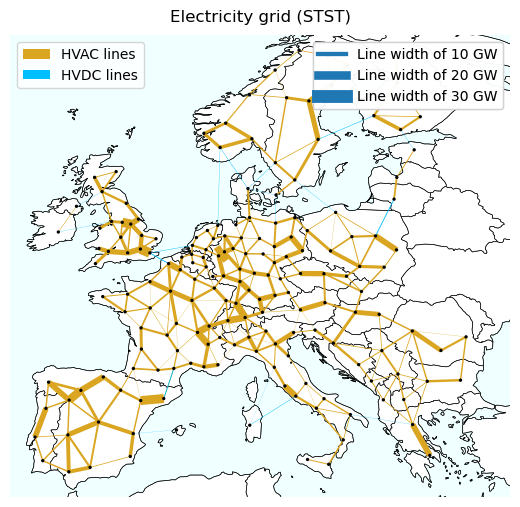

In [31]:
# plot of difference in grid

fig, ax1 = plt.subplots(1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(18, 6))

norm_lines = max(n_no.lines.s_nom_opt.max(), n_h2.lines.s_nom_opt.max(),(n_h2.lines.s_nom_opt - n_no.lines.s_nom_opt).max())
norm_links = max(n_no.links.p_nom_opt[n_no.links.carrier == "DC"].max(), n_h2.links.p_nom_opt[n_h2.links.carrier == "DC"].max(), (n_h2.links.p_nom_opt - n_no.links.p_nom_opt)[n_h2.links.carrier == "DC"].max() )
norm_both = max(norm_lines, norm_links)

scale_lines = 7
scale_links = 3.5
scale_both = 12

# STST
hvac_weights = n_no.lines.s_nom_opt / norm_both * scale_both
hvdc_weights = n_no.links.p_nom_opt.replace(0, 1) / norm_both * scale_both

m_no.plot(ax=ax1, projection=ccrs.EqualEarth(), bus_colors="black", line_colors="goldenrod", link_colors="deepskyblue", line_widths=hvac_weights, link_widths=hvdc_weights )
pypsa.plot.add_legend_patches(ax=ax1, labels=["HVAC lines", "HVDC lines"], colors=["goldenrod","deepskyblue"], legend_kw={'loc': 'upper left'})
ax1.set_title("Electricity grid (STST)", pad=10)
ax1.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
ax1.coastlines(edgecolor='black', linewidth=0.5)
ax1.set_facecolor('white')
ax1.add_feature(cartopy.feature.OCEAN, color='azure')

# add line width to legend
cap_1 = int(np.round(10000, -3) / 1e3)
lw_1 = np.round(10000, -3) / norm_both * scale_both
cap_2 = int(np.round(20000, -3) / 1e3)
lw_2 = np.round(20000, -3) / norm_both * scale_both
cap_3 = int(np.round(30000, -3) / 1e3)
lw_3 = np.round(30000, -3) / norm_both * scale_both

pypsa.plot.add_legend_lines(
    ax1,
    [lw_1, lw_2, lw_3],
    [f"Line width of {cap_1} GW", f"Line width of {cap_2} GW", f"Line width of {cap_3} GW"]
)

KeyError: "['H2 pipeline AL0 0 -> GR0 1', 'H2 pipeline AL0 0 -> ME0 0', 'H2 pipeline AL0 0 -> MK0 0', 'H2 pipeline AL0 0 -> RS0 0', 'H2 pipeline AT0 0 -> AT0 2', 'H2 pipeline AT0 0 -> CZ0 0', 'H2 pipeline AT0 0 -> HU0 0', 'H2 pipeline AT0 1 -> AT0 2', 'H2 pipeline AT0 1 -> CH0 1', 'H2 pipeline AT0 1 -> DE0 16', 'H2 pipeline AT0 1 -> DE0 9', 'H2 pipeline AT0 2 -> DE0 6', 'H2 pipeline AT0 2 -> IT0 16', 'H2 pipeline AT0 2 -> SI0 0', 'H2 pipeline BA0 0 -> HR0 0', 'H2 pipeline BA0 0 -> ME0 0', 'H2 pipeline BA0 0 -> RS0 1', 'H2 pipeline BE0 0 -> BE0 4', 'H2 pipeline BE0 0 -> FR0 8', 'H2 pipeline BE0 0 -> GB5 9', 'H2 pipeline BE0 1 -> BE0 2', 'H2 pipeline BE0 1 -> BE0 3', 'H2 pipeline BE0 1 -> DE0 7', 'H2 pipeline BE0 1 -> FR0 15', 'H2 pipeline BE0 1 -> FR0 4', 'H2 pipeline BE0 1 -> LU0 0', 'H2 pipeline BE0 2 -> BE0 4', 'H2 pipeline BE0 3 -> BE0 4', 'H2 pipeline BE0 3 -> NL0 2', 'H2 pipeline BE0 4 -> NL0 0', 'H2 pipeline BG0 0 -> BG0 1', 'H2 pipeline BG0 0 -> RO0 2', 'H2 pipeline BG0 1 -> GR0 1', 'H2 pipeline BG0 1 -> MK0 0', 'H2 pipeline BG0 1 -> RO0 0', 'H2 pipeline BG0 1 -> RS0 0', 'H2 pipeline CH0 0 -> CH0 1', 'H2 pipeline CH0 0 -> DE0 2', 'H2 pipeline CH0 0 -> FR0 2', 'H2 pipeline CH0 0 -> FR0 21', 'H2 pipeline CH0 0 -> FR0 25', 'H2 pipeline CH0 0 -> IT0 11', 'H2 pipeline CH0 0 -> IT0 12', 'H2 pipeline CH0 1 -> DE0 2', 'H2 pipeline CH0 1 -> IT0 11', 'H2 pipeline CH0 1 -> IT0 5', 'H2 pipeline CZ0 0 -> CZ0 1', 'H2 pipeline CZ0 0 -> CZ0 2', 'H2 pipeline CZ0 0 -> SK0 0', 'H2 pipeline CZ0 1 -> CZ0 2', 'H2 pipeline CZ0 1 -> PL0 5', 'H2 pipeline CZ0 1 -> SK0 0', 'H2 pipeline CZ0 2 -> DE0 20', 'H2 pipeline CZ0 2 -> DE0 25', 'H2 pipeline DE0 0 -> DE0 10', 'H2 pipeline DE0 0 -> DE0 21', 'H2 pipeline DE0 0 -> DE0 26', 'H2 pipeline DE0 0 -> DE0 7', 'H2 pipeline DE0 0 -> NL0 1', 'H2 pipeline DE0 1 -> DE0 19', 'H2 pipeline DE0 1 -> DE0 25', 'H2 pipeline DE0 1 -> DE0 27', 'H2 pipeline DE0 1 -> DE0 9', 'H2 pipeline DE0 10 -> DE0 21', 'H2 pipeline DE0 10 -> DE0 24', 'H2 pipeline DE0 10 -> DE0 26', 'H2 pipeline DE0 10 -> DE0 5', 'H2 pipeline DE0 11 -> DE0 15', 'H2 pipeline DE0 11 -> DE0 21', 'H2 pipeline DE0 11 -> GB5 9', 'H2 pipeline DE0 12 -> DE0 18', 'H2 pipeline DE0 12 -> DE0 3', 'H2 pipeline DE0 12 -> DE0 8', 'H2 pipeline DE0 13 -> DE0 15', 'H2 pipeline DE0 13 -> DE0 16', 'H2 pipeline DE0 13 -> DE0 2', 'H2 pipeline DE0 13 -> DE0 22', 'H2 pipeline DE0 13 -> DE0 27', 'H2 pipeline DE0 14 -> DE0 19', 'H2 pipeline DE0 14 -> DE0 20', 'H2 pipeline DE0 14 -> DE0 24', 'H2 pipeline DE0 15 -> DE0 21', 'H2 pipeline DE0 15 -> DE0 23', 'H2 pipeline DE0 15 -> DE0 4', 'H2 pipeline DE0 15 -> DK0 0', 'H2 pipeline DE0 15 -> NO3 5', 'H2 pipeline DE0 16 -> DE0 9', 'H2 pipeline DE0 17 -> DE0 22', 'H2 pipeline DE0 17 -> DE0 5', 'H2 pipeline DE0 17 -> DE0 7', 'H2 pipeline DE0 17 -> FR0 4', 'H2 pipeline DE0 17 -> LU0 0', 'H2 pipeline DE0 18 -> DE0 20', 'H2 pipeline DE0 18 -> PL0 3', 'H2 pipeline DE0 19 -> DE0 20', 'H2 pipeline DE0 19 -> DE0 25', 'H2 pipeline DE0 19 -> DE0 8', 'H2 pipeline DE0 2 -> DE0 22', 'H2 pipeline DE0 2 -> FR0 21', 'H2 pipeline DE0 21 -> DE0 24', 'H2 pipeline DE0 21 -> DE0 4', 'H2 pipeline DE0 22 -> DE0 27', 'H2 pipeline DE0 22 -> DE0 5', 'H2 pipeline DE0 22 -> DE0 7', 'H2 pipeline DE0 23 -> DE0 3', 'H2 pipeline DE0 23 -> DE0 8', 'H2 pipeline DE0 23 -> DK3 0', 'H2 pipeline DE0 23 -> SE3 3', 'H2 pipeline DE0 24 -> DE0 27', 'H2 pipeline DE0 24 -> DE0 4', 'H2 pipeline DE0 24 -> DE0 5', 'H2 pipeline DE0 25 -> DE0 6', 'H2 pipeline DE0 26 -> DE0 5', 'H2 pipeline DE0 26 -> DE0 7', 'H2 pipeline DE0 27 -> DE0 5', 'H2 pipeline DE0 3 -> PL0 3', 'H2 pipeline DE0 4 -> DE0 8', 'H2 pipeline DE0 6 -> DE0 9', 'H2 pipeline DE0 7 -> NL0 1', 'H2 pipeline DE0 7 -> NL0 2', 'H2 pipeline DE0 8 -> DE0 9', 'H2 pipeline DK0 0 -> DK3 0', 'H2 pipeline DK0 0 -> GB5 2', 'H2 pipeline DK0 0 -> NL0 3', 'H2 pipeline DK0 0 -> NO3 5', 'H2 pipeline DK0 0 -> SE3 6', 'H2 pipeline DK3 0 -> SE3 3', 'H2 pipeline EE6 0 -> FI3 4', 'H2 pipeline EE6 0 -> LV6 0', 'H2 pipeline ES0 0 -> ES0 11', 'H2 pipeline ES0 0 -> ES0 6', 'H2 pipeline ES0 0 -> PT0 2', 'H2 pipeline ES0 1 -> ES0 10', 'H2 pipeline ES0 1 -> ES0 11', 'H2 pipeline ES0 1 -> ES0 12', 'H2 pipeline ES0 1 -> ES0 4', 'H2 pipeline ES0 1 -> ES0 6', 'H2 pipeline ES0 1 -> ES0 8', 'H2 pipeline ES0 10 -> ES0 2', 'H2 pipeline ES0 10 -> ES0 4', 'H2 pipeline ES0 10 -> ES0 6', 'H2 pipeline ES0 10 -> PT0 1', 'H2 pipeline ES0 11 -> ES0 5', 'H2 pipeline ES0 11 -> ES0 6', 'H2 pipeline ES0 12 -> ES0 3', 'H2 pipeline ES0 12 -> ES0 9', 'H2 pipeline ES0 12 -> FR0 23', 'H2 pipeline ES0 2 -> ES0 4', 'H2 pipeline ES0 2 -> PT0 1', 'H2 pipeline ES0 3 -> ES0 7', 'H2 pipeline ES0 3 -> ES0 8', 'H2 pipeline ES0 3 -> FR0 23', 'H2 pipeline ES0 4 -> ES0 9', 'H2 pipeline ES0 5 -> ES0 8', 'H2 pipeline ES0 6 -> PT0 0', 'H2 pipeline ES0 6 -> PT0 2', 'H2 pipeline ES0 7 -> FR0 26', 'H2 pipeline ES0 8 -> ES2 0', 'H2 pipeline ES0 9 -> FR0 12', 'H2 pipeline FI3 0 -> FI3 1', 'H2 pipeline FI3 0 -> FI3 2', 'H2 pipeline FI3 0 -> FI3 4', 'H2 pipeline FI3 0 -> SE3 0', 'H2 pipeline FI3 1 -> FI3 2', 'H2 pipeline FI3 1 -> FI3 3', 'H2 pipeline FI3 1 -> SE3 7', 'H2 pipeline FI3 2 -> FI3 4', 'H2 pipeline FI3 3 -> SE3 7', 'H2 pipeline FR0 0 -> FR0 14', 'H2 pipeline FR0 0 -> FR0 24', 'H2 pipeline FR0 0 -> FR0 26', 'H2 pipeline FR0 1 -> FR0 11', 'H2 pipeline FR0 1 -> FR0 17', 'H2 pipeline FR0 1 -> FR0 19', 'H2 pipeline FR0 1 -> FR0 22', 'H2 pipeline FR0 1 -> FR0 5', 'H2 pipeline FR0 1 -> FR0 7', 'H2 pipeline FR0 1 -> FR0 8', 'H2 pipeline FR0 10 -> FR0 13', 'H2 pipeline FR0 10 -> FR0 14', 'H2 pipeline FR0 10 -> IT0 12', 'H2 pipeline FR0 11 -> FR0 15', 'H2 pipeline FR0 11 -> FR0 16', 'H2 pipeline FR0 11 -> FR0 17', 'H2 pipeline FR0 11 -> FR0 21', 'H2 pipeline FR0 11 -> FR0 25', 'H2 pipeline FR0 11 -> FR0 4', 'H2 pipeline FR0 12 -> FR0 20', 'H2 pipeline FR0 12 -> FR0 23', 'H2 pipeline FR0 12 -> FR0 6', 'H2 pipeline FR0 13 -> FR0 14', 'H2 pipeline FR0 13 -> FR0 16', 'H2 pipeline FR0 13 -> FR0 2', 'H2 pipeline FR0 13 -> FR0 25', 'H2 pipeline FR0 13 -> IT0 12', 'H2 pipeline FR0 15 -> FR0 4', 'H2 pipeline FR0 15 -> FR0 8', 'H2 pipeline FR0 16 -> FR0 17', 'H2 pipeline FR0 16 -> FR0 24', 'H2 pipeline FR0 16 -> FR0 25', 'H2 pipeline FR0 17 -> FR0 24', 'H2 pipeline FR0 17 -> FR0 5', 'H2 pipeline FR0 17 -> FR0 7', 'H2 pipeline FR0 18 -> FR0 22', 'H2 pipeline FR0 18 -> FR0 3', 'H2 pipeline FR0 18 -> FR0 7', 'H2 pipeline FR0 18 -> FR0 9', 'H2 pipeline FR0 18 -> GB5 6', 'H2 pipeline FR0 19 -> FR0 22', 'H2 pipeline FR0 19 -> FR0 8', 'H2 pipeline FR0 19 -> GB5 9', 'H2 pipeline FR0 2 -> FR0 25', 'H2 pipeline FR0 2 -> IT0 12', 'H2 pipeline FR0 20 -> FR0 5', 'H2 pipeline FR0 20 -> FR0 7', 'H2 pipeline FR0 20 -> FR0 9', 'H2 pipeline FR0 21 -> FR0 25', 'H2 pipeline FR0 21 -> FR0 4', 'H2 pipeline FR0 22 -> FR0 7', 'H2 pipeline FR0 22 -> GB5 10', 'H2 pipeline FR0 23 -> FR0 6', 'H2 pipeline FR0 24 -> FR0 26', 'H2 pipeline FR0 24 -> FR0 5', 'H2 pipeline FR0 24 -> FR0 6', 'H2 pipeline FR0 26 -> FR0 6', 'H2 pipeline FR0 3 -> FR0 9', 'H2 pipeline FR0 5 -> FR0 7', 'H2 pipeline FR0 7 -> FR0 9', 'H2 pipeline GB4 0 -> GB5 16', 'H2 pipeline GB4 0 -> IE4 0', 'H2 pipeline GB5 0 -> GB5 16', 'H2 pipeline GB5 0 -> GB5 8', 'H2 pipeline GB5 1 -> GB5 10', 'H2 pipeline GB5 1 -> GB5 11', 'H2 pipeline GB5 1 -> GB5 15', 'H2 pipeline GB5 1 -> GB5 6', 'H2 pipeline GB5 1 -> GB5 7', 'H2 pipeline GB5 10 -> GB5 11', 'H2 pipeline GB5 10 -> GB5 13', 'H2 pipeline GB5 10 -> GB5 6', 'H2 pipeline GB5 11 -> GB5 15', 'H2 pipeline GB5 11 -> GB5 2', 'H2 pipeline GB5 11 -> GB5 5', 'H2 pipeline GB5 12 -> GB5 7', 'H2 pipeline GB5 13 -> GB5 17', 'H2 pipeline GB5 13 -> GB5 2', 'H2 pipeline GB5 13 -> GB5 9', 'H2 pipeline GB5 14 -> GB5 6', 'H2 pipeline GB5 15 -> GB5 7', 'H2 pipeline GB5 16 -> GB5 4', 'H2 pipeline GB5 16 -> GB5 7', 'H2 pipeline GB5 16 -> GB5 8', 'H2 pipeline GB5 17 -> GB5 2', 'H2 pipeline GB5 3 -> GB5 6', 'H2 pipeline GB5 4 -> GB5 5', 'H2 pipeline GB5 7 -> IE4 0', 'H2 pipeline GB5 8 -> NO3 2', 'H2 pipeline GB5 9 -> NL0 0', 'H2 pipeline GR0 0 -> GR0 1', 'H2 pipeline GR0 1 -> IT0 10', 'H2 pipeline GR0 1 -> MK0 0', 'H2 pipeline HR0 0 -> HU0 0', 'H2 pipeline HR0 0 -> RS0 1', 'H2 pipeline HR0 0 -> SI0 0', 'H2 pipeline HU0 0 -> HU0 1', 'H2 pipeline HU0 0 -> SK0 0', 'H2 pipeline HU0 1 -> RO0 0', 'H2 pipeline HU0 1 -> RS0 1', 'H2 pipeline IT0 0 -> IT0 11', 'H2 pipeline IT0 0 -> IT0 12', 'H2 pipeline IT0 0 -> IT0 15', 'H2 pipeline IT0 0 -> IT0 5', 'H2 pipeline IT0 0 -> IT0 8', 'H2 pipeline IT0 1 -> IT0 10', 'H2 pipeline IT0 1 -> IT0 14', 'H2 pipeline IT0 1 -> IT0 9', 'H2 pipeline IT0 10 -> IT0 3', 'H2 pipeline IT0 10 -> IT0 9', 'H2 pipeline IT0 11 -> IT0 12', 'H2 pipeline IT0 11 -> IT0 15', 'H2 pipeline IT0 11 -> IT0 5', 'H2 pipeline IT0 13 -> IT0 7', 'H2 pipeline IT0 14 -> IT0 2', 'H2 pipeline IT0 14 -> IT0 4', 'H2 pipeline IT0 14 -> IT0 9', 'H2 pipeline IT0 14 -> ME0 0', 'H2 pipeline IT0 15 -> IT0 16', 'H2 pipeline IT0 15 -> IT0 2', 'H2 pipeline IT0 15 -> IT0 5', 'H2 pipeline IT0 15 -> IT0 8', 'H2 pipeline IT0 16 -> SI0 0', 'H2 pipeline IT0 3 -> IT0 7', 'H2 pipeline IT0 3 -> IT0 9', 'H2 pipeline IT0 4 -> IT0 6', 'H2 pipeline IT0 4 -> IT0 9', 'H2 pipeline IT0 4 -> IT1 0', 'H2 pipeline IT0 6 -> IT0 8', 'H2 pipeline IT0 8 -> IT1 0', 'H2 pipeline LT6 0 -> LV6 0', 'H2 pipeline LT6 0 -> PL0 6', 'H2 pipeline LT6 0 -> SE3 3', 'H2 pipeline ME0 0 -> RS0 0', 'H2 pipeline ME0 0 -> RS0 1', 'H2 pipeline MK0 0 -> RS0 0', 'H2 pipeline NL0 0 -> NL0 2', 'H2 pipeline NL0 0 -> NL0 4', 'H2 pipeline NL0 1 -> NL0 2', 'H2 pipeline NL0 1 -> NL0 3', 'H2 pipeline NL0 1 -> NL0 5', 'H2 pipeline NL0 3 -> NL0 5', 'H2 pipeline NL0 3 -> NO3 5', 'H2 pipeline NL0 4 -> NL0 5', 'H2 pipeline NO3 0 -> NO3 2', 'H2 pipeline NO3 0 -> NO3 3', 'H2 pipeline NO3 0 -> SE3 5', 'H2 pipeline NO3 1 -> NO3 3', 'H2 pipeline NO3 1 -> SE3 4', 'H2 pipeline NO3 2 -> NO3 4', 'H2 pipeline NO3 2 -> NO3 6', 'H2 pipeline NO3 3 -> SE3 5', 'H2 pipeline NO3 4 -> NO3 5', 'H2 pipeline NO3 5 -> NO3 6', 'H2 pipeline NO3 6 -> SE3 6', 'H2 pipeline PL0 0 -> PL0 6', 'H2 pipeline PL0 0 -> PL0 7', 'H2 pipeline PL0 1 -> PL0 2', 'H2 pipeline PL0 1 -> PL0 3', 'H2 pipeline PL0 1 -> PL0 4', 'H2 pipeline PL0 1 -> PL0 6', 'H2 pipeline PL0 1 -> SE3 3', 'H2 pipeline PL0 2 -> PL0 3', 'H2 pipeline PL0 2 -> PL0 4', 'H2 pipeline PL0 2 -> PL0 5', 'H2 pipeline PL0 4 -> PL0 5', 'H2 pipeline PL0 4 -> PL0 6', 'H2 pipeline PL0 5 -> PL0 6', 'H2 pipeline PL0 5 -> PL0 7', 'H2 pipeline PL0 7 -> SK0 0', 'H2 pipeline PT0 0 -> PT0 1', 'H2 pipeline PT0 0 -> PT0 2', 'H2 pipeline RO0 0 -> RO0 1', 'H2 pipeline RO0 0 -> RO0 2', 'H2 pipeline RO0 0 -> RS0 0', 'H2 pipeline RO0 0 -> RS0 1', 'H2 pipeline RO0 1 -> RO0 2', 'H2 pipeline RS0 0 -> RS0 1', 'H2 pipeline SE3 0 -> SE3 2', 'H2 pipeline SE3 0 -> SE3 3', 'H2 pipeline SE3 0 -> SE3 6', 'H2 pipeline SE3 1 -> SE3 2', 'H2 pipeline SE3 1 -> SE3 4', 'H2 pipeline SE3 1 -> SE3 7', 'H2 pipeline SE3 2 -> SE3 5', 'H2 pipeline SE3 3 -> SE3 6', 'H2 pipeline SE3 4 -> SE3 7', 'H2 pipeline SE3 5 -> SE3 6', 'H2 pipeline retrofitted AL0 0 -> IT0 10', 'H2 pipeline retrofitted AT0 0 -> AT0 2', 'H2 pipeline retrofitted AT0 0 -> HU0 0', 'H2 pipeline retrofitted AT0 0 -> SK0 0', 'H2 pipeline retrofitted AT0 0 <-> AT0 2', 'H2 pipeline retrofitted AT0 0 <-> SI0 0', 'H2 pipeline retrofitted AT0 1 <-> DE0 16', 'H2 pipeline retrofitted AT0 2 -> AT0 0', 'H2 pipeline retrofitted AT0 2 -> AT0 1', 'H2 pipeline retrofitted AT0 2 -> DE0 9', 'H2 pipeline retrofitted AT0 2 <-> AT0 0', 'H2 pipeline retrofitted AT0 2 <-> DE0 6', 'H2 pipeline retrofitted AT0 2 <-> IT0 16', 'H2 pipeline retrofitted BA0 0 -> RS0 1', 'H2 pipeline retrofitted BE0 0 -> BE0 2', 'H2 pipeline retrofitted BE0 0 -> FR0 19', 'H2 pipeline retrofitted BE0 0 -> FR0 8', 'H2 pipeline retrofitted BE0 0 -> NL0 0', 'H2 pipeline retrofitted BE0 0 <-> BE0 4', 'H2 pipeline retrofitted BE0 0 <-> NL0 0', 'H2 pipeline retrofitted BE0 1 -> BE0 2', 'H2 pipeline retrofitted BE0 1 -> BE0 3', 'H2 pipeline retrofitted BE0 1 -> LU0 0', 'H2 pipeline retrofitted BE0 1 -> NL0 2', 'H2 pipeline retrofitted BE0 2 -> BE0 0', 'H2 pipeline retrofitted BE0 2 -> BE0 1', 'H2 pipeline retrofitted BE0 2 -> BE0 4', 'H2 pipeline retrofitted BE0 2 -> FR0 15', 'H2 pipeline retrofitted BE0 3 -> BE0 4', 'H2 pipeline retrofitted BE0 3 -> NL0 0', 'H2 pipeline retrofitted BE0 4 -> BE0 0', 'H2 pipeline retrofitted BE0 4 -> BE0 2', 'H2 pipeline retrofitted BE0 4 -> BE0 3', 'H2 pipeline retrofitted BE0 4 -> NL0 0', 'H2 pipeline retrofitted BG0 0 -> BG0 1', 'H2 pipeline retrofitted BG0 0 -> RO0 2', 'H2 pipeline retrofitted BG0 0 <-> RO0 1', 'H2 pipeline retrofitted BG0 1 -> BG0 0', 'H2 pipeline retrofitted BG0 1 -> MK0 0', 'H2 pipeline retrofitted BG0 1 <-> GR0 1', 'H2 pipeline retrofitted CH0 0 -> CH0 1', 'H2 pipeline retrofitted CH0 0 -> DE0 2', 'H2 pipeline retrofitted CH0 0 <-> FR0 21', 'H2 pipeline retrofitted CH0 1 -> AT0 1', 'H2 pipeline retrofitted CH0 1 -> CH0 0', 'H2 pipeline retrofitted CH0 1 <-> CH0 0', 'H2 pipeline retrofitted CH0 1 <-> DE0 2', 'H2 pipeline retrofitted CH0 1 <-> IT0 11', 'H2 pipeline retrofitted CZ0 0 -> CZ0 2', 'H2 pipeline retrofitted CZ0 0 <-> CZ0 1', 'H2 pipeline retrofitted CZ0 0 <-> SK0 0', 'H2 pipeline retrofitted CZ0 1 -> PL0 2', 'H2 pipeline retrofitted CZ0 1 -> PL0 5', 'H2 pipeline retrofitted CZ0 2 -> CZ0 0', 'H2 pipeline retrofitted CZ0 2 -> DE0 1', 'H2 pipeline retrofitted CZ0 2 -> DE0 25', 'H2 pipeline retrofitted CZ0 2 <-> DE0 18', 'H2 pipeline retrofitted CZ0 2 <-> DE0 20', 'H2 pipeline retrofitted DE0 0 -> DE0 10', 'H2 pipeline retrofitted DE0 0 -> DE0 11', 'H2 pipeline retrofitted DE0 0 -> DE0 26', 'H2 pipeline retrofitted DE0 0 <-> NL0 1', 'H2 pipeline retrofitted DE0 1 -> DE0 27', 'H2 pipeline retrofitted DE0 10 -> DE0 0', 'H2 pipeline retrofitted DE0 10 -> DE0 21', 'H2 pipeline retrofitted DE0 10 -> DE0 24', 'H2 pipeline retrofitted DE0 10 -> DE0 26', 'H2 pipeline retrofitted DE0 10 -> DE0 7', 'H2 pipeline retrofitted DE0 11 -> DE0 0', 'H2 pipeline retrofitted DE0 11 -> DE0 10', 'H2 pipeline retrofitted DE0 11 -> DE0 15', 'H2 pipeline retrofitted DE0 11 -> DE0 21', 'H2 pipeline retrofitted DE0 11 -> NL0 3', 'H2 pipeline retrofitted DE0 11 <-> NL0 3', 'H2 pipeline retrofitted DE0 12 -> DE0 18', 'H2 pipeline retrofitted DE0 12 -> DE0 23', 'H2 pipeline retrofitted DE0 12 -> DE0 3', 'H2 pipeline retrofitted DE0 12 -> DE0 8', 'H2 pipeline retrofitted DE0 13 -> DE0 16', 'H2 pipeline retrofitted DE0 13 -> DE0 2', 'H2 pipeline retrofitted DE0 13 -> DE0 22', 'H2 pipeline retrofitted DE0 14 -> DE0 27', 'H2 pipeline retrofitted DE0 15 -> DE0 21', 'H2 pipeline retrofitted DE0 15 -> DE0 4', 'H2 pipeline retrofitted DE0 16 -> DE0 1', 'H2 pipeline retrofitted DE0 16 -> DE0 13', 'H2 pipeline retrofitted DE0 16 -> DE0 9', 'H2 pipeline retrofitted DE0 17 -> DE0 22', 'H2 pipeline retrofitted DE0 17 -> FR0 4', 'H2 pipeline retrofitted DE0 17 -> LU0 0', 'H2 pipeline retrofitted DE0 18 -> DE0 12', 'H2 pipeline retrofitted DE0 18 -> DE0 20', 'H2 pipeline retrofitted DE0 18 -> DE0 8', 'H2 pipeline retrofitted DE0 18 -> PL0 2', 'H2 pipeline retrofitted DE0 18 <-> DE0 12', 'H2 pipeline retrofitted DE0 18 <-> DE0 20', 'H2 pipeline retrofitted DE0 19 -> DE0 14', 'H2 pipeline retrofitted DE0 19 -> DE0 8', 'H2 pipeline retrofitted DE0 2 -> CH0 1', 'H2 pipeline retrofitted DE0 2 -> DE0 13', 'H2 pipeline retrofitted DE0 2 -> FR0 21', 'H2 pipeline retrofitted DE0 2 <-> CH0 0', 'H2 pipeline retrofitted DE0 20 -> DE0 18', 'H2 pipeline retrofitted DE0 20 -> DE0 19', 'H2 pipeline retrofitted DE0 20 -> DE0 8', 'H2 pipeline retrofitted DE0 20 <-> CZ0 2', 'H2 pipeline retrofitted DE0 21 -> DE0 10', 'H2 pipeline retrofitted DE0 21 -> DE0 11', 'H2 pipeline retrofitted DE0 21 -> DE0 15', 'H2 pipeline retrofitted DE0 21 -> DE0 24', 'H2 pipeline retrofitted DE0 21 -> DE0 27', 'H2 pipeline retrofitted DE0 21 -> DE0 4', 'H2 pipeline retrofitted DE0 22 -> DE0 13', 'H2 pipeline retrofitted DE0 22 -> DE0 17', 'H2 pipeline retrofitted DE0 22 -> DE0 2', 'H2 pipeline retrofitted DE0 22 -> FR0 21', 'H2 pipeline retrofitted DE0 23 -> DE0 12', 'H2 pipeline retrofitted DE0 23 -> DE0 3', 'H2 pipeline retrofitted DE0 23 -> DE0 8', 'H2 pipeline retrofitted DE0 25 -> CZ0 2', 'H2 pipeline retrofitted DE0 25 -> DE0 1', 'H2 pipeline retrofitted DE0 25 -> DE0 6', 'H2 pipeline retrofitted DE0 26 -> DE0 0', 'H2 pipeline retrofitted DE0 26 -> DE0 10', 'H2 pipeline retrofitted DE0 26 -> DE0 7', 'H2 pipeline retrofitted DE0 26 <-> DE0 7', 'H2 pipeline retrofitted DE0 27 -> DE0 10', 'H2 pipeline retrofitted DE0 27 -> DE0 22', 'H2 pipeline retrofitted DE0 27 -> DE0 24', 'H2 pipeline retrofitted DE0 27 -> DE0 5', 'H2 pipeline retrofitted DE0 3 -> DE0 12', 'H2 pipeline retrofitted DE0 3 -> DE0 15', 'H2 pipeline retrofitted DE0 3 -> DE0 23', 'H2 pipeline retrofitted DE0 4 -> DE0 12', 'H2 pipeline retrofitted DE0 4 -> DE0 15', 'H2 pipeline retrofitted DE0 4 -> DE0 23', 'H2 pipeline retrofitted DE0 4 -> DE0 8', 'H2 pipeline retrofitted DE0 5 -> DE0 22', 'H2 pipeline retrofitted DE0 5 -> DE0 26', 'H2 pipeline retrofitted DE0 5 -> DE0 7', 'H2 pipeline retrofitted DE0 6 -> DE0 25', 'H2 pipeline retrofitted DE0 6 <-> AT0 2', 'H2 pipeline retrofitted DE0 7 -> BE0 1', 'H2 pipeline retrofitted DE0 7 -> DE0 17', 'H2 pipeline retrofitted DE0 7 -> DE0 26', 'H2 pipeline retrofitted DE0 7 -> DE0 5', 'H2 pipeline retrofitted DE0 7 -> NL0 2', 'H2 pipeline retrofitted DE0 8 -> DE0 14', 'H2 pipeline retrofitted DE0 8 -> DE0 19', 'H2 pipeline retrofitted DE0 8 -> DE0 20', 'H2 pipeline retrofitted DE0 8 -> DE0 4', 'H2 pipeline retrofitted DE0 9 -> AT0 2', 'H2 pipeline retrofitted DE0 9 -> DE0 16', 'H2 pipeline retrofitted DE0 9 -> DE0 25', 'H2 pipeline retrofitted DE0 9 -> DE0 6', 'H2 pipeline retrofitted DE0 9 <-> AT0 2', 'H2 pipeline retrofitted DK0 0 -> DE0 15', 'H2 pipeline retrofitted DK0 0 -> DK3 0', 'H2 pipeline retrofitted DK0 0 -> NO3 5', 'H2 pipeline retrofitted DK0 0 <-> DE0 15', 'H2 pipeline retrofitted DK3 0 -> SE3 3', 'H2 pipeline retrofitted EE6 0 -> LV6 0', 'H2 pipeline retrofitted ES0 0 -> ES0 11', 'H2 pipeline retrofitted ES0 1 -> ES0 11', 'H2 pipeline retrofitted ES0 1 -> ES0 12', 'H2 pipeline retrofitted ES0 1 -> ES0 5', 'H2 pipeline retrofitted ES0 1 -> ES0 9', 'H2 pipeline retrofitted ES0 10 -> ES0 4', 'H2 pipeline retrofitted ES0 10 -> ES0 6', 'H2 pipeline retrofitted ES0 11 -> ES0 0', 'H2 pipeline retrofitted ES0 11 -> ES0 5', 'H2 pipeline retrofitted ES0 12 -> ES0 1', 'H2 pipeline retrofitted ES0 12 -> ES0 3', 'H2 pipeline retrofitted ES0 12 <-> FR0 23', 'H2 pipeline retrofitted ES0 2 -> ES0 4', 'H2 pipeline retrofitted ES0 3 -> ES0 7', 'H2 pipeline retrofitted ES0 3 -> ES0 8', 'H2 pipeline retrofitted ES0 3 -> FR0 6', 'H2 pipeline retrofitted ES0 4 -> ES0 1', 'H2 pipeline retrofitted ES0 4 -> ES0 10', 'H2 pipeline retrofitted ES0 4 -> ES0 2', 'H2 pipeline retrofitted ES0 5 -> ES0 8', 'H2 pipeline retrofitted ES0 6 -> ES0 11', 'H2 pipeline retrofitted ES0 7 -> ES0 3', 'H2 pipeline retrofitted ES0 8 -> ES0 1', 'H2 pipeline retrofitted ES0 8 -> ES0 3', 'H2 pipeline retrofitted ES0 8 -> ES0 5', 'H2 pipeline retrofitted ES0 9 -> ES0 12', 'H2 pipeline retrofitted ES0 9 -> ES0 4', 'H2 pipeline retrofitted ES2 0 -> ES0 8', 'H2 pipeline retrofitted FI3 0 -> FI3 4', 'H2 pipeline retrofitted FI3 2 -> FI3 4', 'H2 pipeline retrofitted FI3 4 -> FI3 0', 'H2 pipeline retrofitted FR0 0 -> FR0 14', 'H2 pipeline retrofitted FR0 0 -> FR0 26', 'H2 pipeline retrofitted FR0 1 -> FR0 11', 'H2 pipeline retrofitted FR0 1 -> FR0 15', 'H2 pipeline retrofitted FR0 1 -> FR0 17', 'H2 pipeline retrofitted FR0 1 -> FR0 19', 'H2 pipeline retrofitted FR0 1 -> FR0 22', 'H2 pipeline retrofitted FR0 1 -> FR0 7', 'H2 pipeline retrofitted FR0 10 -> FR0 14', 'H2 pipeline retrofitted FR0 11 -> FR0 15', 'H2 pipeline retrofitted FR0 11 -> FR0 25', 'H2 pipeline retrofitted FR0 11 -> FR0 4', 'H2 pipeline retrofitted FR0 12 -> FR0 20', 'H2 pipeline retrofitted FR0 12 -> FR0 23', 'H2 pipeline retrofitted FR0 12 -> FR0 5', 'H2 pipeline retrofitted FR0 12 -> FR0 6', 'H2 pipeline retrofitted FR0 13 -> FR0 0', 'H2 pipeline retrofitted FR0 13 -> FR0 14', 'H2 pipeline retrofitted FR0 13 -> FR0 16', 'H2 pipeline retrofitted FR0 13 -> FR0 2', 'H2 pipeline retrofitted FR0 13 -> FR0 25', 'H2 pipeline retrofitted FR0 14 -> FR0 0', 'H2 pipeline retrofitted FR0 14 -> FR0 10', 'H2 pipeline retrofitted FR0 14 -> FR0 13', 'H2 pipeline retrofitted FR0 15 -> FR0 1', 'H2 pipeline retrofitted FR0 15 -> FR0 11', 'H2 pipeline retrofitted FR0 15 -> FR0 4', 'H2 pipeline retrofitted FR0 15 -> FR0 8', 'H2 pipeline retrofitted FR0 15 <-> FR0 1', 'H2 pipeline retrofitted FR0 16 -> FR0 13', 'H2 pipeline retrofitted FR0 16 -> FR0 17', 'H2 pipeline retrofitted FR0 16 -> FR0 25', 'H2 pipeline retrofitted FR0 17 -> FR0 1', 'H2 pipeline retrofitted FR0 17 -> FR0 16', 'H2 pipeline retrofitted FR0 17 -> FR0 5', 'H2 pipeline retrofitted FR0 17 -> FR0 7', 'H2 pipeline retrofitted FR0 18 -> FR0 22', 'H2 pipeline retrofitted FR0 18 -> FR0 7', 'H2 pipeline retrofitted FR0 18 -> FR0 9', 'H2 pipeline retrofitted FR0 19 -> FR0 1', 'H2 pipeline retrofitted FR0 19 -> FR0 22', 'H2 pipeline retrofitted FR0 19 -> FR0 8', 'H2 pipeline retrofitted FR0 19 <-> BE0 0', 'H2 pipeline retrofitted FR0 2 -> FR0 13', 'H2 pipeline retrofitted FR0 2 -> FR0 25', 'H2 pipeline retrofitted FR0 20 -> FR0 12', 'H2 pipeline retrofitted FR0 20 -> FR0 5', 'H2 pipeline retrofitted FR0 20 -> FR0 7', 'H2 pipeline retrofitted FR0 20 -> FR0 9', 'H2 pipeline retrofitted FR0 21 -> DE0 2', 'H2 pipeline retrofitted FR0 21 -> FR0 11', 'H2 pipeline retrofitted FR0 21 -> FR0 4', 'H2 pipeline retrofitted FR0 21 <-> CH0 0', 'H2 pipeline retrofitted FR0 22 -> FR0 1', 'H2 pipeline retrofitted FR0 22 -> FR0 18', 'H2 pipeline retrofitted FR0 22 -> FR0 19', 'H2 pipeline retrofitted FR0 22 -> FR0 7', 'H2 pipeline retrofitted FR0 23 -> ES0 12', 'H2 pipeline retrofitted FR0 23 -> FR0 12', 'H2 pipeline retrofitted FR0 23 -> FR0 6', 'H2 pipeline retrofitted FR0 23 <-> ES0 12', 'H2 pipeline retrofitted FR0 24 -> FR0 17', 'H2 pipeline retrofitted FR0 24 -> FR0 5', 'H2 pipeline retrofitted FR0 24 -> FR0 6', 'H2 pipeline retrofitted FR0 25 -> CH0 0', 'H2 pipeline retrofitted FR0 25 -> FR0 11', 'H2 pipeline retrofitted FR0 25 -> FR0 16', 'H2 pipeline retrofitted FR0 26 -> FR0 0', 'H2 pipeline retrofitted FR0 26 -> FR0 24', 'H2 pipeline retrofitted FR0 26 -> FR0 6', 'H2 pipeline retrofitted FR0 3 -> FR0 18', 'H2 pipeline retrofitted FR0 4 -> DE0 17', 'H2 pipeline retrofitted FR0 4 -> FR0 11', 'H2 pipeline retrofitted FR0 4 -> FR0 15', 'H2 pipeline retrofitted FR0 4 -> FR0 21', 'H2 pipeline retrofitted FR0 4 -> LU0 0', 'H2 pipeline retrofitted FR0 5 -> FR0 17', 'H2 pipeline retrofitted FR0 5 -> FR0 20', 'H2 pipeline retrofitted FR0 6 -> FR0 12', 'H2 pipeline retrofitted FR0 6 -> FR0 23', 'H2 pipeline retrofitted FR0 6 -> FR0 26', 'H2 pipeline retrofitted FR0 7 -> FR0 1', 'H2 pipeline retrofitted FR0 7 -> FR0 17', 'H2 pipeline retrofitted FR0 7 -> FR0 18', 'H2 pipeline retrofitted FR0 7 -> FR0 22', 'H2 pipeline retrofitted FR0 7 -> FR0 9', 'H2 pipeline retrofitted FR0 8 -> FR0 1', 'H2 pipeline retrofitted FR0 8 -> FR0 15', 'H2 pipeline retrofitted FR0 8 -> FR0 19', 'H2 pipeline retrofitted FR0 8 <-> BE0 2', 'H2 pipeline retrofitted FR0 8 <-> FR0 1', 'H2 pipeline retrofitted FR0 9 -> FR0 18', 'H2 pipeline retrofitted GB4 0 -> GB5 16', 'H2 pipeline retrofitted GB5 1 -> GB5 10', 'H2 pipeline retrofitted GB5 1 -> GB5 11', 'H2 pipeline retrofitted GB5 1 -> GB5 14', 'H2 pipeline retrofitted GB5 1 -> GB5 2', 'H2 pipeline retrofitted GB5 1 -> GB5 6', 'H2 pipeline retrofitted GB5 10 -> GB5 13', 'H2 pipeline retrofitted GB5 11 -> GB5 1', 'H2 pipeline retrofitted GB5 11 -> GB5 2', 'H2 pipeline retrofitted GB5 11 -> GB5 5', 'H2 pipeline retrofitted GB5 11 <-> GB5 5', 'H2 pipeline retrofitted GB5 12 -> GB5 7', 'H2 pipeline retrofitted GB5 13 -> GB5 10', 'H2 pipeline retrofitted GB5 13 -> GB5 17', 'H2 pipeline retrofitted GB5 13 -> GB5 2', 'H2 pipeline retrofitted GB5 13 <-> GB5 2', 'H2 pipeline retrofitted GB5 14 -> GB5 1', 'H2 pipeline retrofitted GB5 15 -> GB5 1', 'H2 pipeline retrofitted GB5 15 -> GB5 11', 'H2 pipeline retrofitted GB5 15 -> GB5 4', 'H2 pipeline retrofitted GB5 15 -> GB5 7', 'H2 pipeline retrofitted GB5 16 -> GB5 4', 'H2 pipeline retrofitted GB5 16 -> GB5 7', 'H2 pipeline retrofitted GB5 16 -> GB5 8', 'H2 pipeline retrofitted GB5 16 -> IE4 0', 'H2 pipeline retrofitted GB5 17 -> GB5 2', 'H2 pipeline retrofitted GB5 17 -> GB5 5', 'H2 pipeline retrofitted GB5 17 -> NL0 4', 'H2 pipeline retrofitted GB5 17 <-> BE0 0', 'H2 pipeline retrofitted GB5 2 -> GB5 11', 'H2 pipeline retrofitted GB5 2 -> GB5 17', 'H2 pipeline retrofitted GB5 2 -> GB5 5', 'H2 pipeline retrofitted GB5 2 <-> GB5 17', 'H2 pipeline retrofitted GB5 4 -> GB5 15', 'H2 pipeline retrofitted GB5 4 -> GB5 5', 'H2 pipeline retrofitted GB5 4 -> GB5 8', 'H2 pipeline retrofitted GB5 5 -> GB5 17', 'H2 pipeline retrofitted GB5 5 -> GB5 2', 'H2 pipeline retrofitted GB5 6 -> GB5 10', 'H2 pipeline retrofitted GB5 6 -> GB5 3', 'H2 pipeline retrofitted GB5 7 -> GB5 15', 'H2 pipeline retrofitted GB5 7 -> GB5 16', 'H2 pipeline retrofitted GB5 8 -> GB5 4', 'H2 pipeline retrofitted GB5 8 -> NO3 4', 'H2 pipeline retrofitted GR0 0 -> GR0 1', 'H2 pipeline retrofitted GR0 1 -> AL0 0', 'H2 pipeline retrofitted GR0 1 -> BG0 0', 'H2 pipeline retrofitted HR0 0 -> SI0 0', 'H2 pipeline retrofitted HR0 0 <-> SI0 0', 'H2 pipeline retrofitted HU0 0 -> AT0 0', 'H2 pipeline retrofitted HU0 0 -> HR0 0', 'H2 pipeline retrofitted HU0 0 -> HU0 1', 'H2 pipeline retrofitted HU0 0 <-> HR0 0', 'H2 pipeline retrofitted HU0 0 <-> HU0 1', 'H2 pipeline retrofitted HU0 1 -> HU0 0', 'H2 pipeline retrofitted HU0 1 -> RS0 1', 'H2 pipeline retrofitted HU0 1 <-> RO0 0', 'H2 pipeline retrofitted IE4 0 -> GB4 0', 'H2 pipeline retrofitted IT0 0 -> IT0 11', 'H2 pipeline retrofitted IT0 0 -> IT0 12', 'H2 pipeline retrofitted IT0 0 -> IT0 15', 'H2 pipeline retrofitted IT0 0 -> IT0 8', 'H2 pipeline retrofitted IT0 1 -> IT0 10', 'H2 pipeline retrofitted IT0 1 -> IT0 9', 'H2 pipeline retrofitted IT0 10 -> IT0 1', 'H2 pipeline retrofitted IT0 10 -> IT0 3', 'H2 pipeline retrofitted IT0 11 -> IT0 0', 'H2 pipeline retrofitted IT0 11 -> IT0 12', 'H2 pipeline retrofitted IT0 11 -> IT0 5', 'H2 pipeline retrofitted IT0 12 -> IT0 0', 'H2 pipeline retrofitted IT0 12 -> IT0 11', 'H2 pipeline retrofitted IT0 14 -> IT0 2', 'H2 pipeline retrofitted IT0 14 -> IT0 6', 'H2 pipeline retrofitted IT0 14 -> IT0 9', 'H2 pipeline retrofitted IT0 15 -> IT0 0', 'H2 pipeline retrofitted IT0 15 -> IT0 16', 'H2 pipeline retrofitted IT0 15 -> IT0 2', 'H2 pipeline retrofitted IT0 15 -> IT0 5', 'H2 pipeline retrofitted IT0 15 -> IT0 8', 'H2 pipeline retrofitted IT0 16 -> IT0 15', 'H2 pipeline retrofitted IT0 16 <-> SI0 0', 'H2 pipeline retrofitted IT0 2 -> IT0 15', 'H2 pipeline retrofitted IT0 3 -> IT0 10', 'H2 pipeline retrofitted IT0 3 -> IT0 7', 'H2 pipeline retrofitted IT0 3 -> IT0 9', 'H2 pipeline retrofitted IT0 4 -> IT0 14', 'H2 pipeline retrofitted IT0 4 -> IT0 6', 'H2 pipeline retrofitted IT0 4 -> IT0 8', 'H2 pipeline retrofitted IT0 4 -> IT0 9', 'H2 pipeline retrofitted IT0 5 -> IT0 0', 'H2 pipeline retrofitted IT0 5 -> IT0 15', 'H2 pipeline retrofitted IT0 6 -> IT0 4', 'H2 pipeline retrofitted IT0 6 -> IT0 8', 'H2 pipeline retrofitted IT0 7 -> IT0 13', 'H2 pipeline retrofitted IT0 9 -> IT0 1', 'H2 pipeline retrofitted IT0 9 -> IT0 10', 'H2 pipeline retrofitted IT0 9 -> IT0 3', 'H2 pipeline retrofitted IT0 9 -> IT0 4', 'H2 pipeline retrofitted LT6 0 -> LV6 0', 'H2 pipeline retrofitted LU0 0 -> BE0 1', 'H2 pipeline retrofitted LU0 0 -> FR0 4', 'H2 pipeline retrofitted LV6 0 -> LT6 0', 'H2 pipeline retrofitted LV6 0 <-> LT6 0', 'H2 pipeline retrofitted NL0 0 -> BE0 0', 'H2 pipeline retrofitted NL0 0 -> BE0 3', 'H2 pipeline retrofitted NL0 0 -> GB5 17', 'H2 pipeline retrofitted NL0 0 -> NL0 2', 'H2 pipeline retrofitted NL0 0 -> NL0 4', 'H2 pipeline retrofitted NL0 0 <-> GB5 17', 'H2 pipeline retrofitted NL0 0 <-> NL0 4', 'H2 pipeline retrofitted NL0 1 -> DE0 0', 'H2 pipeline retrofitted NL0 1 -> DE0 7', 'H2 pipeline retrofitted NL0 1 -> NL0 2', 'H2 pipeline retrofitted NL0 1 -> NL0 3', 'H2 pipeline retrofitted NL0 2 -> BE0 1', 'H2 pipeline retrofitted NL0 2 -> DE0 7', 'H2 pipeline retrofitted NL0 2 -> NL0 0', 'H2 pipeline retrofitted NL0 2 -> NL0 1', 'H2 pipeline retrofitted NL0 3 -> DE0 0', 'H2 pipeline retrofitted NL0 3 -> NL0 1', 'H2 pipeline retrofitted NL0 3 -> NL0 5', 'H2 pipeline retrofitted NL0 3 <-> DE0 0', 'H2 pipeline retrofitted NL0 3 <-> DE0 11', 'H2 pipeline retrofitted NL0 4 -> NL0 0', 'H2 pipeline retrofitted NL0 4 -> NL0 5', 'H2 pipeline retrofitted NL0 4 -> NO3 4', 'H2 pipeline retrofitted NL0 5 -> NL0 1', 'H2 pipeline retrofitted NL0 5 -> NL0 3', 'H2 pipeline retrofitted NL0 5 -> NL0 4', 'H2 pipeline retrofitted NO3 2 -> NO3 4', 'H2 pipeline retrofitted NO3 4 -> BE0 0', 'H2 pipeline retrofitted NO3 4 -> DE0 11', 'H2 pipeline retrofitted NO3 4 -> FR0 19', 'H2 pipeline retrofitted NO3 4 -> GB5 5', 'H2 pipeline retrofitted NO3 4 -> GB5 8', 'H2 pipeline retrofitted NO3 4 -> NO3 2', 'H2 pipeline retrofitted NO3 4 -> NO3 5', 'H2 pipeline retrofitted NO3 5 -> DE0 11', 'H2 pipeline retrofitted NO3 5 -> NO3 4', 'H2 pipeline retrofitted PL0 0 -> PL0 6', 'H2 pipeline retrofitted PL0 0 -> PL0 7', 'H2 pipeline retrofitted PL0 1 -> PL0 3', 'H2 pipeline retrofitted PL0 2 -> CZ0 0', 'H2 pipeline retrofitted PL0 2 -> PL0 3', 'H2 pipeline retrofitted PL0 2 -> PL0 5', 'H2 pipeline retrofitted PL0 2 <-> DE0 18', 'H2 pipeline retrofitted PL0 3 -> DE0 12', 'H2 pipeline retrofitted PL0 3 -> PL0 2', 'H2 pipeline retrofitted PL0 4 -> PL0 1', 'H2 pipeline retrofitted PL0 4 -> PL0 2', 'H2 pipeline retrofitted PL0 4 -> PL0 6', 'H2 pipeline retrofitted PL0 4 <-> DE0 18', 'H2 pipeline retrofitted PL0 5 -> CZ0 1', 'H2 pipeline retrofitted PL0 5 -> PL0 2', 'H2 pipeline retrofitted PL0 6 -> PL0 0', 'H2 pipeline retrofitted PL0 6 -> PL0 4', 'H2 pipeline retrofitted PL0 7 -> PL0 0', 'H2 pipeline retrofitted PL0 7 -> PL0 5', 'H2 pipeline retrofitted PT0 0 -> PT0 1', 'H2 pipeline retrofitted PT0 0 <-> ES0 6', 'H2 pipeline retrofitted PT0 1 <-> ES0 2', 'H2 pipeline retrofitted PT0 2 -> PT0 0', 'H2 pipeline retrofitted RO0 0 -> RO0 1', 'H2 pipeline retrofitted RO0 0 -> RO0 2', 'H2 pipeline retrofitted RO0 1 -> RO0 0', 'H2 pipeline retrofitted RO0 1 -> RO0 2', 'H2 pipeline retrofitted RO0 2 -> RO0 1', 'H2 pipeline retrofitted RS0 0 -> RS0 1', 'H2 pipeline retrofitted RS0 1 -> BA0 0', 'H2 pipeline retrofitted RS0 1 -> RS0 0', 'H2 pipeline retrofitted SE3 6 -> SE3 3', 'H2 pipeline retrofitted SI0 0 -> HR0 0', 'H2 pipeline retrofitted SI0 0 <-> AT0 0', 'H2 pipeline retrofitted SK0 0 -> HU0 0', 'H2 pipeline retrofitted SK0 0 <-> AT0 0', 'H2 pipeline retrofitted SK0 0 <-> CZ0 0'] not in index"

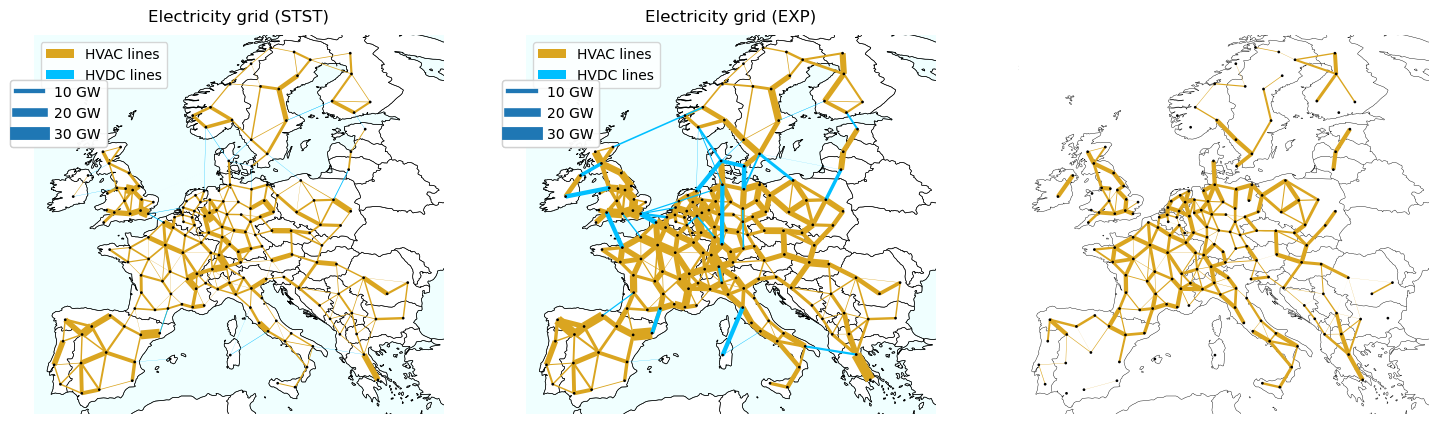

In [32]:
# plot of difference in grid

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(18, 6))

norm_lines = max(n_no.lines.s_nom_opt.max(), n_h2.lines.s_nom_opt.max(),(n_h2.lines.s_nom_opt - n_no.lines.s_nom_opt).max())
norm_links = max(n_no.links.p_nom_opt[n_no.links.carrier == "DC"].max(), n_h2.links.p_nom_opt[n_h2.links.carrier == "DC"].max(), (n_h2.links.p_nom_opt - n_no.links.p_nom_opt)[n_h2.links.carrier == "DC"].max() )
norm_both = max(norm_lines, norm_links)

scale_lines = 7
scale_links = 3.5
scale_both = 12

# STST
hvac_weights = n_no.lines.s_nom_opt / norm_both * scale_both
hvdc_weights = n_no.links.p_nom_opt.replace(0, 1) / norm_both * scale_both

m_no.plot(ax=ax1, projection=ccrs.EqualEarth(), bus_colors="black", line_colors="goldenrod", link_colors="deepskyblue", line_widths=hvac_weights, link_widths=hvdc_weights )
pypsa.plot.add_legend_patches(ax=ax1, labels=["HVAC lines", "HVDC lines"], colors=["goldenrod","deepskyblue"], legend_kw={'loc': 'upper left'})
ax1.set_title("Electricity grid (STST)", pad=10)
ax1.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
ax1.coastlines(edgecolor='black', linewidth=0.5)
ax1.set_facecolor('white')
ax1.add_feature(cartopy.feature.OCEAN, color='azure')

# add line width to legend
cap_1 = int(np.round(10000, -3) / 1e3)
lw_1 = np.round(10000, -3) / norm_both * scale_both
cap_2 = int(np.round(20000, -3) / 1e3)
lw_2 = np.round(20000, -3) / norm_both * scale_both
cap_3 = int(np.round(30000, -3) / 1e3)
lw_3 = np.round(30000, -3) / norm_both * scale_both

pypsa.plot.add_legend_lines(
    ax1,
    [lw_1, lw_2, lw_3],
    [f"{cap_1} GW", f"{cap_2} GW", f"{cap_3} GW"],
    legend_kw=dict(frameon=True, bbox_to_anchor=(0.195,0.90))
)


# EXP
hvac_weights = n_h2.lines.s_nom_opt / norm_both * scale_both
hvdc_weights = n_h2.links.p_nom_opt.replace(0, 1) / norm_both * scale_both

m_h2.plot(ax=ax2, projection=ccrs.EqualEarth(), bus_colors="black", line_colors="goldenrod", link_colors="deepskyblue", line_widths=hvac_weights, link_widths=hvdc_weights )
pypsa.plot.add_legend_patches(ax=ax2, labels=["HVAC lines", "HVDC lines"], colors=["goldenrod","deepskyblue"], legend_kw={'loc': 'upper left'})
ax2.set_title("Electricity grid (EXP)", pad=10)
ax2.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
ax2.coastlines(edgecolor='black', linewidth=0.5)
ax2.set_facecolor('white')
ax2.add_feature(cartopy.feature.OCEAN, color='azure')

# add line width to legend
cap_1 = int(np.round(10000, -3) / 1e3)
lw_1 = np.round(10000, -3) / norm_both * scale_both
cap_2 = int(np.round(20000, -3) / 1e3)
lw_2 = np.round(20000, -3) / norm_both * scale_both
cap_3 = int(np.round(30000, -3) / 1e3)
lw_3 = np.round(30000, -3) / norm_both * scale_both

pypsa.plot.add_legend_lines(
    ax2,
    [lw_1, lw_2, lw_3],
    [f"{cap_1} GW", f"{cap_2} GW", f"{cap_3} GW"],
    legend_kw=dict(frameon=True, bbox_to_anchor=(0.195,0.90))
)


# DIFF
hvac_weights = (n_h2.lines.s_nom_opt - n_no.lines.s_nom_opt) / norm_both * scale_both
hvdc_weights = (n_h2.links.p_nom_opt - n_no.links.p_nom_opt) / norm_both * scale_both

m_no.plot(ax=ax3, projection=ccrs.EqualEarth(), bus_colors="black", line_colors="goldenrod", link_colors="deepskyblue", line_widths=hvac_weights, link_widths=hvdc_weights )
pypsa.plot.add_legend_patches(ax=ax3, labels=["HVAC lines", "HVDC lines"], colors=["goldenrod","deepskyblue"], legend_kw={'loc': 'upper left'})
ax3.set_title("Electricity grid expansion (EXP - STST)", pad=10)
ax3.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
ax3.coastlines(edgecolor='black', linewidth=0.5)
ax3.set_facecolor('white')
ax3.add_feature(cartopy.feature.OCEAN, color='azure')

# add line width to legend
cap_1 = int(np.round(10000, -3) / 1e3)
lw_1 = np.round(10000, -3) / norm_both * scale_both
cap_2 = int(np.round(20000, -3) / 1e3)
lw_2 = np.round(20000, -3) / norm_both * scale_both
cap_3 = int(np.round(30000, -3) / 1e3)
lw_3 = np.round(30000, -3) / norm_both * scale_both

pypsa.plot.add_legend_lines(
    ax3,
    [lw_1, lw_2, lw_3],
    [f"{cap_1} GW", f"{cap_2} GW", f"{cap_3} GW"],
    legend_kw=dict(frameon=True, bbox_to_anchor=(0.195,0.90))
)

fig.tight_layout()
plt.show()

#fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/el_grid_exp.png")

In [33]:
n_h2.lines.s_nom_opt.sort_values()

Line
309      818.421934
3       1028.223394
166     1074.911589
272     1138.340711
288     1163.784853
           ...     
174    25861.484912
42     26981.007047
135    27419.104035
225    32493.909020
106    39075.176326
Name: s_nom_opt, Length: 323, dtype: float64

In [34]:
n_h2.lines.loc["225",:]

bus0                                     GB5 13
bus1                                      GB5 9
num_parallel                          13.246537
length                                82.202581
type                Al/St 240/40 4-bundle 380.0
s_max_pu                                    0.7
s_nom                              22493.979749
capital_cost                        3132.906702
s_nom_extendable                           True
s_nom_min                          22493.979749
s_nom_max                          32493.979749
x                                      1.526575
r                                      0.186168
b                                      0.004721
carrier                                      AC
x_pu_eff                               0.000011
r_pu_eff                               0.000001
s_nom_opt                           32493.90902
v_nom                                     380.0
g                                           0.0
s_nom_mod                               

In [35]:
hvac_weights = n_no.lines.s_nom_opt / norm_both * scale_both
hvdc_weights = n_no.links.p_nom_opt.replace(0, 1) / norm_both * scale_both

# add line width to legend
cap_mean = int(np.round(n_no.lines.s_nom_opt.mean(), -3) / 1e3)
lw_mean = np.round(n_no.lines.s_nom_opt.mean(), -3) / norm_both * scale_both
cap_max = int(np.round(n_no.lines.s_nom_opt.max(), -3) / 1e3)
lw_max = np.round(n_no.lines.s_nom_opt.max(), -3) / norm_both * scale_both

In [36]:
lw_max

11.97691332474571

In [37]:
norm_lines

39075.17632552763

In [38]:
norm_links

11999.908259856833

In [39]:
# AC lines

In [40]:
# all AC network lines are froms same type
n_no.lines.type.unique()

array(['Al/St 240/40 4-bundle 380.0'], dtype=object)

In [41]:
# lines with zero capacity
new_lines = n_no.lines[n_no.lines.s_nom_opt == 0.0].index

In [42]:
# length of HVAC
# STST: 67626.76416683497 km
# EXP: 68396.95599455902 km
n_no.lines.length[~ n_no.lines.index.isin(new_lines)].sum()
n_h2.lines.length.sum()

68396.95599455902

In [43]:
# how much more capacity do the new lines have (exclude ones with 0 in first place)
np.mean(n_h2.lines.s_nom_opt.loc[~ n_h2.lines.index.isin(new_lines)] / n_no.lines.s_nom_opt.loc[~ n_no.lines.index.isin(new_lines)])

2.3883063030537257

In [44]:
# Optimised capacity for apparent power: capacities in megavolt amperes (MVA)
n_h2.lines.s_nom_opt / n_no.lines.s_nom_opt

Line
1      4.390311
2      2.621784
3           inf
4      1.316506
5      1.019110
         ...   
319    1.000001
320    1.000000
321    2.962743
322    1.122132
323    1.000000
Name: s_nom_opt, Length: 323, dtype: float64

In [45]:
# sum of all capacities of all AC lines is almost twice as high for the second network
n_h2.lines.s_nom_opt.sum() / n_no.lines.s_nom_opt.sum()

1.936867546113058

In [46]:
# sum of product of line capacity with length
(n_no.lines.s_nom_opt*n_no.lines.length).sum() / 1e6 # 316 TW*km
(n_h2.lines.s_nom_opt*n_h2.lines.length).sum() / 1e6 # 620 TW*km

620.273486761611

In [47]:
(n_h2.lines.s_nom_opt*n_h2.lines.length).sum() / (n_no.lines.s_nom_opt*n_no.lines.length).sum()

1.9622838082425154

In [48]:
# average line capacity for AC
# STST: 5 GW; range (0.6 - 39 GW)
# EXP: 10 GW; range (0.8 - 39 GW)
(n_no.lines.s_nom_opt / 1e3).sort_values()

Line
177     0.000000
3       0.000000
56      0.000000
111     0.000000
203     0.569170
         ...    
125    19.267114
135    20.965217
219    21.609649
225    22.493980
106    39.075176
Name: s_nom_opt, Length: 323, dtype: float64

In [49]:
# DC cables

In [50]:
len(n_h2.links[n_h2.links.carrier == "DC"])

42

In [51]:
# all DC cables
n_h2.links[n_h2.links.carrier == "DC"]

bus0    bus1 carrier  \
Link                              
14547    IT0 10   GR0 1      DC   
5686      ES2 0   ES0 8      DC   
14539     ME0 0  IT0 14      DC   
12998     IT0 4   IT1 0      DC   
14562    FR0 26   ES0 7      DC   
14538     DE0 7   BE0 1      DC   
14550     GB5 9   NL0 0      DC   
14537     GB5 9   BE0 0      DC   
14563     GB5 9  FR0 19      DC   
14542     DK3 0   DK0 0      DC   
14551     DK3 0  DE0 23      DC   
14560     PL0 1   SE3 3      DC   
14540     NL0 3   DK0 0      DC   
14558     NL0 3   NO3 5      DC   
14584    DE0 15   NO3 5      DC   
5626     GB5 16   GB4 0      DC   
5625     GB5 16   GB4 0      DC   
14552     GB5 7   IE4 0      DC   
14531     SE3 6   DK0 0      DC   
14556     SE3 6   DK0 0      DC   
14553     FI3 4   EE6 0      DC   
14555     SE3 0   FI3 0      DC   
14554     SE3 0   FI3 0      DC   
T0        ES0 9  FR0 12      DC   
T1       IT0 12  FR0 13      DC   
T2       FR0 22  GB5 10      DC   
T10       DE0 8   DE0 9      DC   
T12       GB5 6  FR0 18      DC   
T13       GB5 2   DK0 0      DC   
T15      IT0 11   CH0 1      DC   
T17       NO3 2   GB5 8      DC   
T18      DE0 15  DE0 13      DC   
T19      GB5 10  FR0 22      DC   
T20       DE0 7  DE0 22      DC   
T21       GB5 9  FR0 19      DC   
T22       GB5 9  DE0 11      DC   
T23       LT6 0   SE3 3      DC   
T24       EE6 0   FI3 4      DC   
6168      PL0 6   LT6 0      DC   
5631+4    IT0 8   IT1 0      DC   
T16+1     SE3 3  DE0 23      DC   
14559+1   DK0 0   NO3 5      DC   

                                                  geometry      length  \
Link                                                                     
14547    LINESTRING(21.0892517161789 39.3174860744064,2...  540.473320   
5686     LINESTRING(2.48932993486183 39.561252379133,1....  380.149764   
14539    LINESTRING(14.0986517070226 42.4133438660838,1...  560.240709   
12998    LINESTRING(9.17009350125146 41.2967653544603,9...  484.073068   
14562    LINESTRING(2.98259070757654 42.2776059846425,2...  281.052745   
14538    LINESTRING(6.43068069229957 50.8136946409214,6...  146.469193   
14550    LINESTRING(4.04528166772434 51.9611233898246,2...  337.180553   
14537    LINESTRING(3.25699821065925 51.2773723094758,1...  250.639334   
14563    LINESTRING(1.75051314494826 50.9186901861196,1...  177.686327   
14542    LINESTRING(11.2853515176222 55.5308076825323,1...  210.474095   
14551    LINESTRING(11.9669051857726 55.421747727341,12...  287.886928   
14560    LINESTRING(16.861267 54.533833,16.274872 55.09...  431.091485   
14540    LINESTRING(6.75668661933496 53.437616158174,6....  446.457975   
14558    LINESTRING(6.83036734046461 53.4374933986115,6...  820.037608   
14584    LINESTRING(6.81690675921544 58.6338502746805,6...  760.405537   
5626     LINESTRING(-4.94702447012386 55.0727948492206,...  237.564136   
5625     LINESTRING(-4.94689333475508 55.0726735779237,...  237.564136   
14552    LINESTRING(-3.12293971810515 53.2087645354697,...  411.804587   
14531    LINESTRING(12.0227887239052 57.5613889668514,1...  345.863359   
14556    LINESTRING(10.2163282994747 57.1311139024238,1...  345.863359   
14553    LINESTRING(26.4769584465578 59.4850679251882,2...  234.579437   
14555    LINESTRING(21.3559064590049 61.0800030227353,2...  478.141559   
14554    LINESTRING(21.3557421230034 61.0800501553429,2...  478.141559   
T0         LINESTRING (-2.867 43.367, -0.408943 45.074191)  404.792920   
T1                LINESTRING (7.468 44.9898, 6.045 45.472)  218.818421   
T2       LINESTRING (-0.172042 49.083593, -1.277269 50....  328.212103   
T10      LINESTRING (11.629014 52.252137, 12.091596 48....  469.555407   
T12      LINESTRING (-3.533899 50.718412, -1.469216 49....  438.704085   
T13      LINESTRING (-0.203587 52.93979, 9.178363 55.50...  929.876791   
T15      LINESTRING (9.439781 45.668539, 9.76569 46.432...  181.608920   
T17      LINESTRING (7.16027 60.500527, -1.784066 57.50...  923.681363   
T18      LINESTRING (9.37397

In [52]:
# lines with non zero capacity
n_no.links[(n_no.links.carrier == "DC") & (n_no.links.p_nom_opt != 0)]
n_h2.links[(n_h2.links.carrier == "DC") & (n_h2.links.p_nom_opt != 0)]

bus0    bus1 carrier  \
Link                              
14547    IT0 10   GR0 1      DC   
5686      ES2 0   ES0 8      DC   
14539     ME0 0  IT0 14      DC   
12998     IT0 4   IT1 0      DC   
14562    FR0 26   ES0 7      DC   
14538     DE0 7   BE0 1      DC   
14550     GB5 9   NL0 0      DC   
14537     GB5 9   BE0 0      DC   
14563     GB5 9  FR0 19      DC   
14542     DK3 0   DK0 0      DC   
14551     DK3 0  DE0 23      DC   
14560     PL0 1   SE3 3      DC   
14540     NL0 3   DK0 0      DC   
14558     NL0 3   NO3 5      DC   
14584    DE0 15   NO3 5      DC   
5626     GB5 16   GB4 0      DC   
5625     GB5 16   GB4 0      DC   
14552     GB5 7   IE4 0      DC   
14531     SE3 6   DK0 0      DC   
14556     SE3 6   DK0 0      DC   
14553     FI3 4   EE6 0      DC   
14555     SE3 0   FI3 0      DC   
14554     SE3 0   FI3 0      DC   
T0        ES0 9  FR0 12      DC   
T1       IT0 12  FR0 13      DC   
T2       FR0 22  GB5 10      DC   
T10       DE0 8   DE0 9      DC   
T12       GB5 6  FR0 18      DC   
T13       GB5 2   DK0 0      DC   
T15      IT0 11   CH0 1      DC   
T17       NO3 2   GB5 8      DC   
T18      DE0 15  DE0 13      DC   
T19      GB5 10  FR0 22      DC   
T20       DE0 7  DE0 22      DC   
T21       GB5 9  FR0 19      DC   
T22       GB5 9  DE0 11      DC   
T23       LT6 0   SE3 3      DC   
T24       EE6 0   FI3 4      DC   
6168      PL0 6   LT6 0      DC   
5631+4    IT0 8   IT1 0      DC   
T16+1     SE3 3  DE0 23      DC   
14559+1   DK0 0   NO3 5      DC   

                                                  geometry      length  \
Link                                                                     
14547    LINESTRING(21.0892517161789 39.3174860744064,2...  540.473320   
5686     LINESTRING(2.48932993486183 39.561252379133,1....  380.149764   
14539    LINESTRING(14.0986517070226 42.4133438660838,1...  560.240709   
12998    LINESTRING(9.17009350125146 41.2967653544603,9...  484.073068   
14562    LINESTRING(2.98259070757654 42.2776059846425,2...  281.052745   
14538    LINESTRING(6.43068069229957 50.8136946409214,6...  146.469193   
14550    LINESTRING(4.04528166772434 51.9611233898246,2...  337.180553   
14537    LINESTRING(3.25699821065925 51.2773723094758,1...  250.639334   
14563    LINESTRING(1.75051314494826 50.9186901861196,1...  177.686327   
14542    LINESTRING(11.2853515176222 55.5308076825323,1...  210.474095   
14551    LINESTRING(11.9669051857726 55.421747727341,12...  287.886928   
14560    LINESTRING(16.861267 54.533833,16.274872 55.09...  431.091485   
14540    LINESTRING(6.75668661933496 53.437616158174,6....  446.457975   
14558    LINESTRING(6.83036734046461 53.4374933986115,6...  820.037608   
14584    LINESTRING(6.81690675921544 58.6338502746805,6...  760.405537   
5626     LINESTRING(-4.94702447012386 55.0727948492206,...  237.564136   
5625     LINESTRING(-4.94689333475508 55.0726735779237,...  237.564136   
14552    LINESTRING(-3.12293971810515 53.2087645354697,...  411.804587   
14531    LINESTRING(12.0227887239052 57.5613889668514,1...  345.863359   
14556    LINESTRING(10.2163282994747 57.1311139024238,1...  345.863359   
14553    LINESTRING(26.4769584465578 59.4850679251882,2...  234.579437   
14555    LINESTRING(21.3559064590049 61.0800030227353,2...  478.141559   
14554    LINESTRING(21.3557421230034 61.0800501553429,2...  478.141559   
T0         LINESTRING (-2.867 43.367, -0.408943 45.074191)  404.792920   
T1                LINESTRING (7.468 44.9898, 6.045 45.472)  218.818421   
T2       LINESTRING (-0.172042 49.083593, -1.277269 50....  328.212103   
T10      LINESTRING (11.629014 52.252137, 12.091596 48....  469.555407   
T12      LINESTRING (-3.533899 50.718412, -1.469216 49....  438.704085   
T13      LINESTRING (-0.203587 52.93979, 9.178363 55.50...  929.876791   
T15      LINESTRING (9.439781 45.668539, 9.76569 46.432...  181.608920   
T17      LINESTRING (7.16027 60.500527, -1.784066 57.50...  923.681363   
T18      LINESTRING (9.37397

In [53]:
# network length
n_no.links.length[(n_no.links.carrier == "DC") & (n_no.links.p_nom_opt != 0)].sum()
n_h2.links.length[(n_h2.links.carrier == "DC") & (n_h2.links.p_nom_opt != 0)].sum()

17893.88200995407

In [54]:
# average capacity
# n_no.links[(n_no.links.carrier == "DC") & (n_no.links.p_nom_opt != 0)].p_nom_opt.mean() / 1e3
n_h2.links[(n_h2.links.carrier == "DC") & (n_h2.links.p_nom_opt != 0)].p_nom_opt.mean() / 1e3

4.389164255988979

In [55]:
# capacity range
#((n_no.links[(n_no.links.carrier == "DC") & (n_no.links.p_nom_opt != 0)].p_nom_opt) / 1e3).sort_values()
(n_h2.links[(n_h2.links.carrier == "DC") & (n_h2.links.p_nom_opt != 0)].p_nom_opt / 1e3).sort_values()

Link
14539       0.000177
T13         0.000236
T2          0.003045
T1          0.004048
T23         0.249142
14531       0.250002
5626        0.250008
5686        0.477169
14554       0.500000
14553       0.650000
14558       0.700003
14555       0.800001
12998       1.000001
14556       1.050813
14584       2.189562
14550       2.846446
T22         2.848785
T0          2.880271
T19         3.210550
T21         3.376857
T17         3.748110
T10         3.753595
14538       3.830852
T20         4.053229
T16+1       4.392082
T24         4.586333
14547       5.145515
14559+1     5.429919
T15         5.714108
14537       5.958345
14560       7.041023
6168        8.070747
5625        8.117519
14542       9.112239
14562       9.218698
T12         9.999685
14540       9.999921
T18         9.999977
5631+4     10.121232
14552      10.164882
14551      10.599862
14563      11.999908
Name: p_nom_opt, dtype: float64

In [56]:
# average line capacity for DC
# STST: 0.78 GW; range (0.25 - 2 GW)
# EXP: 4.3 GW; range (0.00 - 11 GW)

In [57]:
# sum of product of line capacity with length
sum_prod1 = (n_no.links[(n_no.links.carrier == "DC") & (n_no.links.p_nom_opt != 0)].p_nom_opt * n_no.links[(n_no.links.carrier == "DC") & (n_no.links.p_nom_opt != 0)].length).sum()
sum_prod2 = (n_h2.links[(n_h2.links.carrier == "DC") & (n_h2.links.p_nom_opt != 0)].p_nom_opt * n_no.links[(n_h2.links.carrier == "DC") & (n_h2.links.p_nom_opt != 0)].length).sum()
sum_prod2 / sum_prod1
sum_prod2

72056761.94897407

In [58]:
# global constraint: transmission_volume_expansion_limit is binding
n_no.global_constraints.loc["lv_limit", "constant"] / 1e6

322.2255562546979

In [59]:
# global constraint: transmission_volume_expansion_limit is binding
n_no.global_constraints.loc["lv_limit", "constant"]
AC =  (n_no.lines.s_nom_opt*n_no.lines.length).sum()
DC = sum_prod1
AC + DC - n_no.global_constraints.loc["lv_limit", "constant"]

0.0

Findings:
- electricity network has the same lines in both scenarios, difference is in the capacity
- the lines (AC, DC) also have the same length
- The capacity of the AC lines are twice as high in the h2 case
- The capacity of the DC lines are 11 times higher than in the no case

## Installed Capacity, Generation, Consumption

In [60]:
cap_no = pd.DataFrame(index=n_no.buses.location.unique())
cap_h2 = pd.DataFrame(index=n_h2.buses.location.unique())

for n, df in zip([n_no, n_h2], [cap_no,cap_h2]):

    for c in n.generators.carrier.unique():
        # capacity in GW
        df[c] = capacity(n, c) / 1000

    for c in n.links.carrier.unique():
        # capacity in GW
        df[c] = capacity_links(n, c) / 1000

    for c in n.storage_units.carrier.unique():
        # capacity in GW
        df[c] = capacity_storage_units(n, c) / 1000

# condense groups
cap_no = get_condense_sum(cap_no, c1_groups, c1_groups_name)
cap_h2 = get_condense_sum(cap_h2, c1_groups, c1_groups_name)
# rename unhandy column names
cap_no.rename(columns=carrier_renaming, inplace=True)
cap_h2.rename(columns=carrier_renaming, inplace=True)

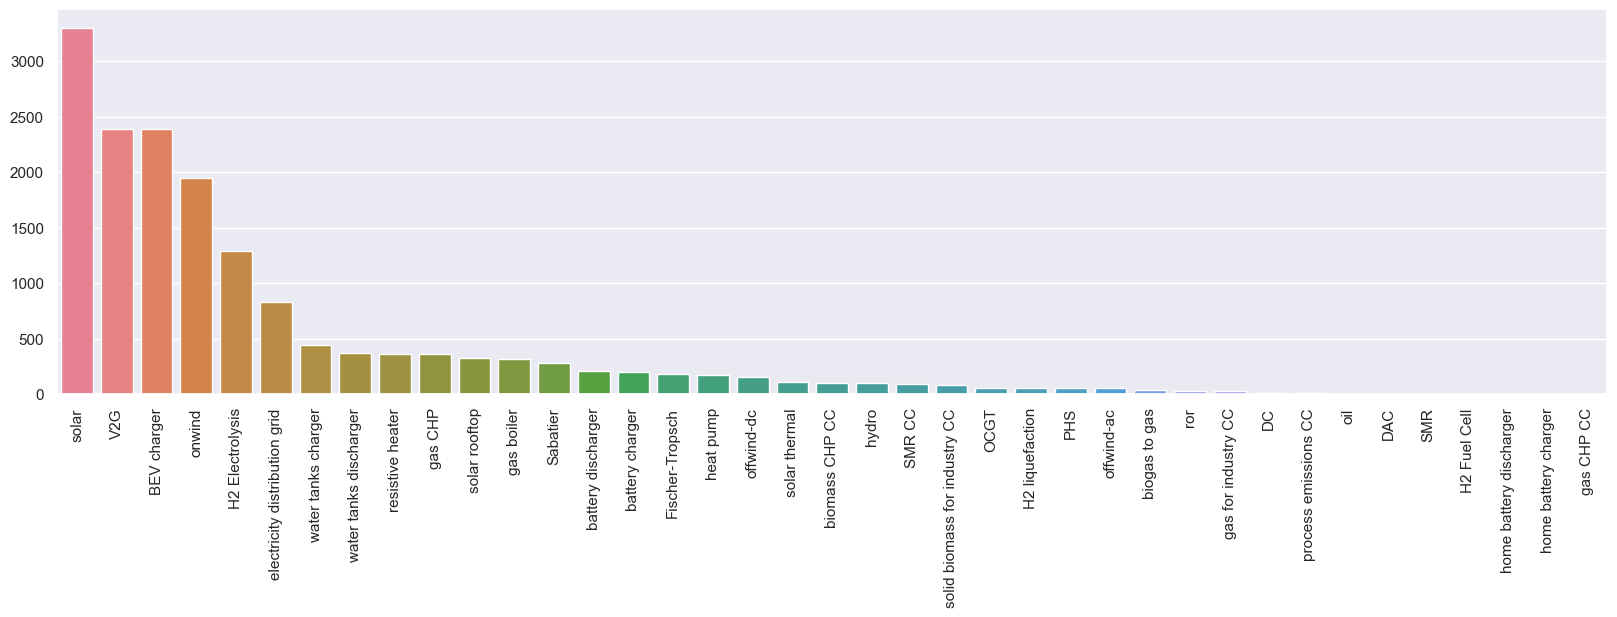

In [61]:
cap_no_sum = pd.DataFrame(cap_no.sum().sort_values(ascending=False)).transpose()
sns.set(rc={'figure.figsize': (20, 5)})
sns.barplot(data=cap_no_sum.iloc[: , 1:40])
ticks = plt.xticks(rotation=90)
plt.show()

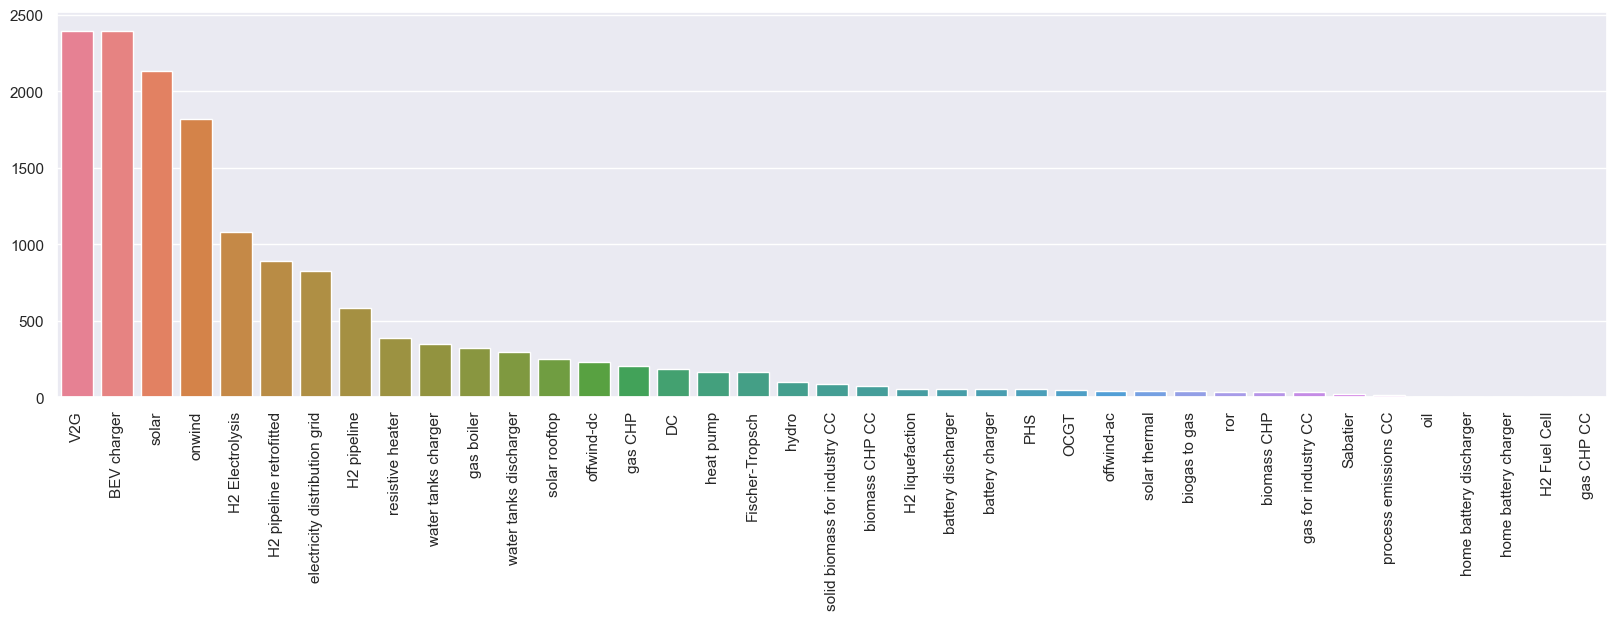

In [62]:
cap_h2_sum = pd.DataFrame(cap_h2.sum().sort_values(ascending=False)).transpose()
sns.set(rc={'figure.figsize': (20, 5)})
sns.barplot(data=cap_h2_sum.iloc[: , 1:40])
ticks = plt.xticks(rotation=90)
plt.show()

In [63]:
# thesis_plot
# capacity of important technologies

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(12, 6))
bbox = (0.5, 1.25)

carriers = ["solar" , "solar rooftop"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax0, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax0.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["onwind", "offwind-dc", "offwind-ac"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax1, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax1.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["H2 Electrolysis", "SMR", "SMR CC"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax2, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax2.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["Fischer-Tropsch", "Sabatier", "H2 liquefaction"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax3, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax3.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["battery charger", "battery discharger"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax4, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax4.legend(loc='upper center', bbox_to_anchor=bbox)

fig.tight_layout()
plt.close()
plt.show()

# fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/capa_scenarios.png")

In [64]:
carriers = ["hydro"]
get_df(cap_no_sum, cap_h2_sum, carriers)

hydro
STST  99.562201
EXP   99.562201

In [65]:
# magnitude is in GW
carriers = ["battery charger", "battery discharger"]
round(get_df(cap_no_sum, cap_h2_sum, carriers), 0).transpose() / round(get_df(cap_no_sum, cap_h2_sum, carriers), 0).transpose().sum()
# round(get_df(cap_no_sum, cap_h2_sum, carriers), 0).sum(axis=1)

STST       EXP
battery charger     0.493976  0.495575
battery discharger  0.506024  0.504425

In [66]:
# magnitude is in GW
carriers = ["H2 Fuel Cell"]
round(get_df(cap_no_sum, cap_h2_sum, carriers), 0).transpose()
# round(get_df(cap_no_sum, cap_h2_sum, carriers), 0).sum(axis=1)

STST  EXP
H2 Fuel Cell   1.0  0.0


Notes:
- 'H2 pipeline', 'H2 pipeline retrofitted' are the only difference in the carriers (n_no does not have them)
- H2 Fuel Cell Capacity is not really existent: capacity without H2 network is 1 GW and with H2 network it is 0


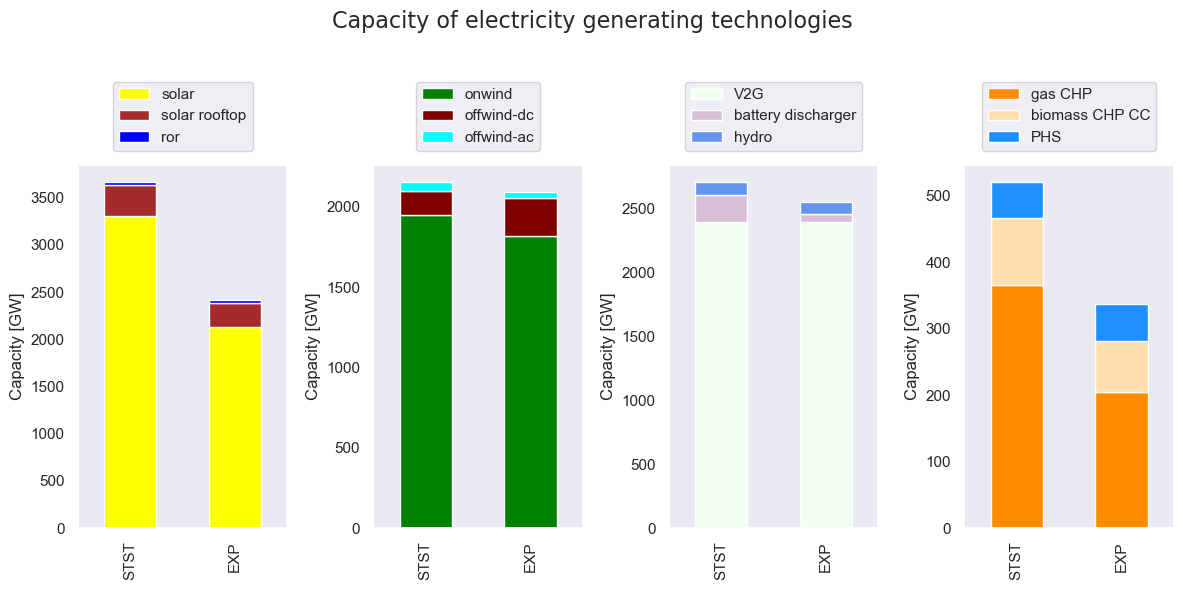

In [67]:
# capacity of electricity generating technologies

c_el_gen_s, c_el_con_s

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(12, 6))
bbox = (0.5, 1.25)

carriers = ["solar" , "solar rooftop", "ror"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax0, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax0.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["onwind", "offwind-dc", "offwind-ac"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax1, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax1.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["V2G", "battery discharger", "hydro"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax2, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax2.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["gas CHP", "biomass CHP CC", "PHS"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax3, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax3.legend(loc='upper center', bbox_to_anchor=bbox)

fig.suptitle("Capacity of electricity generating technologies", fontsize=16,  **font1)
fig.tight_layout()
plt.show()

#fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/el_gen_capa_scenarios.png")

In [68]:
# new calculated cap
cap_stst_sum_gen = pd.DataFrame(df_stst_ons[df_stst_ons.columns[df_stst_ons.columns.str.contains("cap_gen_el")]].sum()).transpose()
cap_exp_sum_gen = pd.DataFrame(df_exp_ons[df_exp_ons.columns[df_exp_ons.columns.str.contains("cap_gen_el")]].sum()).transpose()

cap_stst_sum_con = pd.DataFrame(df_stst_ons[df_stst_ons.columns[df_stst_ons.columns.str.contains("cap_con_el")]].sum()).transpose()
cap_exp_sum_con = pd.DataFrame(df_exp_ons[df_exp_ons.columns[df_exp_ons.columns.str.contains("cap_con_el")]].sum()).transpose()

# prepare condesing
c1_groups_cap_gen_el = []
c1_groups_name_cap_gen_el = []
c1_groups_cap_con_el = []
c1_groups_name_cap_con_el = []

for group, name in zip(c1_groups, c1_groups_name):
    group_gen = [c + "_cap_gen_el" for c in group]
    name_gen = name + "_cap_gen_el"
    c1_groups_cap_gen_el.append(group_gen)
    c1_groups_name_cap_gen_el.append(name_gen)
    group_con = [c + "_cap_con_el" for c in group]
    name_con = name + "_cap_con_el"
    c1_groups_cap_con_el.append(group_con)
    c1_groups_name_cap_con_el.append(name_con)

# condense groups
cap_stst_sum_gen = get_condense_sum(cap_stst_sum_gen, c1_groups_cap_gen_el, c1_groups_name_cap_gen_el)
cap_exp_sum_gen = get_condense_sum(cap_exp_sum_gen, c1_groups_cap_gen_el, c1_groups_name_cap_gen_el)
cap_stst_sum_con = get_condense_sum(cap_stst_sum_con, c1_groups_cap_con_el, c1_groups_name_cap_con_el)
cap_exp_sum_con = get_condense_sum(cap_exp_sum_con, c1_groups_cap_con_el, c1_groups_name_cap_con_el)

# rename unhandy column names
cap_stst_sum_gen.rename(columns=carrier_renaming, inplace=True)
cap_exp_sum_gen.rename(columns=carrier_renaming, inplace=True)
cap_stst_sum_con.rename(columns=carrier_renaming, inplace=True)
cap_exp_sum_con.rename(columns=carrier_renaming, inplace=True)

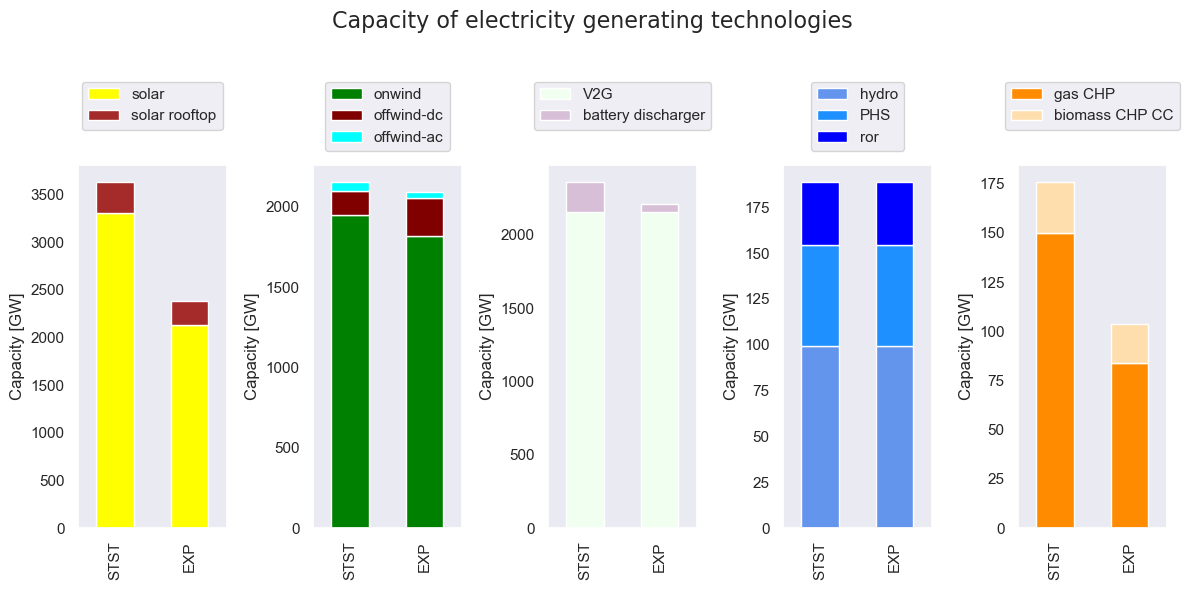

In [69]:
# capacity of electricity generating technologies

c_el_gen_s, c_el_con_s

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(12, 6))
bbox = (0.5, 1.25)

carriers = ["solar" , "solar rooftop"]
labels = [c + "_cap_gen_el" for c in carriers]
get_df(cap_stst_sum_gen, cap_exp_sum_gen, labels).plot(ax = ax0, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax0.legend(labels = carriers, loc='upper center', bbox_to_anchor=bbox)

carriers = ["onwind", "offwind-dc", "offwind-ac"]
labels = [c + "_cap_gen_el" for c in carriers]
get_df(cap_stst_sum_gen, cap_exp_sum_gen, labels).plot(ax = ax1, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax1.legend(labels = carriers, loc='upper center', bbox_to_anchor=bbox)

carriers = ["V2G", "battery discharger"]
labels = [c + "_cap_gen_el" for c in carriers]
get_df(cap_stst_sum_gen, cap_exp_sum_gen, labels).plot(ax = ax2, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax2.legend(labels = carriers, loc='upper center', bbox_to_anchor=bbox)

carriers = ["hydro", "PHS", "ror"]
labels = [c + "_cap_gen_el" for c in carriers]
get_df(cap_stst_sum_gen, cap_exp_sum_gen, labels).plot(ax = ax3, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax3.legend(labels = [carrier_renaming.get(n, n) for n in carriers], loc='upper center', bbox_to_anchor=bbox)

carriers = ["urban central gas CHP", "urban central solid biomass CHP CC"]
labels = [c + "_cap_gen_el" for c in carriers]
get_df(cap_stst_sum_gen, cap_exp_sum_gen, labels).plot(ax = ax4, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax4.legend(labels = [carrier_renaming.get(n, n) for n in carriers], loc='upper center', bbox_to_anchor=bbox)

fig.suptitle("Capacity of electricity generating technologies", fontsize=16,  **font1)
fig.tight_layout()
plt.show()

#fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/el_gen_capa_scenarios.png")

In [70]:
# Further investigation
carriers = ["hydro"]
labels = [c + "_cap_gen_el" for c in carriers]
get_df(cap_stst_sum_gen, cap_exp_sum_gen, labels)

hydro_cap_gen_el
STST         99.562201
EXP          99.562201

|technology   |STST   |EXP   |
|---|---|---|
|'onwind'   |1945   |1819   |   
|'solar'   | 3302  | 2131  |  
| 'offwind-dc'  |153   | 232  |  
|  'hydro' | 100  |100  |   
| 'solar rooftop'  | 329  | 249  |  
| 'battery discharger'  | 205  | 56  |  
| 'offwind-ac'  | 54  | 42  |   
| 'ror'  | 35  | 35  |  
|  'urban central gas CHP' | 150  | 84  |  
|  'urban central solid biomass CHP CC' | 26  | 20  |   
|   'V2G'| 2154  | 2154  |  
| 'PHS'  | 55  | 55  |  

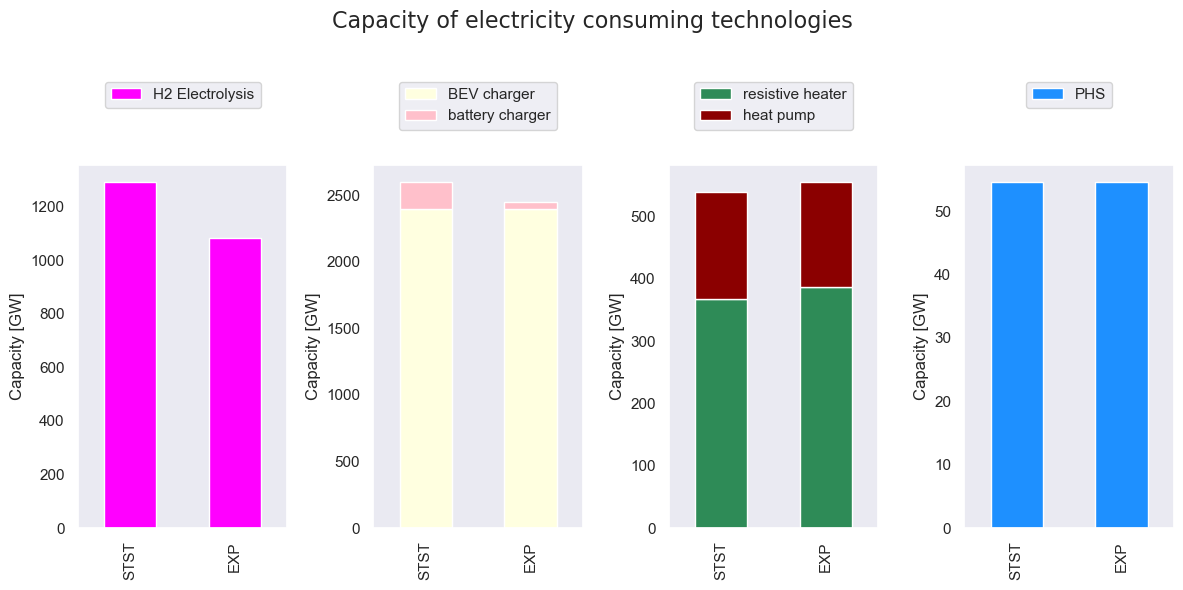

In [71]:
# capacity of electricity consuming technologies

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(12, 6))
bbox = (0.5, 1.25)

carriers = ["H2 Electrolysis"]
labels = [c + "_cap_con_el" for c in carriers]
get_df(cap_stst_sum_con, cap_exp_sum_con, labels).plot(ax = ax0, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax0.legend(labels = [carrier_renaming.get(n, n) for n in carriers], loc='upper center', bbox_to_anchor=bbox)

carriers = ["BEV charger", "battery charger"]
labels = [c + "_cap_con_el" for c in carriers]
get_df(cap_stst_sum_con, cap_exp_sum_con, labels).plot(ax = ax1, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax1.legend(labels = [carrier_renaming.get(n, n) for n in carriers], loc='upper center', bbox_to_anchor=bbox)

carriers = ["resistive heater", "heat pump"]
labels = [c + "_cap_con_el" for c in carriers]
get_df(cap_stst_sum_con, cap_exp_sum_con, labels).plot(ax = ax2, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax2.legend(labels = [carrier_renaming.get(n, n) for n in carriers], loc='upper center', bbox_to_anchor=bbox)

carriers = ["PHS"]
labels = [c + "_cap_con_el" for c in carriers]
get_df(cap_stst_sum_con, cap_exp_sum_con, labels).plot(ax = ax3, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax3.legend(labels = [carrier_renaming.get(n, n) for n in carriers], loc='upper center', bbox_to_anchor=bbox)

fig.suptitle("Capacity of electricity consuming technologies", fontsize=16,  **font1)
fig.tight_layout()
plt.show()

#fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/el_con_capa_scenarios.png")

In [72]:
n_no.links[n_no.links.carrier == "battery charger"].efficiency

Link
AL0 0 battery charger    0.979796
AT0 0 battery charger    0.979796
AT0 1 battery charger    0.979796
AT0 2 battery charger    0.979796
BA0 0 battery charger    0.979796
                           ...   
SE3 5 battery charger    0.979796
SE3 6 battery charger    0.979796
SE3 7 battery charger    0.979796
SI0 0 battery charger    0.979796
SK0 0 battery charger    0.979796
Name: efficiency, Length: 181, dtype: float64

In [73]:
carriers = ["PHS"]
labels = [c + "_cap_gen_el" for c in carriers]
get_df(cap_stst_sum_gen, cap_exp_sum_gen, labels)

PHS_cap_gen_el
STST       54.593581
EXP        54.593581

In [74]:
carriers = ["PHS"]
labels = [c + "_cap_con_el" for c in carriers]
get_df(cap_stst_sum_con, cap_exp_sum_con, labels)

PHS_cap_con_el
STST       54.593581
EXP        54.593581

|technology   |STST   |EXP   |
|---|---|---|
|'H2 Electrolysis'   |1291   |1083   |   
|'BEV charger'   | 2394  | 2394  |  
|'battery charger'  |205   | 56  |  
|  'heat pump' | 171  | 169  |   
| 'resistive heater'  | 367  | 387  |  
| 'PHS'  |47  | 47  |  

In [75]:
# capacity of peak power plants

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(12, 6))
bbox = (0.5, 1.25)

carriers = ["gas CHP CC", "gas CHP"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax0, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax0.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["hydro", "PHS"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax1, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax1.legend(loc='upper center', bbox_to_anchor=bbox)


carriers = ["biomass CHP CC" , "biomass CHP"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax2, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax2.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["OCGT"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax3, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax3.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["V2G"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax4, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax4.legend(loc='upper center', bbox_to_anchor=bbox)

fig.tight_layout()
plt.close()
plt.show()

# fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/capa_peak_scenarios.png")

#### Generation

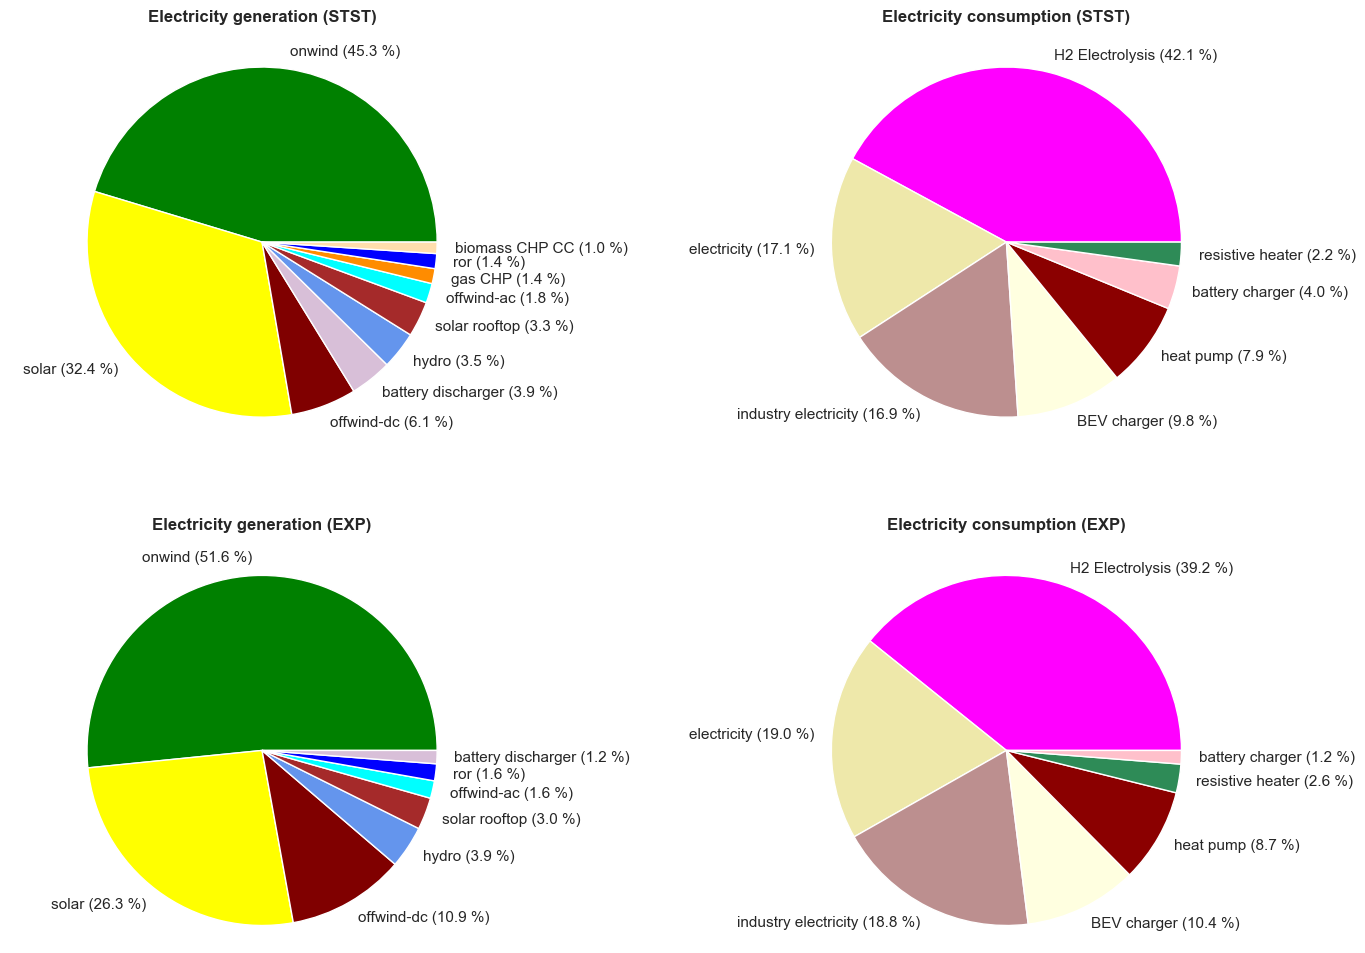

In [76]:
# thesis_plot:

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

for n in [n_no, n_h2]:

    carrier = ["AC", "low voltage"]
    nb = nodal_balance(n, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
    # convert from MWh to GWh
    nb = nb.unstack(level=[1]) / 1000
    # condense condense_groups
    nb = get_condense_sum(nb, c1_groups, c1_groups_name)
    # rename unhandy column names
    nb.rename(columns=carrier_renaming, inplace=True)

    nb_pos = nb[nb > 0].sum().sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_pos = nb_pos[(nb_pos / nb_pos.sum()) > 0.01]

    nb_neg = abs(nb[nb < 0].sum()).sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_neg = nb_neg[(nb_neg / nb_neg.sum()) > 0.01]

    if n==n_no:
        ax_gen=axs[0, 0]
        ax_con=axs[0, 1]
        title_gen=f"Electricity generation (STST)"
        title_con=f"Electricity consumption (STST)"

    elif n==n_h2:
        ax_gen=axs[1, 0]
        ax_con=axs[1, 1]
        title_gen=f"Electricity generation (EXP)"
        title_con=f"Electricity consumption (EXP)"

    # generation
    c = [carrier_colors[col] for col in nb_pos.index]
    percents = nb_pos.to_numpy() * 100 / nb_pos.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_pos.index, percents)]

    patches, texts = ax_gen.pie(nb_pos, colors=c, startangle=0, labels=labels)
    ax_gen.axis('equal')
    ax_gen.set_title(title_gen, pad=20, fontweight="bold")

    # consumption
    c = [carrier_colors[col] for col in nb_neg.index]
    percents = nb_neg.to_numpy() * 100 / nb_neg.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_neg.index, percents)]

    patches, texts = ax_con.pie(nb_neg, colors=c, startangle=0, labels=labels)
    ax_con.axis('equal')

    ax_con.set_title(title_con, pad=20, fontweight="bold")

fig.tight_layout(pad=5)
plt.show()

# fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/gen_con_ac_lowvoltage.png")

In [77]:
nb[nb > 0].sum().sort_values(ascending=False) / nb[nb > 0].sum().sort_values(ascending=False).sum()

carrier
onwind                     5.009985e-01
solar                      2.550983e-01
offwind-dc                 1.056276e-01
hydro                      3.796203e-02
solar rooftop              2.870071e-02
offwind-ac                 1.571693e-02
ror                        1.519589e-02
battery discharger         1.183410e-02
biomass CHP CC             8.835447e-03
V2G                        7.038491e-03
gas CHP                    5.167822e-03
PHS                        4.546736e-03
biomass CHP                2.954125e-03
OCGT                       3.224470e-04
home battery discharger    8.476906e-07
DC                         3.265006e-09
AC                         6.202144e-11
BEV charger                0.000000e+00
industry electricity       0.000000e+00
home battery charger       0.000000e+00
electricity                0.000000e+00
battery charger            0.000000e+00
agriculture electricity    0.000000e+00
H2 Electrolysis            0.000000e+00
resistive heater           0.000

In [78]:
carriers_el_gen_stst = [
    "onwind",
    "solar",
    "BEV charger",
    "offwind-dc",
    "ror",
    "hydro",
    "solar rooftop",
    "offwind-ac",
    "battery charger",
    "battery discharger",
    "biomass CHP CC",
    "V2G",
    "PHS",
    "gas CHP",
    "OCGT",
    "home battery charger",
    "home battery discharger",
    "H2 Fuel Cell",
    "gas CHP CC",
    "DAC"
]

carriers_el_gen_exp = [
    "onwind",
    "solar",
    "BEV charger",
    "offwind-dc",
    "ror",
    "hydro",
    "solar rooftop",
    "offwind-ac",
    "battery charger",
    "battery discharger",
    "biomass CHP CC",
    "biomass CHP",
    "V2G",
    "PHS",
    "gas CHP",
    "OCGT",
    "home battery charger",
    "home battery discharger",
]

In [79]:
# overall electricity generation in TWh

model = "EXP"

if model == "STST":
    n = n_no
    index = carriers_el_gen_stst

elif model == "EXP":
    n = n_h2
    index = carriers_el_gen_exp

carrier = ["AC", "low voltage"]
nb = nodal_balance(n, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
# convert from MWh to GWh
nb = nb.unstack(level=[1]) / 1000
# condense condense_groups
nb = get_condense_sum(nb, c1_groups, c1_groups_name)
# rename unhandy column names
nb.rename(columns=carrier_renaming, inplace=True)
# calc sum and convert to TWh
nb[nb > 0].sum()[index].sum() / 1e3

# STST: 10202
# EXP: 9172

9172.224887897673

In [80]:
# overall generation and share of all wind and solar technologies:
# wind:  STST: 5347 TWh, 52 % ; EXP: 5708 TWh, 62 %
# solar: STST: 3584 TWh, 35 %; EXP: 2603 TWh, 28 %
# Together: STST: 8931 TWh, 88 % ; EXP: 8311 TWh, 91 \%
# (nb[nb > 0].sum()[["solar", "solar rooftop"]].sum() / 1000 ) / (nb[nb > 0].sum().sum() / 1000)
(nb[nb > 0].sum()[["onwind", "offwind-ac", "offwind-dc", "solar", "solar rooftop"]].sum() / 1000 ) #/ (nb[nb > 0].sum().sum() / 1000)


8311.338773259062

In [81]:
# overall electricity consumption in TWh

carrier = ["AC", "low voltage"]
nb = nodal_balance(n_no, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
# convert from MWh to GWh
nb = nb.unstack(level=[1]) / 1000
# condense condense_groups
nb = get_condense_sum(nb, c1_groups, c1_groups_name)
# rename unhandy column names
nb.rename(columns=carrier_renaming, inplace=True)
# calc sum and convert to TWh
nb[nb < 0].sum().sum() / 1000

# STST: -10202
# EXP: -9172

-10202.074411189566

In [82]:
# Direct Air Capture consumes 12 TWh in total? (STST)
nb[nb < 0].sum()["DAC"] / 1e3

-12.91278952837588

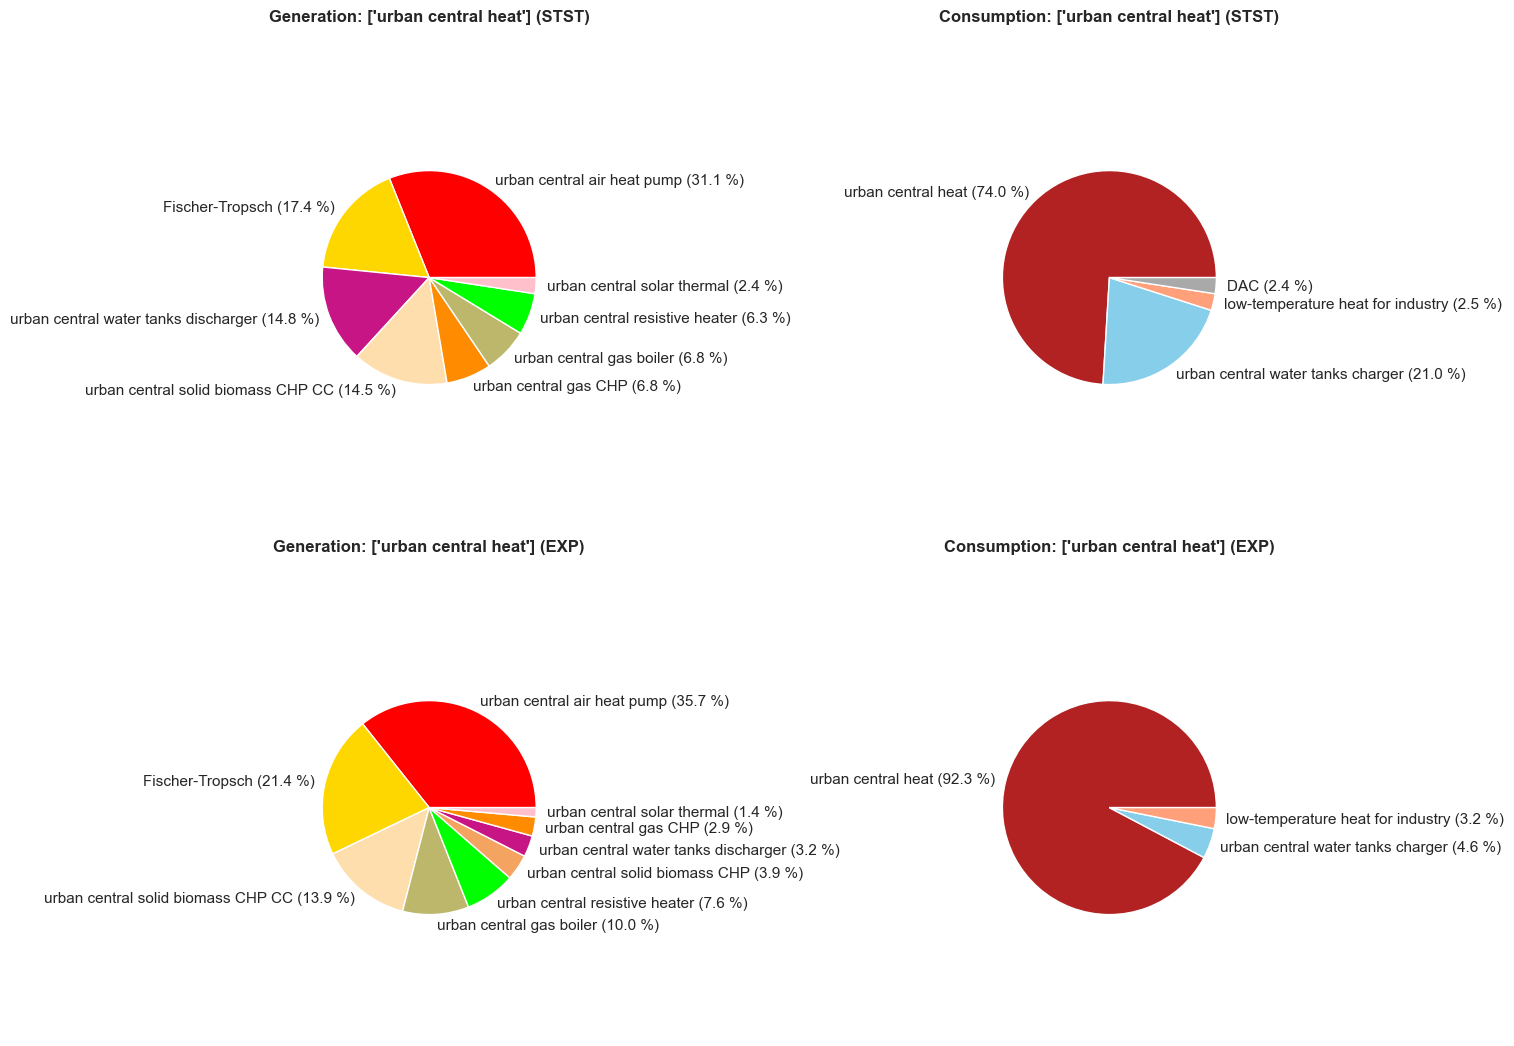

In [83]:
# generation and consumption (heat)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

for n in [n_no, n_h2]:

    carrier = ["urban central heat"]
    nb = nodal_balance(n, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
    # convert from MW to GW
    nb = nb.unstack(level=[1]) / 1000

    nb_pos = nb.sum()[nb.sum() > 0].sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_pos = nb_pos[(nb_pos / nb_pos.sum()) > 0.01]

    nb_neg = abs(nb.sum()[nb.sum() < 0]).sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_neg = nb_neg[(nb_neg / nb_neg.sum()) > 0.01]

    if n==n_no:
        ax_gen=axs[0, 0]
        ax_con=axs[0, 1]
        title_gen=f"Generation: {carrier} (STST)"
        title_con=f"Consumption: {carrier} (STST)"

    elif n==n_h2:
        ax_gen=axs[1, 0]
        ax_con=axs[1, 1]
        title_gen=f"Generation: {carrier} (EXP)"
        title_con=f"Consumption: {carrier} (EXP)"

    # generation
    c = [carrier_colors[col] for col in nb_pos.index]
    percents = nb_pos.to_numpy() * 100 / nb_pos.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_pos.index, percents)]

    patches, texts = ax_gen.pie(nb_pos, colors=c, startangle=0, labels=labels)
    ax_gen.axis('equal')
    ax_gen.set_title(title_gen, pad=20, fontweight="bold")

    # consumption
    c = [carrier_colors[col] for col in nb_neg.index]
    percents = nb_neg.to_numpy() * 100 / nb_neg.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_neg.index, percents)]

    patches, texts = ax_con.pie(nb_neg, colors=c, startangle=0, labels=labels)
    ax_con.axis('equal')

    ax_con.set_title(title_con, pad=20, fontweight="bold")

fig.tight_layout(pad=2)
#plt.close()
plt.show()

# Fischer Tropsch nebenprdukt Heat

#### Correlation of Capacity

In [84]:
cap_no.corr()["PHS"].sort_values(ascending=False)

PHS                              1.000000
ror                              0.629082
solar thermal                    0.336570
offwind-dc                       0.278613
hydro                            0.176980
solar                            0.167541
biomass CHP                      0.129354
battery charger                  0.096225
battery discharger               0.096225
solar rooftop                    0.080765
SMR CC                           0.033100
biomass CHP CC                   0.022897
V2G                             -0.049420
BEV charger                     -0.049420
gas CHP CC                      -0.056248
H2 liquefaction                 -0.057451
water tanks charger             -0.058320
H2 Electrolysis                 -0.062228
water tanks discharger          -0.124939
onwind                          -0.138759
SMR                             -0.156337
gas boiler                      -0.163852
OCGT                            -0.167675
DC                              -0

In [85]:
cap_h2.corr()["H2 pipeline retrofitted"].sort_values(ascending=False)

H2 pipeline retrofitted          1.000000
gas CHP                          0.165576
offwind-dc                       0.137909
heat pump                        0.090337
gas CHP CC                       0.082084
electricity distribution grid    0.081157
gas boiler                       0.067722
resistive heater                 0.050328
onwind                           0.044667
H2 Fuel Cell                     0.044022
BEV charger                      0.041010
V2G                              0.041010
H2 Electrolysis                  0.040551
battery discharger               0.030149
battery charger                  0.030149
H2 pipeline                      0.014772
SMR                             -0.002298
H2 liquefaction                 -0.003621
offwind-ac                      -0.008828
water tanks discharger          -0.036245
OCGT                            -0.036723
water tanks charger             -0.042427
biomass CHP                     -0.062418
solar thermal                   -0

In [86]:
# check correlation of capacities to check at which locations similar technologies are present
fig = plt.figure(figsize=(28, 14))
sns.heatmap(cap_no.corr()[(abs(cap_no.corr()) > 0.1) & (abs(cap_no.corr()) < 0.8)], annot=True)
plt.close()
plt.show()
# fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/no_h2_capa_corr.png")

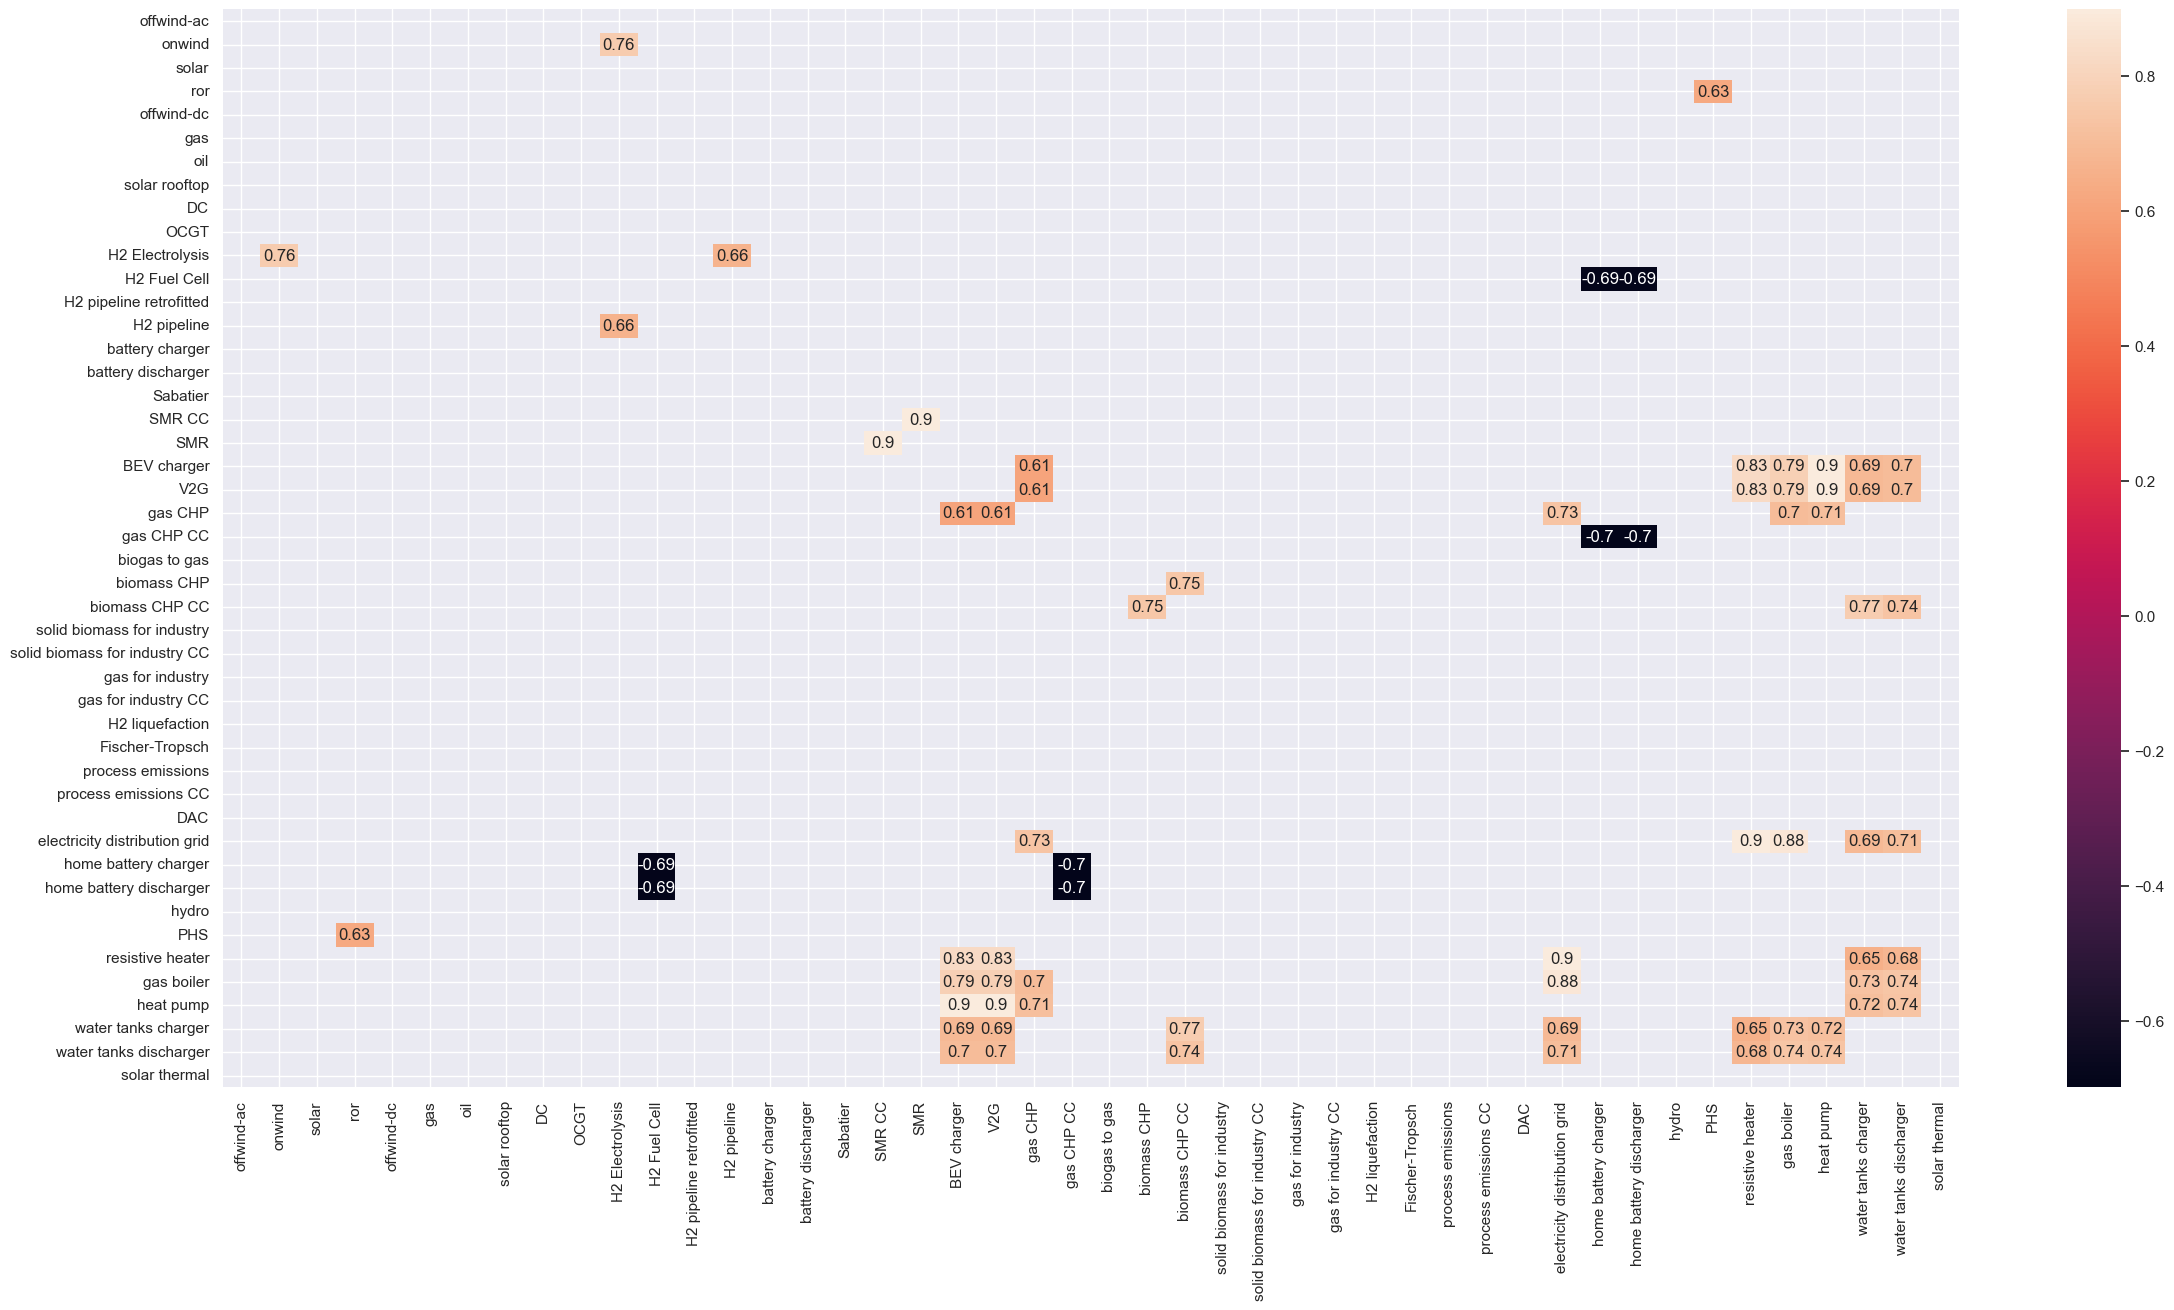

In [87]:
# check correlation of capacities to check at which location similar technologies are present
fig = plt.figure(figsize=(28, 14))
sns.heatmap(cap_h2.corr()[(abs(cap_h2.corr()) > 0.6) & (abs(cap_h2.corr()) < 0.9)], annot=True)
plt.show()
# fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/h2_capa_corr.png")

In [88]:
fig = plt.figure(figsize=(28, 14))
diff_cap = cap_no.corr() - cap_h2.corr()
sns.heatmap(diff_cap[(abs(diff_cap) > 0.4) & (abs(diff_cap) < 0.5)], annot=True)
plt.close()
plt.show()
# fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/capa_corr_diff_no_minus_h2.png")

Findings: correlation of capacities amogn the scenarios

Interesting and making sense:
- H2 Electrolysis and onwind: (no: 0.67; h2: 0.76) -> onshore wind dominantly used for hydrogen production
- H2 Electrolysis and solar: (no: 0.32; h2: 0.37) -> solar wind partly used for hydrogen production
- H2 Electrolysis and H2 pipeline: 0.66 -> hydrogen production at locations with pipelines
- onwind and h2 pipeline. 0.57 -> onwind used for hydrogen production close to h2 pipelines; pipelines are build where a lot of onwind is located
- offwind-dc and H2 liquefaction: 0.61 ; 0.35 -> offshore wind used to produced liquefied hydrogen (more present in STST scenario as there is less possibility to transport away the offshore wind power generation)

- solar and battery charger: (no: 0.59; h2: 0.54) -> solar used for utility scale battery charging
- BEV and solar rooftop: (STST: 0.63 ; EXP: 0.56) -> solar used to charge vehicles
- BEV and solar: (STST: 0.53 ; EXP: 0.22) -> solar used to charge vehicles

- gas CHP and heat pump / gas boilder / resistive heater : (no: 0.83, 0.72, 0.72 ; h2: 0.71 , 0.7, 0.58) -> all heat sources are at the same location
- gas CHP and biomass CHP / biomas CHP CC: 0.67 / 0.67 ; 0.44 / 0.3 -> all heat sources are at the same location
- gas CHP and water tanks charger: 0.66 ; 0.53 -> heat used for charging thermal storage
- water tanks charger and heat pump / gas boiler / resisitive heater: 0.68 / 0.65 / 0.67 ; 0.73/ 0.72 / 0.65 -> heat used for charging thermal storage

Not making sense or not interesting?:
- biomas CHP and water tanks charger / discharger; (no: 0.007/ 0.048 ; h2: 0.59, 0.55) -> Why no correlation in STST case?
- biomass CHP and home battery charger: -0.52 ; -0.23
- gas CHP CC and home battery charger: -0.65 ; -0.7
- H2 Electrolysis and water tanks charger / water tanks discharger: ( no: 0.39 / 0.44 ; -0.12 / < abs(0.1)) -> rather random?

Not interesting and making sense:
- solar and solar rooftop (0.5 ; 0.47)
- solar thermal and solar: 0.56 ; 0.41

Not interesting and not making sense:
- H2 Fuel cell and home battery charger / home battery discharger: (no: -0.032; h2: -0.69) not very relevant as there is almost no capacity of fuel cell
- SMR CC and H2 liquefaction: (no: 0.72; h2: -0.16) strong correlation with SMR CC and H2 liquefaction in STST scenario; small correlation in EXP scenario random due to little capacity of SMR CC
- H2 Fuel Cell and biomass CHP / biomass CHP CC: (no: 0.032 / <0.01 ; ) H2 Fuel Cell has no relevance

#### Capacity Coverage (%)
- calc capacities in percentage
- calc the min(capA, capB) for every location to see how many percentage points are present at a location from both technologies. If it is 100, the distributio of capacity is the same, if it is 0, there is no capacity present of technology A at the same location where capacity of technology B is present.
- measure the similarity of the distribution
how to calc that?

In [89]:
# Note: gas, oil, sabatier, biogas to gas, ... only have capacity at EU bus

cap_no_perc = pd.DataFrame(cap_no.fillna(0) / cap_no.fillna(0).sum())
cap_h2_perc = pd.DataFrame(cap_h2.fillna(0) / cap_h2.fillna(0).sum())

# exclude all carriers that only have capacity at EU bus
cap_no_perc = cap_no_perc[cap_no_perc.columns[cap_no_perc.loc["EU"]!=1]]
cap_h2_perc = cap_h2_perc[cap_h2_perc.columns[cap_h2_perc.loc["EU"]!=1]]

# drop EU row
cap_no_perc.drop("EU", inplace=True)
cap_h2_perc.drop("EU", inplace=True)

cap_no_cc = pd.DataFrame(index=cap_no_perc.columns, columns=cap_no_perc.columns)
cap_h2_cc = pd.DataFrame(index=cap_h2_perc.columns, columns=cap_h2_perc.columns)

for c1 in cap_no_cc.columns:
    for c2 in cap_no_cc.index:
        cap_no_cc.loc[c1, c2] = cap_no_perc[[c1, c2]].min(axis=1).sum()

for c1 in cap_h2_cc.columns:
    for c2 in cap_h2_cc.index:
        cap_h2_cc.loc[c1, c2] = cap_h2_perc[[c1, c2]].min(axis=1).sum()

# convert to float
cap_no_cc = cap_no_cc.astype(float)
cap_h2_cc = cap_h2_cc.astype(float)

In [90]:
fig = plt.figure(figsize=(28, 14))
sns.heatmap(cap_no_cc[cap_no_cc >0.8], annot=True)
plt.close()
plt.show()

In [91]:
fig = plt.figure(figsize=(28, 14))
sns.heatmap(cap_h2_cc[cap_h2_cc > 0.8], annot=True)
plt.close()
plt.show()

In [92]:
round(cap_no_cc - cap_h2_cc.loc[cap_no_cc.index, cap_no_cc.columns], 2)

offwind-ac  onwind  solar   ror  offwind-dc  \
offwind-ac                          -0.00    0.02   0.07 -0.00        0.02   
onwind                               0.02   -0.00   0.16  0.04       -0.03   
solar                                0.07    0.16   0.00  0.00        0.07   
ror                                 -0.00    0.04   0.00  0.00       -0.02   
offwind-dc                           0.02   -0.03   0.07 -0.02       -0.00   
solar rooftop                        0.05    0.16   0.10 -0.02        0.03   
DC                                   0.03   -0.11  -0.04 -0.06        0.01   
OCGT                                -0.00    0.18   0.04 -0.06        0.10   
H2 Electrolysis                      0.03    0.00   0.13  0.08       -0.05   
H2 Fuel Cell                        -0.06   -0.34  -0.41 -0.32       -0.14   
battery charger                      0.02    0.10   0.28  0.24        0.03   
battery discharger                   0.02    0.10   0.28  0.24        0.03   
SMR CC                               0.16   -0.12  -0.00 -0.04        0.06   
SMR                                  0.10   -0.23  -0.20 -0.20       -0.05   
BEV charger                          0.02    0.14   0.23  0.00        0.00   
V2G                                  0.02    0.14   0.23  0.00        0.00   
gas CHP                             -0.00    0.12   0.20  0.01       -0.03   
gas CHP CC                          -0.02   -0.00   0.13  0.02       -0.07   
biomass CHP                          0.06    0.34   0.41  0.08        0.11   
biomass CHP CC                      -0.01    0.09   0.15  0.01       -0.01   
H2 liquefaction                      0.01    0.04   0.08  0.00        0.02   
electricity distribution grid        0.03    0.15   0.21 -0.01        0.01   
home battery charger                 0.03    0.14   0.20 -0.00        0.00   
home battery discharger              0.03    0.14   0.20 -0.00        0.00   
hydro                                0.00    0.03   0.00  0.00       -0.00   
PHS                                  0.00    0.04   0.04  0.00       -0.03   
resistive heater                     0.04    0.14   0.20 -0.00        0.01   
gas boiler                           0.02    0.11   0.21  0.00        0.01   
heat pump                            0.03    0.12   0.22 -0.00       -0.00   
water tanks charger                  0.05    0.23   0.21 -0.06        0.05   
water tanks discharger               0.06    0.24   0.21 -0.07        0.06   
solar thermal                        0.00   -0.07  -0.07  0.19       -0.03   

                               solar rooftop    DC  OCGT  H2 Electrolysis  \
offwind-ac                              0.05  0.03 -0.00             0.03   
onwind                                  0.16 -0.11  0.18             0.00   
solar                                   0.10 -0.04  0.04             0.13   
ror                                    -0.02 -0.06 -0.06             0.08   
offwind-dc                              0.03  0.01  0.10            -0.05   
solar rooftop                           0.00 -0.07 -0.02             0.16   
DC                                     -0.07  0.00  0.08            -0.10   
OCGT                                   -0.02  0.08 -0.00             0.18   
H2 Electrolysis                         0.16 -0.10  0.18            -0.00   
H2 Fuel Cell                           -0.48 -0.13 -0.10            -0.24   
battery charger                         0.33 -0.07  0.06             0.10   
battery discharger                      0.33 -0.07  0.06             0.10   
SMR CC                                  0.03 -0.06  0.01            -0.13   
SMR                                    -0.24 -0.10  0.00            -0.18   
BEV charger                             0.13 -0.06  0.02             0.22   
V2G                                     0.13 -0.06  0.02             0.22   
gas CHP                                 0.18 -0.08  0.05             0.17   
gas CHP CC                              0.12 -0.11  0.03             0

In [93]:
fig = plt.figure(figsize=(28, 14))
diff_cc = round(cap_no_cc - cap_h2_cc.loc[cap_no_cc.index, cap_no_cc.columns], 2)
sns.heatmap(diff_cc[abs(diff_cc) > 0.5], annot=True)
plt.close()
plt.show()

### Correlation of generation
- temporal correlation
- spatial correlation

In [94]:
# Spatial correlation of gen STST and EXP
# correlation of the whole generation and consumption aggregated for all locations

fig, axs = plt.subplots(ncols=2, figsize=(20, 7))

for i, df, ax in zip([0,1], [df_stst_ons, df_exp_ons], axs):
    corr = df[[c + "_gen" for c in c_el_gen_s] + [c + "_con_el" for c in c_el_con_s]].corr()
    corr.index = [carrier_renaming.get(n, n) for n in c_el_gen_s] + [carrier_renaming.get(n, n) + " (con)" for n in c_el_con_s]
    corr.columns = [carrier_renaming.get(n, n) for n in c_el_gen_s] + [carrier_renaming.get(n, n)+ " (con)" for n in c_el_con_s]

    mask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(corr[abs(corr) > 0.4], mask=mask, cmap="magma_r", annot=True, ax=ax)
    ax.set_title('STST' if i == 0 else 'EXP')
    
fig.tight_layout(pad=1.5)
plt.close()
plt.show()

#fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/el_gen_con_spatial_corr.png")

In [95]:
# temporal correlation of gen STST and EXP (1)
# correlation of the generation / consumption per time step aggregated over the locations

fig, axs = plt.subplots(ncols=2, figsize=(20, 7))

for i, df, ax in zip([0,1], [df_stst_ts, df_exp_ts], axs):
    corr = df[[c + "_gen_el" for c in c_el_gen_s] + [c + "_con_el" for c in c_el_con_s]].corr()
    corr.index = [carrier_renaming.get(n, n) for n in c_el_gen_s] + [carrier_renaming.get(n, n) + " (con)" for n in c_el_con_s]
    corr.columns = [carrier_renaming.get(n, n) for n in c_el_gen_s] + [carrier_renaming.get(n, n)+ " (con)" for n in c_el_con_s]

    mask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(corr[abs(corr) > 0.4], mask=mask, cmap="magma_r", annot=True, ax=ax)
    ax.set_title('STST' if i == 0 else 'EXP')


fig.tight_layout(pad=1.5)
plt.close()
plt.show()

#fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/el_gen_con_temporal_corr.png")

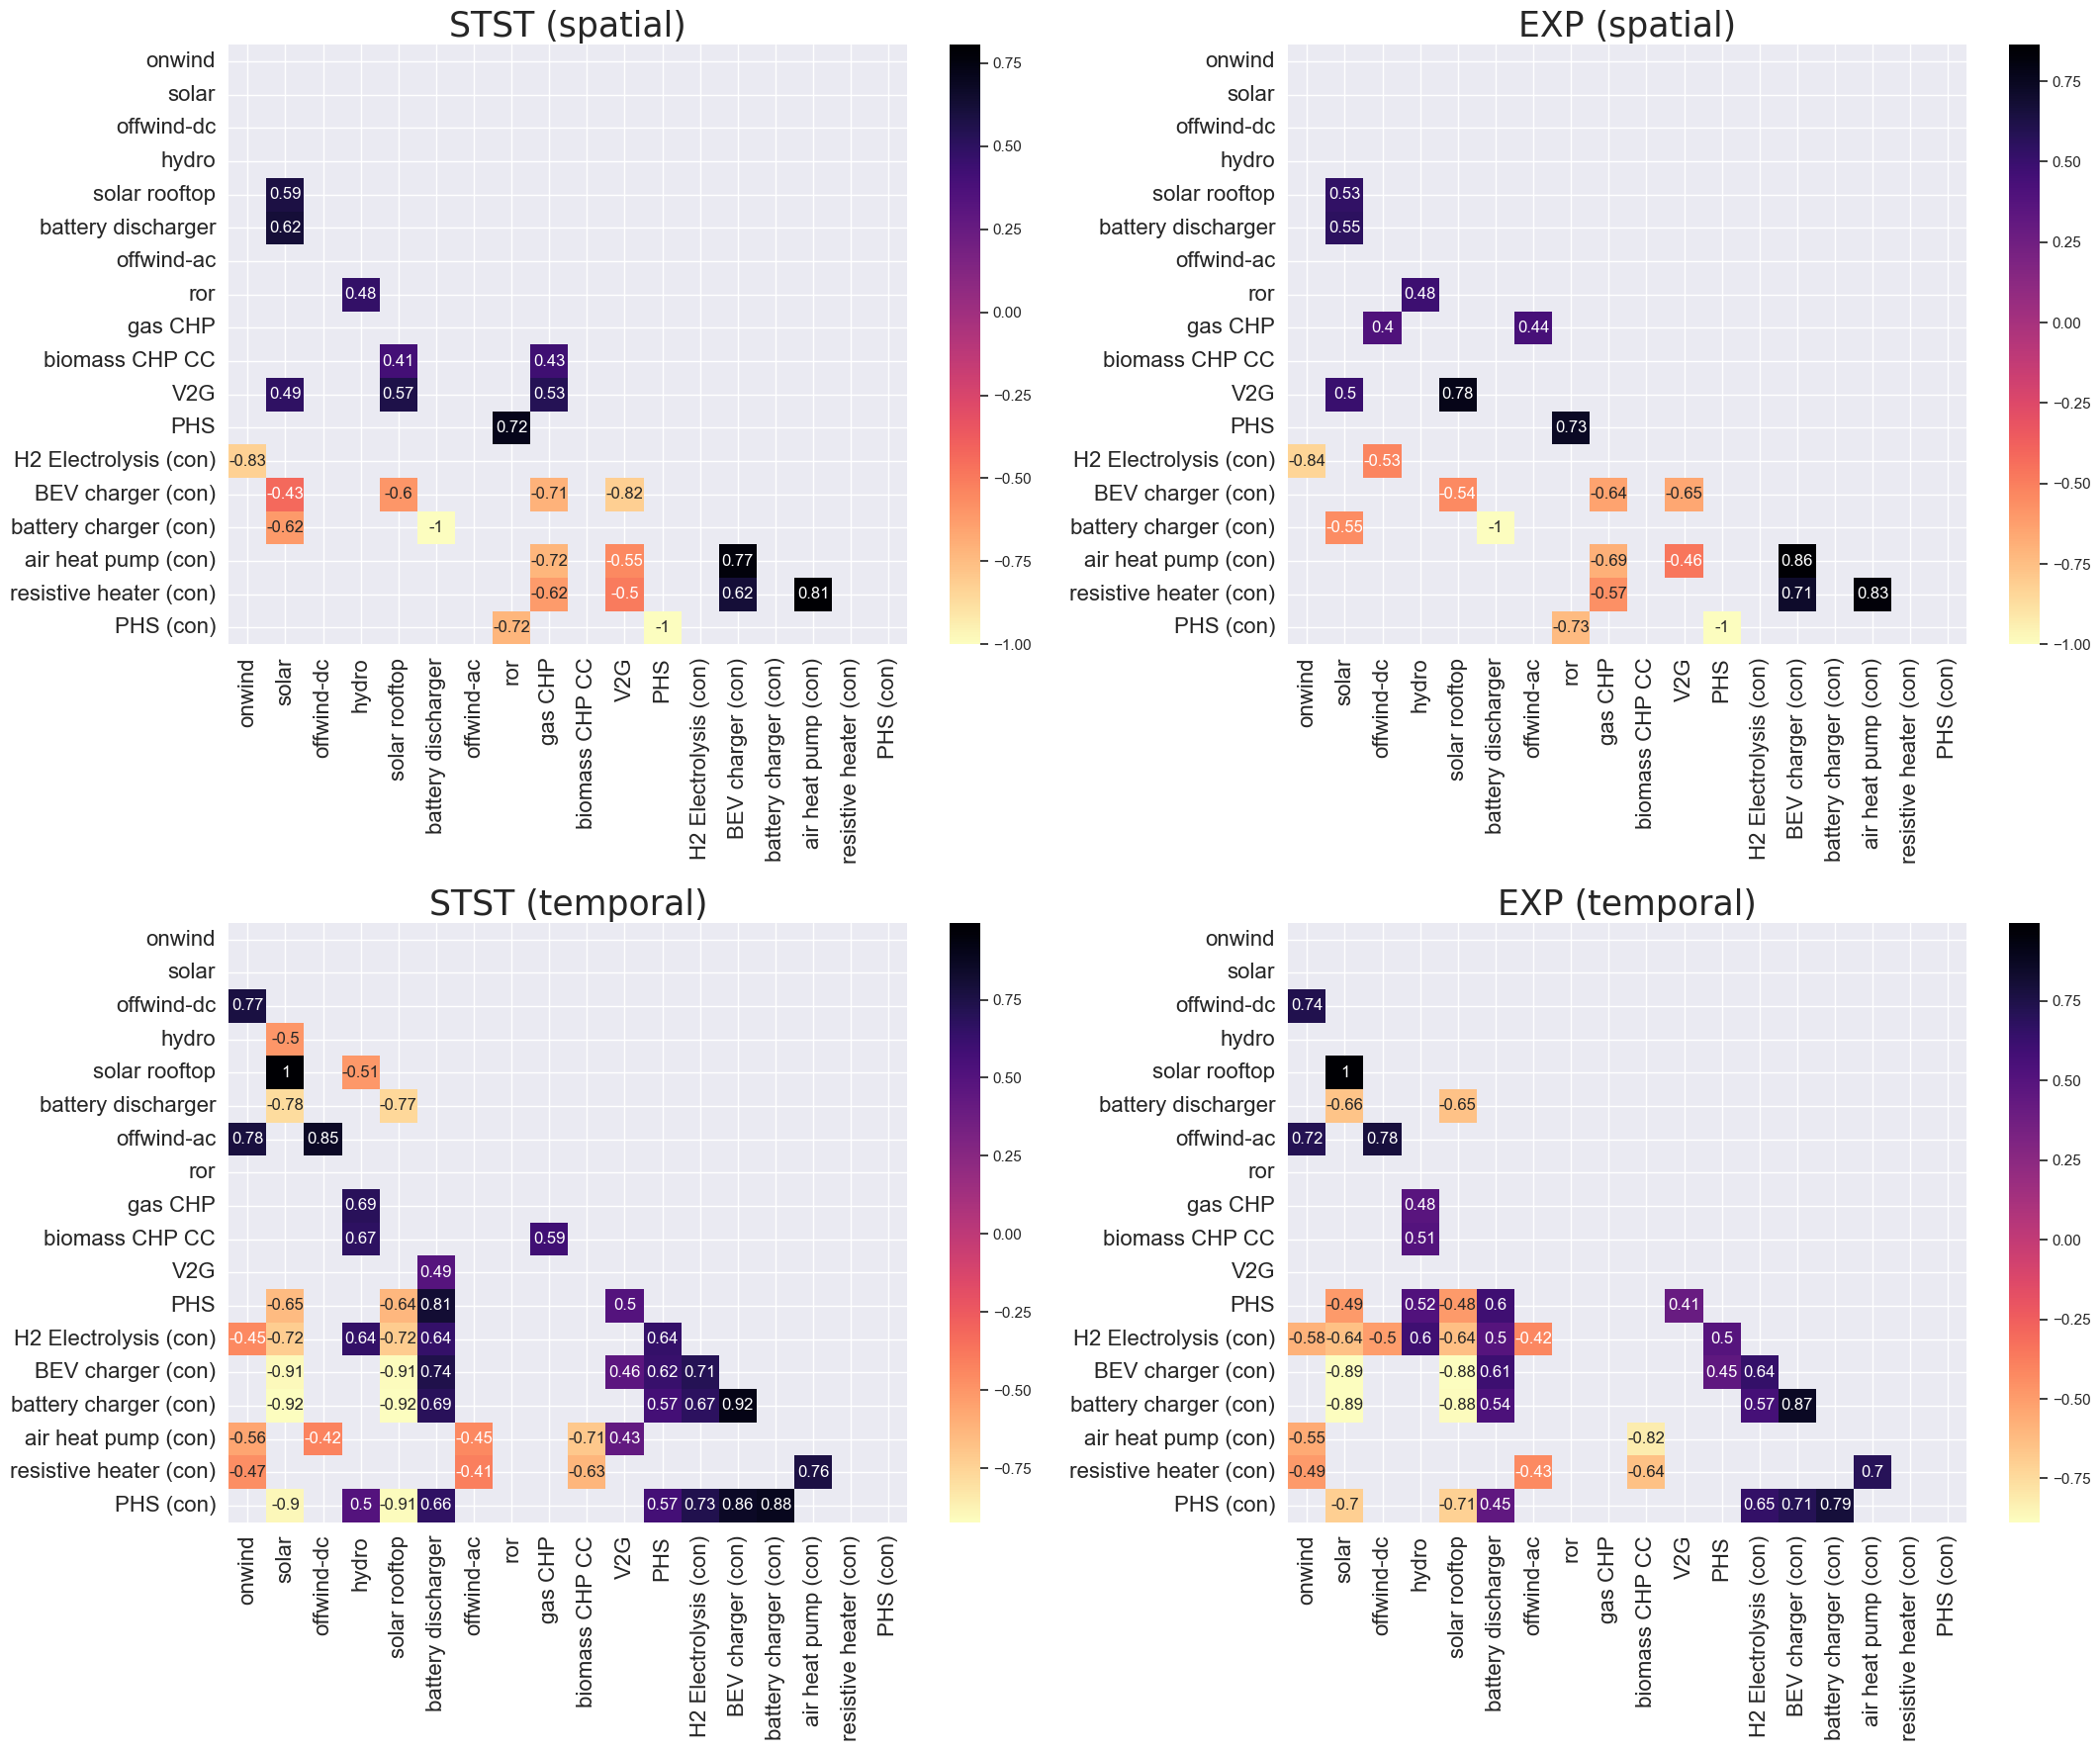

In [96]:
# thesis plot

# Spatial and temporal correlation of gen STST and EXP

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(22, 18))

for title, df, ax in zip(["STST (spatial)", "EXP (spatial)", "STST (temporal)", "EXP (temporal)"], [df_stst_ons, df_exp_ons, df_stst_ts, df_exp_ts], axs.reshape(-1)):
    corr = df[[c + "_gen_el" for c in c_el_gen_s] + [c + "_con_el" for c in c_el_con_s]].corr()
    corr.index = [carrier_renaming.get(n, n) for n in c_el_gen_s] + [carrier_renaming.get(n, n) + " (con)" for n in c_el_con_s]
    corr.columns = [carrier_renaming.get(n, n) for n in c_el_gen_s] + [carrier_renaming.get(n, n)+ " (con)" for n in c_el_con_s]

    mask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(corr[abs(corr) > 0.4], mask=mask, cmap="magma_r", annot=True, ax=ax)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.set_title(title, fontsize=25, **font1)

fig.tight_layout(pad=1.5)
#plt.close()
plt.show()

#fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/el_gen_con_spatial_temporal_corr.png")

In [97]:
def get_generation(carrier = "onwind", n=n_no, period="2013"):

    if carrier in n.generators.carrier.unique().tolist():
        result = n.generators_t.p.loc[period, n.generators.carrier == carrier]
        result.columns = result.columns.map(n.generators.bus)
        result.columns = result.columns.map(n.buses.location)

    elif carrier in n.links.carrier.unique().tolist():
        result = -n.links_t.p1.loc[period, n.links.carrier == carrier]
        result.columns = result.columns.map(n.links.bus1)
        result = result.groupby(result.columns, axis=1).sum()
        result.columns = result.columns.map(n.buses.location)

    elif carrier in n.storage_units.carrier.unique().tolist():
        result = n.storage_units_t.p_dispatch.loc[period, n.storage_units.carrier == carrier]
        result.columns = result.columns.map(n.storage_units.bus)
        result.columns = result.columns.map(n.buses.location)

    elif carrier in n.loads.carrier.unique().tolist():
        result = n.loads_t.p.loc[period, n.loads.carrier == carrier]
        result.columns = result.columns.map(n.loads.bus)
        result.columns = result.columns.map(n.buses.location)

    else:
        result = None

    return result

In [98]:
# generation weighted temporal correlation per location
# corr calculated as: correlation of ts of every time step and every location with all locations ->y 181 correlations; 
# then taking the generation weighted average of these correlations

carriers = c_el_gen_s
n = n_no
res_temp_n_no = pd.DataFrame(index=carriers, columns=carriers)

for c1 in carriers:
    for c2 in carriers:

        gen1 = get_generation(carrier=c1, n=n)
        gen2 = get_generation(carrier=c2, n=n)

        com_cols = gen1.columns.intersection(gen2.columns)
        loc_res = pd.DataFrame(index=com_cols, columns=["corr"])

        for loc in com_cols:
            loc_res.loc[loc,"corr"] = gen1[loc].corr(gen2[loc])

        # correlation of two vectors with constant values is nan
        loc_res.dropna(inplace=True)

        # generation weighted mean of correlations per location
        res_temp_n_no.loc[c1,c2] = round((gen1[loc_res.index].sum() * loc_res.T / gen1[loc_res.index].sum().sum()).sum().sum(), 2)

res_temp_n_no = res_temp_n_no.astype("float")

fig = plt.figure(figsize=(16, 8))
sns.heatmap(res_temp_n_no[abs(res_temp_n_no) > 0.5], annot=True)
plt.close()
plt.show()

## Energy Flow

### Balance map

In [99]:
# plot map with overall electricity balance  per region

In [100]:
# Calc nodal balances

ac_balance = nodal_balance(n_no, "AC", aggregate=["snapshot"])
# change sing so that exports are positive and imports negative
df_stst_ons["el_balance"] = -(ac_balance.droplevel(0).unstack("carrier")[["AC", "DC"]].sum(axis=1).div(1e6))

ac_balance = nodal_balance(n_h2, "AC", aggregate=["snapshot"])
# change sing so that exports are positive and imports negative
df_exp_ons["el_balance"] = -(ac_balance.droplevel(0).unstack("carrier")[["AC", "DC"]].sum(axis=1).div(1e6))

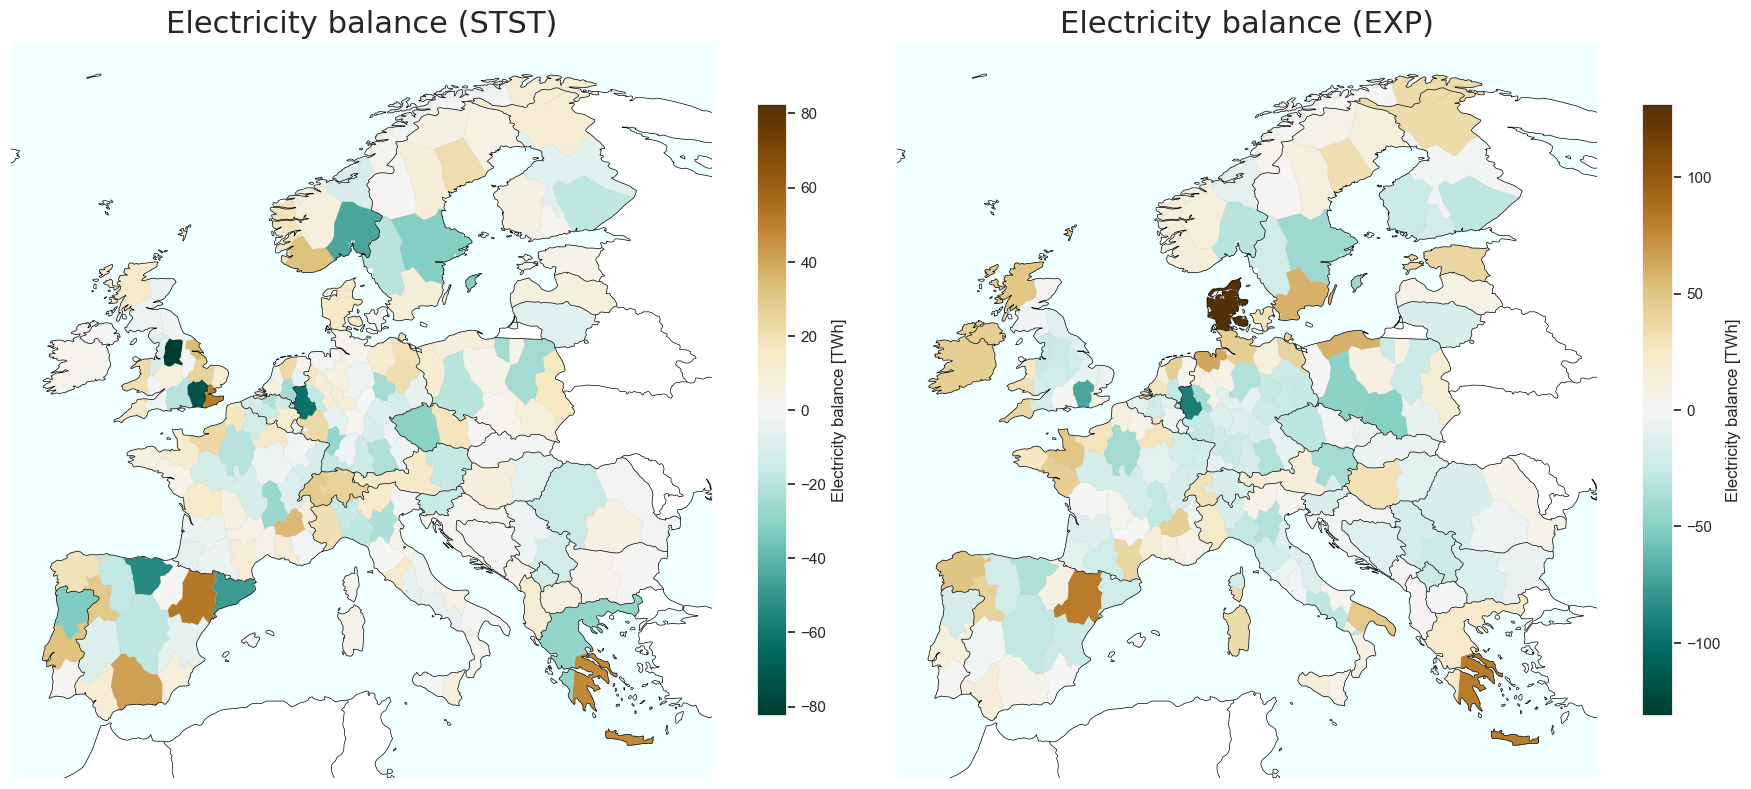

In [101]:
# nodal balance electricity and hydrogen

fig, axs = plt.subplots(ncols=2, nrows=1, subplot_kw={'projection': ccrs.EqualEarth()},
                        figsize=(18, 8))
crs = ccrs.EqualEarth()


for i, ax in enumerate(axs.reshape(-1)):

    if i == 0:
        df = df_stst_ons
        model = "STST"
        
    elif i == 1:
        df = df_exp_ons
        model = "EXP"

    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')
    
    abs_max = max(abs(df["el_balance"].max()) , abs(df["el_balance"].min()))

    df.to_crs(crs.proj4_init).plot(column="el_balance",
                                                   ax=ax,
                                                   cmap=plt.get_cmap('BrBG_r'),
                                                   vmax=abs_max,
                                                   vmin=-abs_max,
                                                   linewidth=0.05,
                                                   edgecolor = 'grey',
                                                   legend=True,
                                                   legend_kwds={'label':"Electricity balance [TWh]",
                            'orientation': "vertical",
                                      'shrink' : 0.8})
    
    ax.set_title(f"Electricity balance ({model})", fontsize=22, **font1)
 
fig.tight_layout() 
plt.show()

**Figure 6 in Neumann paper**
- how is methane determined
- how can this even be plotted with oil? oil is and EU bus? (omplicated)

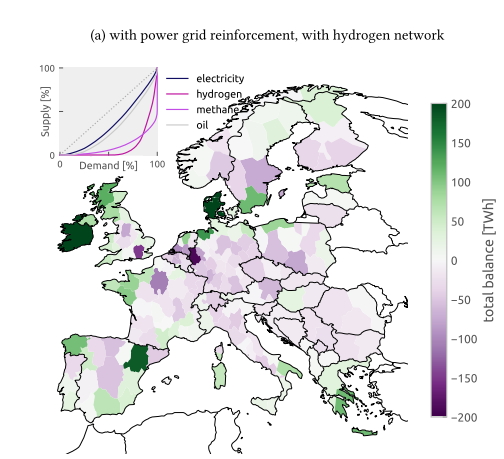

### Balance Flow

![](../../../../Pictures/Screenshots/Screenshot_20230215_101816.png)

In [102]:
n_no.lines_t.p0.sum()

Line
1     -1.187061e+06
10     8.523414e+06
100    4.419293e+06
101    9.065389e+05
102   -1.000031e+06
           ...     
95     9.479547e+05
96    -8.982532e+04
97     1.619466e+05
98     8.198081e+05
99    -1.042867e+06
Length: 323, dtype: float64

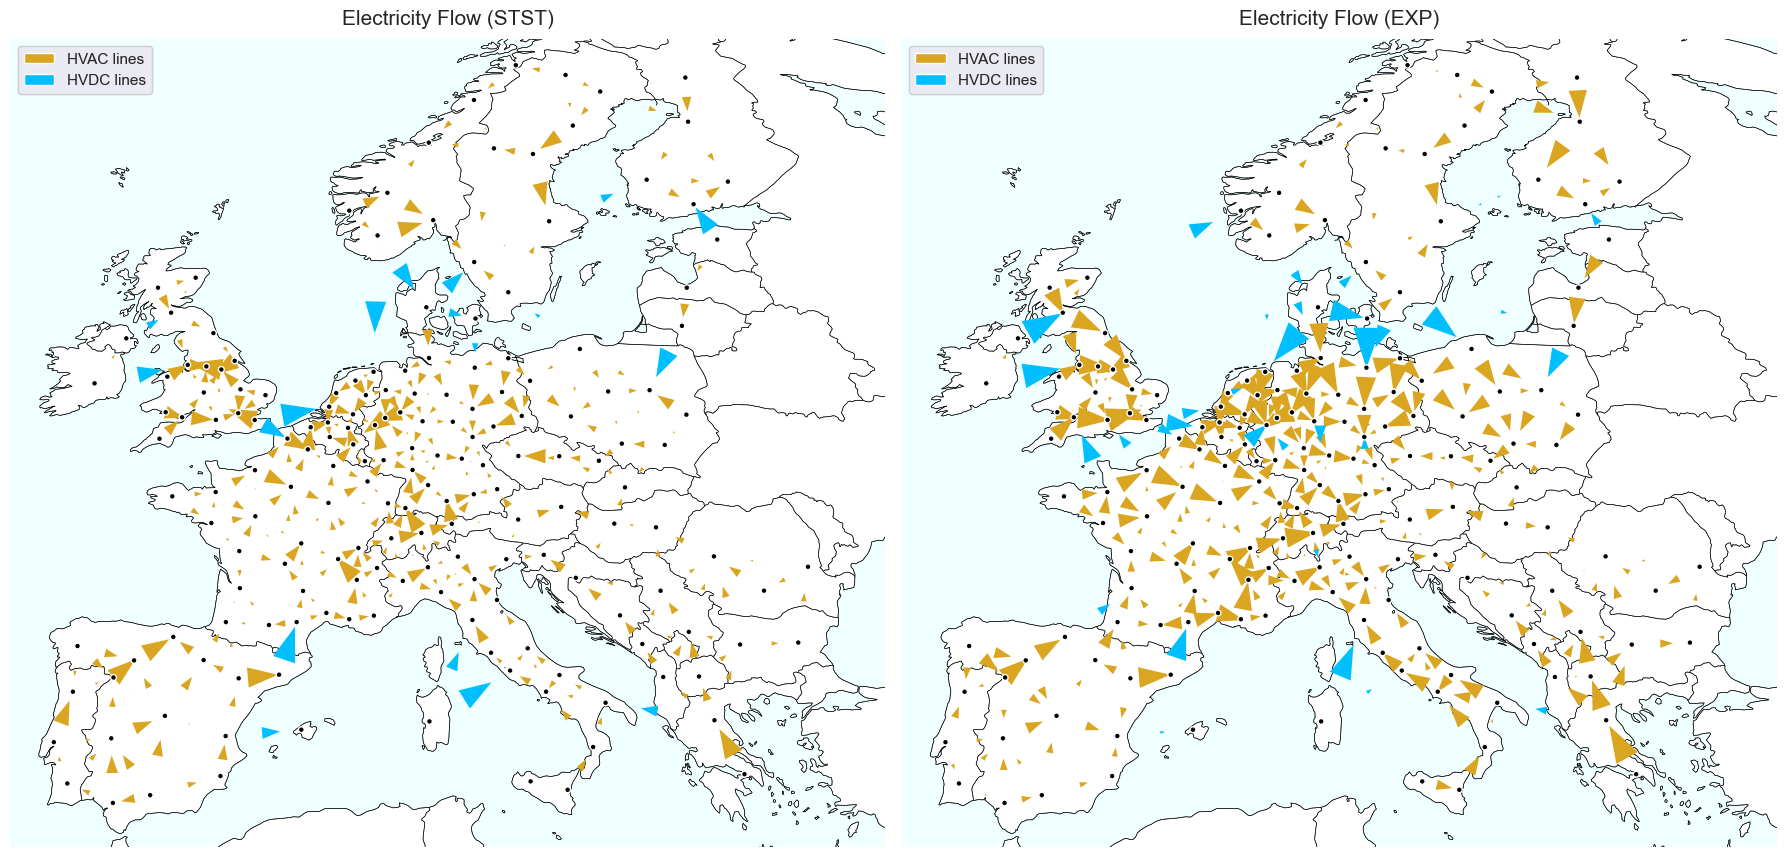

In [103]:
# Electricity network

fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(18, 9))


m_no.plot(ax=ax1, projection=ccrs.EqualEarth(), bus_colors="black", line_colors="goldenrod", link_colors="deepskyblue",
          line_widths=5e-4, link_widths=1e-2, flow="sum")
pypsa.plot.add_legend_patches(ax=ax1, labels=["HVAC lines", "HVDC lines"], colors=["goldenrod","deepskyblue"], legend_kw={'loc': 'upper left'})
ax1.set_title("Electricity Flow (STST)", fontsize=15, pad=10)
ax1.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
ax1.coastlines(edgecolor='black', linewidth=0.5)
ax1.set_facecolor('white')
ax1.add_feature(cartopy.feature.OCEAN, color='azure')


m_h2.plot(ax=ax2, projection=ccrs.EqualEarth(), bus_colors="black", line_colors="goldenrod", link_colors="deepskyblue",
          line_widths=5e-4, link_widths=1e-3, flow="sum")
pypsa.plot.add_legend_patches(ax=ax2, labels=["HVAC lines", "HVDC lines"], colors=["goldenrod","deepskyblue"], legend_kw={'loc': 'upper left'})
ax2.set_title("Electricity Flow (EXP)", fontsize=15, pad=10)
ax2.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
ax2.coastlines(edgecolor='black', linewidth=0.5)
ax2.set_facecolor('white')
ax2.add_feature(cartopy.feature.OCEAN, color='azure')

fig.tight_layout(pad=1)
plt.show()

#fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/el_grid_flow.png")

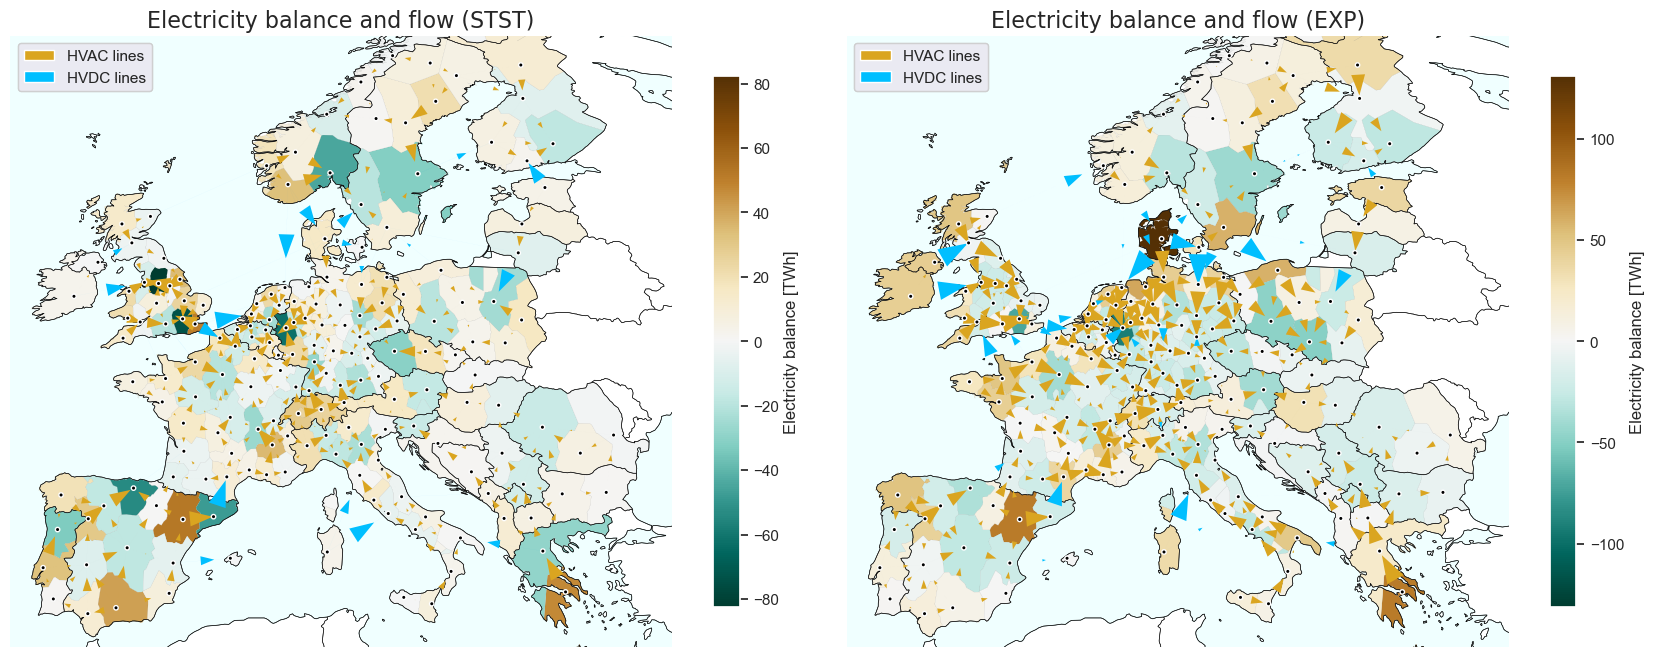

In [104]:
# nodal balance electricity and flow

fig, axs = plt.subplots(ncols=2, nrows=1, subplot_kw={'projection': ccrs.EqualEarth()},
                        figsize=(17, 7))
crs = ccrs.EqualEarth()


for i, ax in enumerate(axs.reshape(-1)):

    if i == 0:
        df = df_stst_ons
        n = m_no
        link_widths = 1e-2
        model = "STST"
        
    elif i == 1:
        df = df_exp_ons
        n = m_h2
        link_widths = 1e-3
        model = "EXP"

    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')
    
    abs_max = max(abs(df["el_balance"].max()) , abs(df["el_balance"].min()))

    df.to_crs(crs.proj4_init).plot(column="el_balance",
                                                   ax=ax,
                                                   cmap=plt.get_cmap('BrBG_r'),
                                                   vmax=abs_max,
                                                   vmin=-abs_max,
                                                   linewidth=0.05,
                                                   edgecolor = 'grey',
                                                   legend=True,
                                                   legend_kwds={'label':"Electricity balance [TWh]",
                            'orientation': "vertical",
                                      'shrink' : 0.8})
    
    n.plot(ax=ax, projection=ccrs.EqualEarth(), bus_colors="black", line_colors="goldenrod", link_colors="deepskyblue",
        line_widths=5e-4, link_widths=link_widths, flow="sum")
    pypsa.plot.add_legend_patches(ax=ax, labels=["HVAC lines", "HVDC lines"], colors=["goldenrod","deepskyblue"], legend_kw={'loc': 'upper left'})


    ax.set_title(f"Electricity balance and flow ({model})", fontsize=16, **font1)
 
fig.tight_layout() 
plt.show()

# fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/el_grid_flow+balance.png")

In [105]:
df_stst_ons["el_balance"].sort_values().tail(10)

name
CH0 0     29.524729
ES0 10    29.832573
PT0 0     32.719136
NO3 5     33.177518
GB5 5     34.692769
FR0 13    35.079989
ES0 11    41.785874
GR0 0     47.582307
GB5 9     50.823411
ES0 3     52.353489
Name: el_balance, dtype: float64

In [106]:
df_exp_ons["el_balance"].sort_values().tail(10)

name
IT0 10     47.233695
GB5 0      49.947822
FR0 18     49.980646
ES0 2      51.185458
PL0 1      58.509319
SE3 3      59.150036
DE0 11     62.747955
ES0 3      81.103966
GR0 0      81.817463
DK0 0     131.319241
Name: el_balance, dtype: float64

In [107]:
# major flows

In [108]:
n = n_no
n.lines_t.p0.sum().sort_values() / 1e6 * 3

Line
225   -45.718616
221   -36.670793
314   -29.617782
19    -27.667828
218   -26.424895
         ...    
138    41.798998
125    43.855734
234    47.582307
135    50.639083
219    56.802683
Length: 323, dtype: float64

In [109]:
n.lines.loc["135"]

bus0                                      ES0 3
bus1                                      ES0 7
num_parallel                           12.34626
length                               199.574562
type                Al/St 240/40 4-bundle 380.0
s_max_pu                                    0.7
s_nom                               20965.21701
capital_cost                        7606.450347
s_nom_max                           30965.21701
x                                      3.976535
r                                      0.484943
b                                      0.010682
carrier                                      AC
x_pu_eff                               0.000028
r_pu_eff                               0.000003
s_nom_opt                           20965.21701
v_nom                                     380.0
g                                           0.0
s_nom_mod                                   0.0
s_nom_extendable                          False
s_nom_min                               

In [110]:
n.links_t.p0.loc[: , n.links.carrier == "DC"].sum().sort_values() /1e6 * 3 

Link
14562     -3.359597
12998     -2.844000
14558     -2.748988
6168      -2.268037
14553     -1.973187
14559+1   -1.876498
14552     -1.707291
14556     -1.394295
5631+4    -0.924096
5686      -0.880496
14547     -0.761678
14531     -0.536630
14542     -0.484751
5625      -0.366168
5626      -0.353825
T13        0.000000
T12        0.000000
T16+1      0.000000
T17        0.000000
T18        0.000000
T19        0.000000
T2         0.000000
T20        0.000000
T21        0.000000
T22        0.000000
T15        0.000000
T10        0.000000
14584      0.000000
T0         0.000000
T23        0.000000
14540      0.000000
14539      0.000000
14538      0.000000
14537      0.000000
T1         0.000000
T24        0.000000
14560      0.090820
14551      0.251246
14555      0.259595
14554      0.434152
14563      1.786087
14550      3.318708
dtype: float64

In [111]:
n.links.loc["14550"]

bus0                                                                   GB5 9
bus1                                                                   NL0 0
carrier                                                                   DC
geometry                   LINESTRING(4.04528166772434 51.9611233898246,2...
length                                                            337.180553
p_nom                                                                 1000.0
tags                                                                        
under_construction                                                       0.0
underground                                                              0.0
p_min_pu                                                                -1.0
underwater_fraction                                                 0.675266
capital_cost                                                    61714.110575
efficiency                                                               1.0

In [112]:
n = n_h2
n.lines_t.p0.sum().sort_values() / 1e6 * 3

Line
218   -62.947494
227   -54.025482
157   -51.237464
81    -50.221541
69    -49.794814
         ...    
35     55.585891
100    56.397800
135    59.278119
217    77.538217
234    81.817463
Length: 323, dtype: float64

In [113]:
# Overall flow in absolute values
n = n_no
n.lines_t.p0.abs().sum().sum() / 1e6 * 3  + n.links_t.p0.loc[: , n.links.carrier == "DC"].abs().sum().sum() /1e6 * 3 

# STST: 4795 TWh ( 4665 (AC) + 129 (DC))
# EXP: 11421 TWh ( 10135 (AC) + 1286 (DC))
# relation: 2.38 

4794.516924332934

In [114]:
11421 / 4795

2.3818561001042755

### Electricity demand

In [115]:
n_no.loads.carrier.unique()

array(['electricity', 'land transport EV', 'land transport fuel cell',
       'residential rural heat', 'services rural heat',
       'residential urban decentral heat',
       'services urban decentral heat', 'urban central heat',
       'solid biomass for industry', 'gas for industry',
       'H2 for industry', 'H2 for shipping', 'naphtha for industry',
       'kerosene for aviation', 'oil emissions',
       'low-temperature heat for industry', 'industry electricity',
       'process emissions', 'agriculture electricity', 'agriculture heat',
       'agriculture machinery oil', 'agriculture machinery oil emissions'],
      dtype=object)

In [116]:
n_no.loads.carrier[n_no.loads.carrier.str.contains("electricity")].unique()

array(['electricity', 'industry electricity', 'agriculture electricity'],
      dtype=object)

In [117]:
# Temporal 

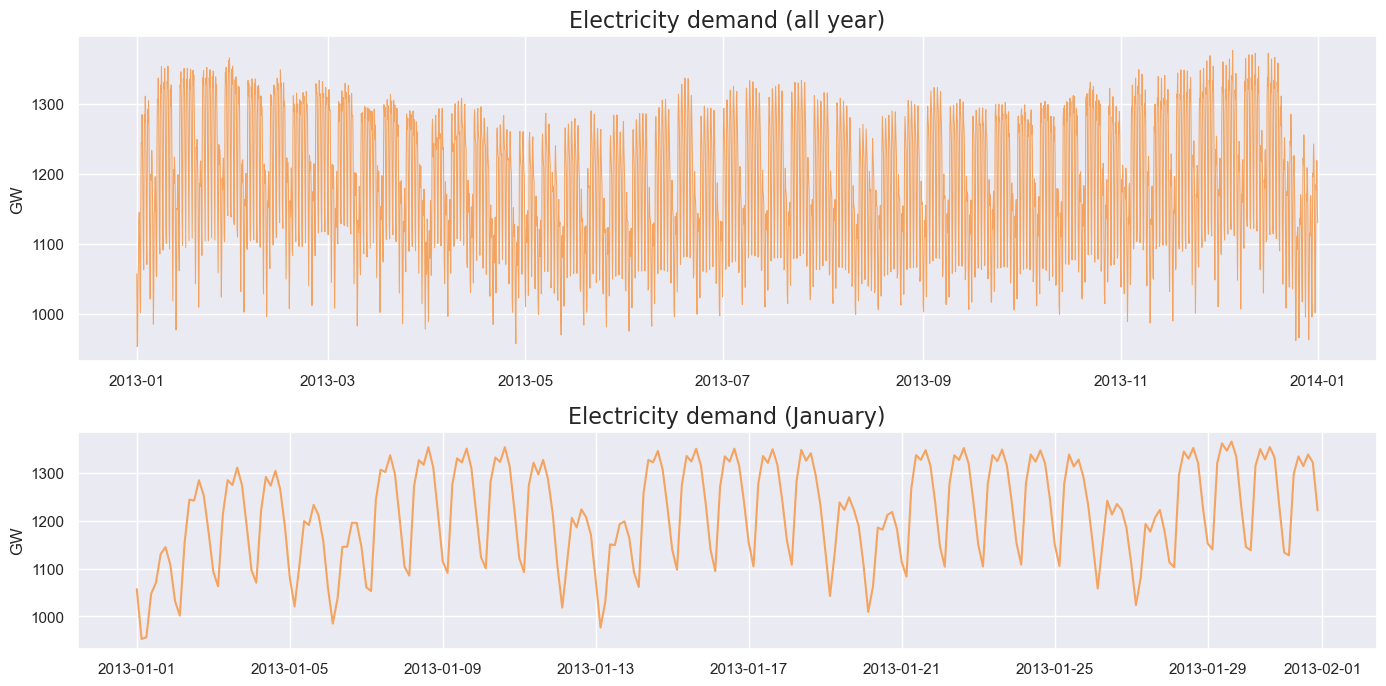

In [118]:
loads = ["electricity", "industry electricity", "agriculture electricity"]
n_no_loads_ts = n_no.loads_t.p.loc[:, n_no.loads.carrier.isin(loads)].sum(axis=1) / 1000 * 3

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2,  height_ratios=[1.5, 1],
                        figsize=(14, 7))

# whole year
ax1.plot(n_no_loads_ts, color="sandybrown", lw=0.75)
# ax1.plot(n_no_loads_ts.resample("D").mean(), color="black", lw=1)
ax1.set_title(f"Electricity demand (all year)", fontsize=16, **font1)
ax1.set_ylabel("GW")

# January
ax2.plot(n_no_loads_ts["2013-01"], color="sandybrown") # ["2013-01-03":"2013-01-05"]
ax2.set_title(f"Electricity demand (January)", fontsize=16, **font1)
ax2.set_ylabel("GW")

fig.tight_layout(pad=1)
plt.show()

# fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/el_demand_temporal.png")

In [119]:
n_h2_loads_ts = n_h2.loads_t.p.loc[:, n_h2.loads.carrier.isin(loads)].sum(axis=1) / 1000 * 3
#plt.plot(n_h2_loads_ts)
#plt.plot(n_h2_loads_ts["2013-01"])

In [120]:
n = n_no
n_no_loads_sp = n_no.loads_t.p.loc[:, n_no.loads.carrier.isin(loads)].sum(axis=0) / 1000 / 1000 * 3
n_no_loads_sp.index = n_no_loads_sp.index.map(n.loads.bus)
n_no_loads_sp.index = n_no_loads_sp.index.map(n.buses.location)
n_no_loads_sp = n_no_loads_sp.groupby(n_no_loads_sp.index, axis=0).sum()
df_stst_ons["el_demand"] = n_no_loads_sp

n = n_h2
n_h2_loads_sp = n_h2.loads_t.p.loc[:, n_h2.loads.carrier.isin(loads)].sum(axis=0) / 1000 / 1000 * 3
n_h2_loads_sp.index = n_h2_loads_sp.index.map(n.loads.bus)
n_h2_loads_sp.index = n_h2_loads_sp.index.map(n.buses.location)
n_h2_loads_sp = n_h2_loads_sp.groupby(n_h2_loads_sp.index, axis=0).sum()
df_exp_ons["el_demand"] = n_h2_loads_sp

for c in loads:
    
    n = n_no
    n_no_loads_sp = n_no.loads_t.p.loc[:, n_no.loads.carrier == c].sum(axis=0) / 1000 / 1000 * 3
    n_no_loads_sp.index = n_no_loads_sp.index.map(n.loads.bus)
    n_no_loads_sp.index = n_no_loads_sp.index.map(n.buses.location)
    n_no_loads_sp = n_no_loads_sp.groupby(n_no_loads_sp.index, axis=0).sum()
    df_stst_ons[f"el_demand_{c}"] = n_no_loads_sp

    n = n_h2
    n_h2_loads_sp = n_h2.loads_t.p.loc[:, n_h2.loads.carrier == c].sum(axis=0) / 1000 / 1000 * 3
    n_h2_loads_sp.index = n_h2_loads_sp.index.map(n.loads.bus)
    n_h2_loads_sp.index = n_h2_loads_sp.index.map(n.buses.location)
    n_h2_loads_sp = n_h2_loads_sp.groupby(n_h2_loads_sp.index, axis=0).sum()
    df_exp_ons["el_demand_{c}"] = n_h2_loads_sp

In [121]:
# demand is the same in both scenarios
(df_stst_ons["el_demand"] == df_exp_ons["el_demand"]).sum()

181

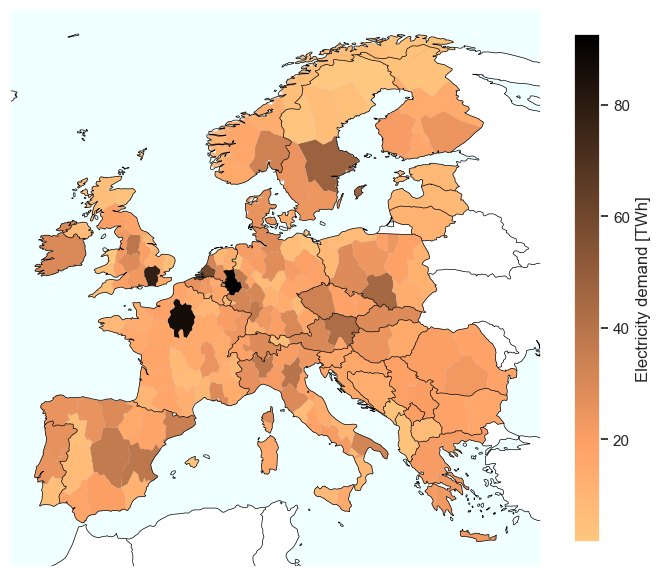

In [122]:
# electricity demand
df = df_stst_ons

fig, ax3 = plt.subplots(ncols=1, nrows=1,
                       subplot_kw={'projection': ccrs.EqualEarth()},
                        figsize=(7, 6))
crs = ccrs.EqualEarth()


ax3.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
ax3.coastlines(edgecolor='black', linewidth=0.5)
ax3.set_facecolor('white')
ax3.add_feature(cartopy.feature.OCEAN, color='azure')


df.to_crs(crs.proj4_init).plot(column="el_demand",
                                               ax=ax3,
                                               cmap=plt.get_cmap('copper_r'),
                                               linewidth=0.05,
                                               edgecolor = 'grey',
                                               legend=True,
                                               legend_kwds={'label':"Electricity demand [TWh]",
                                                            'orientation': "vertical",
                                                            'shrink' : 0.9}
                               )

#ax3.set_title(f"Electricity demand", fontsize=16, **font1)

fig.tight_layout()
plt.show()

# fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/el_demand_spatial.png")

In [123]:
# overall demand
n_no.loads_t.p.loc[:, n_no.loads.carrier.isin(loads)].sum().sum() / 1e6 * 3

3468.1486592790566

In [124]:
# subdivison
n_no.loads_t.p.loc[:, n_no.loads.carrier == "industry electricity"].sum().sum() / 1e6 * 3

1702.5200000000004

In [125]:
df_stst_ons["el_demand"].sort_values()

name
SE3 4      1.606108
GB5 12     1.883907
SE3 7      1.956709
SE3 5      3.227931
DE0 0      3.416765
            ...    
SE3 0     48.099619
NL0 0     58.633333
GB5 13    78.060829
FR0 1     86.409540
DE0 7     92.646631
Name: el_demand, Length: 181, dtype: float64

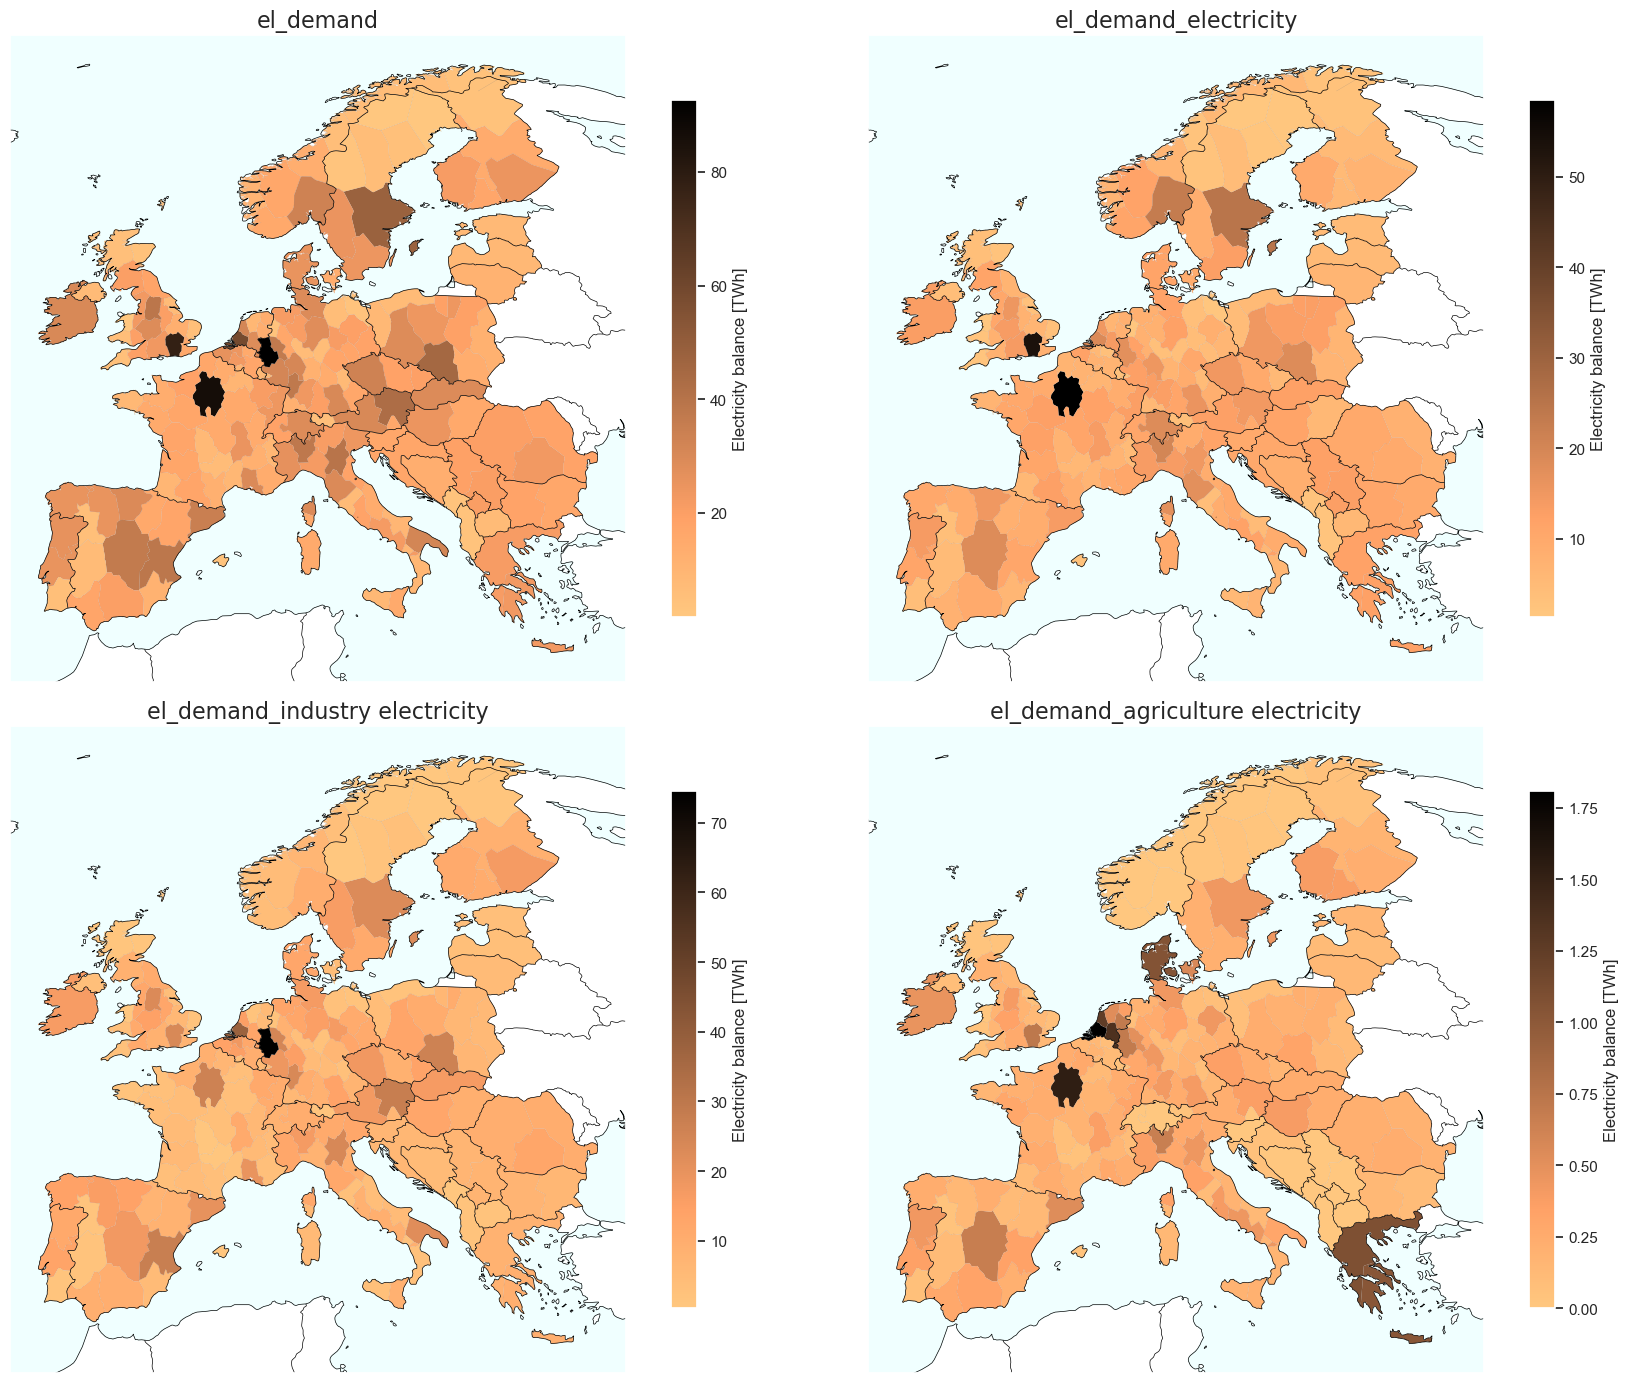

In [126]:
# electricity demand
carriers = ["el_demand","el_demand_electricity", "el_demand_industry electricity", "el_demand_agriculture electricity" ]
df = df_stst_ons

fig, axs = plt.subplots(ncols=2, nrows=2, subplot_kw={'projection': ccrs.EqualEarth()},
                        figsize=(18, 14))
crs = ccrs.EqualEarth()


for i, ax in enumerate(axs.reshape(-1)):

    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')

    df.to_crs(crs.proj4_init).plot(column=f"{carriers[i]}",
                                                   ax=ax,
                                                   cmap=plt.get_cmap('copper_r'),
                                                   linewidth=0.05,
                                                   edgecolor = 'grey',
                                                   legend=True,
                                                   legend_kwds={'label':"Electricity balance [TWh]",
                            'orientation': "vertical",
                                      'shrink' : 0.8})
    

    ax.set_title(f"{carriers[i]}", fontsize=16, **font1)
 
fig.tight_layout() 
plt.show()

In [127]:
df_stst_ons["el_demand_industry electricity"].sort_values()

name
SE3 4      0.29
SE3 7      0.33
GB5 12     0.49
SE3 5      0.51
NO3 1      0.51
          ...  
FR0 1     26.39
ES0 8     27.46
AT0 0     27.67
NL0 0     38.10
DE0 7     74.57
Name: el_demand_industry electricity, Length: 181, dtype: float64

In [128]:
df_stst_ons["el_demand_electricity"].sort_values()

name
SE3 4      1.302218
GB5 12     1.375796
DE0 0      1.583168
SE3 7      1.611017
DE0 3      1.841662
            ...    
IT0 11    20.085183
NO3 6     22.765203
SE3 0     24.812792
GB5 13    53.557369
FR0 1     58.483592
Name: el_demand_electricity, Length: 181, dtype: float64